# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [1]:
1/0

ZeroDivisionError: division by zero

In [7]:
# import libraries here; add more as necessary 

import DataScienceHelperLibrary as dsh # my helper library https://github.com/bwenner/DataScienceHelperLibrary

import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime
from importlib import reload

from IPython.display import HTML
from IPython.display import display, clear_output

from sklearn.model_selection import StratifiedKFold

from sklearn import preprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import learning_curve


# magic word for producing visualizations in notebook
%matplotlib inline

### Load dada and quick check

In [8]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

from sqlalchemy import create_engine

engine = create_engine('sqlite:///{}'.format('CustomerData.db'))

azdias = pd.read_sql_table('azdias', engine)

In [9]:
customers = pd.read_sql_table('customers', engine)

customers = dsh.RemoveColumnsByWildcard(customers, ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

-------------------- Start finding and removing columns matchting to wildcards: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'] --------------------
Columns found to remove:  3
-------------------- Finished removing columns matchting to wildcards --------------------


In [10]:
gc.collect()

3752

In [11]:
print(azdias.shape)
dsh.TailHead(azdias, 5)

(891221, 366)


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0       910215        -1         NaN       NaN          NaN          NaN   
1       910220        -1         9.0       0.0          NaN          NaN   
2       910225        -1         9.0      17.0          NaN          NaN   
3       910226         2         1.0      13.0          NaN          NaN   
4       910241        -1         1.0      20.0          NaN          NaN   
891216  825761        -1         5.0      17.0          NaN          NaN   
891217  825771        -1         9.0      16.0          NaN          NaN   
891218  825772        -1         1.0      17.0          NaN          NaN   
891219  825776        -1         9.0       0.0         17.0          NaN   
891220  825787        -1         1.0       0.0          NaN          NaN   

        ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0               NaN          NaN                   NaN                  NaN   
1               NaN          NaN                  21.0                 11.0   
2               NaN          NaN                  17.0                 10.0   
3               NaN          NaN                  13.0                  1.0   
4               NaN          NaN                  14.0                  3.0   
891216          NaN          NaN                  17.0                 15.0   
891217          NaN          NaN                  16.0                 11.0   
891218          NaN          NaN                  17.0                  3.0   
891219          NaN          NaN                  20.0                  7.0   
891220          NaN          NaN                   NaN                 10.0   

               ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  \
0              ...           NaN       NaN         NaN      NaN   
1              ...           4.0       8.0        11.0     10.0   
2              ...           2.0       9.0         9.0      6.0   
3              ...           0.0       7.0        10.0     11.0   
4              ...           2.0       3.0         5.0      4.0   
891216         ...           2.0       4.0         7.0      8.0   
891217         ...           4.0       6.0         9.0      6.0   
891218         ...           2.0       7.0        10.0      8.0   
891219         ...           4.0       9.0         8.0      5.0   
891220         ...           3.0       8.0        10.0      7.0   

        W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ  \
0                  NaN             NaN       NaN        3         1   
1                  3.0             9.0       4.0        5         2   
2                  3.0             9.0       2.0        5         2   
3                  NaN             9.0       7.0        3         2   
4                  2.0             9.0       3.0        4         1   
891216             3.0             4.0       3.0        4         2   
891217             6.0             9.0       5.0        6         1   
891218             NaN             5.0       7.0        4         2   
891219             1.0             9.0       5.0        5         1   
891220             6.0             3.0       4.0        3         1   

       ALTERSKATEGORIE_GROB  
0                         2  
1                         1  
2                         3  
3                         4  
4                         3  
891216                    3  
891217                    2  
891218                    2  
891219                    1  
891220                    4  

[10 rows x 366 columns]

In [12]:
azdias.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV          ...           \
count         628274.000000        798073.000000          ...            
mean              13.700717             8.287263          ...            
std                5.079849            15.628087          ...            
min                0.000000             0.000000          ...            
25%               11.000000             1.000000          ...            
50%               14.000000             4.000000          ...            
75%               17.000000             9.000000          ...            
max               25.000000           595.000000          ...            

                 VHN       VK_DHT4A     VK_DISTANZ        VK_ZG11  \
count  770025.000000  815304.000000  815304.000000  815304.000000   
mean        2.417322       6.001214       7.532130       5.945972   
std         1.166572       2.856091       3.247789       2.771464   
min         0.000000       1.000000       1.000000       1.000000   
25%         2.000000       3.000000       5.000000       4.000000   
50%         2.000000       6.000000       8.000000       6.000000   
75%         3.000000       9.000000      10.000000       8.000000   
max         4.000000      11.000000      13.000000      11.000000   

       W_KEIT_KIND_HH  WOHNDAUER_2008       WOHNLAGE       ZABEOTYP  \
count   783619.000000   817722.000000  798073.000000  891221.000000   
mean         3.933406        7.908791       4.052836       3.362438   
std          1.964701        1.923137       1.949539       1.352704   
min          0.000000        1.000000       0.000000       1.000000   
25%          2.000000        8.000000       3.000000       3.000000   
50%          4.000000        9.000000       3.000000       3.000000   
75%          6.000000        9.000000       5.000000       4.000000   
max          6.000000        9.000000       8.000000       6.000000   

           ANREDE_KZ  ALTERSKATEGORIE_GROB  
count  891221.000000         891221.000000  
mean        1.522098              2.777398  
std         0.499512              1.068775  
min         1.000000              1.000000  
25%         1.000000              2.000000  
50%         2.000000              3.000000  
75%         2.000000              4.000000  
max         2.000000              9.000000  

[8 rows x 360 columns]

In [13]:
print(customers.shape)
dsh.TailHead(customers, 5)

(191652, 366)


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0         9626         2         1.0      10.0          NaN          NaN   
1         9628        -1         9.0      11.0          NaN          NaN   
2       143872        -1         1.0       6.0          NaN          NaN   
3       143873         1         1.0       8.0          NaN          NaN   
4       143874        -1         1.0      20.0          NaN          NaN   
191647  154561         1         1.0       9.0          NaN          NaN   
191648  154563        -1         2.0       0.0          NaN          NaN   
191649  148813         2         1.0      15.0          NaN          NaN   
191650  148852         3         1.0      13.0          NaN          NaN   
191651  148883         3         1.0       0.0          NaN          NaN   

        ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0               NaN          NaN                  10.0                  1.0   
1               NaN          NaN                   NaN                  NaN   
2               NaN          NaN                   0.0                  1.0   
3               NaN          NaN                   8.0                  0.0   
4               NaN          NaN                  14.0                  7.0   
191647          NaN          NaN                   9.0                  1.0   
191648          NaN          NaN                   0.0                  0.0   
191649          NaN          NaN                  10.0                  1.0   
191650          NaN          NaN                  13.0                  4.0   
191651          NaN          NaN                   9.0                  1.0   

               ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  \
0              ...           3.0       5.0         3.0      2.0   
1              ...           NaN       6.0         6.0      3.0   
2              ...           4.0      10.0        13.0     11.0   
3              ...           2.0       6.0         4.0      2.0   
4              ...           4.0       3.0         5.0      4.0   
191647         ...           4.0       8.0         8.0      5.0   
191648         ...           2.0      10.0         7.0      4.0   
191649         ...           1.0       8.0         8.0      5.0   
191650         ...           3.0       1.0         1.0      1.0   
191651         ...           1.0       1.0         1.0      1.0   

        W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ  \
0                  6.0             9.0       7.0        3         1   
1                  0.0             9.0       NaN        3         1   
2                  6.0             9.0       2.0        3         2   
3                  NaN             9.0       7.0        1         1   
4                  2.0             9.0       3.0        1         1   
191647             6.0             9.0       1.0        3         1   
191648             NaN             9.0       3.0        3         2   
191649             3.0             9.0       3.0        3         1   
191650             4.0             9.0       2.0        3         2   
191651             3.0             9.0       7.0        1         1   

       ALTERSKATEGORIE_GROB  
0                         4  
1                         4  
2                         4  
3                         4  
4                         3  
191647                    3  
191648                    4  
191649                    4  
191650                    3  
191651                    2  

[10 rows x 366 columns]

In [14]:
customers.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.647059    15.377119   
std        4.006050     3.243335     2.753787     2.307653   
min        2.000000     2.000000     5.000000     8.000000   
25%        9.000000    11.000000    13.000000    14.000000   
50%       13.000000    14.000000    15.000000    16.000000   
75%       16.000000    16.000000    17.000000    17.000000   
max       18.000000    18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV          ...           \
count         139810.000000        141725.000000          ...            
mean              10.331579             4.965863          ...            
std                4.134828            14.309694          ...            
min                0.000000             0.000000          ...            
25%                9.000000             1.000000          ...            
50%               10.000000             1.000000          ...            
75%               13.000000             4.000000          ...            
max               25.000000           523.000000          ...            

                 VHN       VK_DHT4A     VK_DISTANZ        VK_ZG11  \
count  137392.000000  143781.000000  143781.000000  143781.000000   
mean        2.429508       4.374417       4.564769       3.168868   
std         1.148821       2.924355       2.887035       2.233516   
min         0.000000       1.000000       1.000000       1.000000   
25%         2.000000       2.000000       2.000000       1.000000   
50%         2.000000       4.000000       4.000000       3.000000   
75%         3.000000       7.000000       7.000000       4.000000   
max         4.000000      11.000000      13.000000      11.000000   

       W_KEIT_KIND_HH  WOHNDAUER_2008       WOHNLAGE       ZABEOTYP  \
count   137910.000000   145056.000000  141725.000000  191652.000000   
mean         4.152716        8.646371       3.723133       2.576806   
std          1.974375        1.154001       2.095540       1.168486   
min          0.000000        1.000000       0.000000       1.000000   
25%          2.000000        9.000000       2.000000       1.000000   
50%          5.000000        9.000000       3.000000       3.000000   
75%          6.000000        9.000000       5.000000       3.000000   
max          6.000000        9.000000       8.000000       6.000000   

           ANREDE_KZ  ALTERSKATEGORIE_GROB  
count  191652.000000         191652.000000  
mean        1.376432              3.060907  
std         0.484492              1.086254  
min         1.000000              1.000000  
25%         1.000000              3.000000  
50%         1.000000              3.000000  
75%         2.000000              4.000000  
max         2.000000              9.000000  

[8 rows x 360 columns]

### Create config class and load info files

I did following pre configurations based on file review.

In [15]:
class CleanConfig:
    
    LowestIdentify = [
        'no *', 'none*', '*low*', '*poorer*', '*urban*', '*demanding*', '*lowest*', '*marginal*', 
        '*minimal*', '*>*24*month*', '*than*24*month*' '*unlikely*', '*demoted*', '*poor*'
]

    UnknownIdentify = [
        '*unknown*', 
        '*no*classification*possible*', 
        '*classification*not*possible*', 
        'no*score*' 
]
    
    ColumnValues = {}
    
    DropColumns = []     
    
    ConvertToFloat = []
    
    ColumnsToLogScale = []
    
    ColumnsToOneHotEnc = []
    
    NumericalColumns = []

    
    RowsToTropByMisNan = 0.2
    ColumnsToDropByMisNan = 0.3
    SkewLimitForLog = 1
    
    
    ColumnsWithoutInfo = []
    
    AttributesNotInAzdias = []
    
    AttributeLevelsNotInAzdias  = []
    
    ColumnsReorderValues = []
    
    ColumnsSummarize = {}
    
    Imputer = preprocessing.Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
    Scaler = preprocessing.StandardScaler()
    ImputerBinary = preprocessing.Imputer(missing_values = 'NaN', strategy = 'most_frequent')
    
    

class ColumnValues:
    def __init__(self, columnName):
        self.ColumnName = columnName
        self.UnknownValues = []
        self.KnownValues = []
        self.AllValues = []
        self.MissingDesc = []
        self.Meanings = []
        self.LowestValue = 0
        self.DType = None
        self.Description = ''
        self.Group = ''
        self.SingleValues = {}
        self.NotConvertable = []
        
    def Add(self, isunknown, value):
        if isunknown:
            self.UnknownValues.append(value)
        else:
            self.KnownValues.append(value)
        self.AllValues.append(value)

    def IsNumeric(self):
        return self.DType in dsh.NumberTypes

def ReadAttributeFiles():
    xlAttributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    xlInfos = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
    return xlAttributes, xlInfos



def PlotValueCounts(df, cols, kind = 'bar', hor = 1 , figsize = (20, 15)):
    '''
    Plot of value_counts.
    
    INPUT:
    df: Dataframe
    kind: plot kind
    hor: Figure seize height
    figsize: Figure seize
    hor: horizontal
    
    OUTPUT:
    returns axes
    '''
    cols = dsh.GetAsList(cols)
    
    if len(cols) == 1:
        return df[cols[0]].value_counts().sort_index().plot(kind = kind)
    lim = len(cols) + 1
    ax = None
    plt.figure(figsize = figsize)
    if hor == 1:
        
        for ind in range(1, lim):
            col = cols[ind - 1]
            ax = plt.subplot(1, lim, ind)
            ax = df[col].value_counts().sort_index().plot(kind = kind)
            ax.set_title('Value counts:\n' + col)
    else:
        for ind in range(1, lim):
            col = cols[lim - 1]
            ax = plt.subplot(lim, 1, ind)
            ax = df[col].value_counts().sort_index().plot(kind = kind)
            ax.set_title('Value counts:\n' + col)
    return ax

def PlotCompare(df1, df2, columns, kind = 'Bar', fzh = 5, name1 = 'Azdias', name2 = 'Customers'):
    '''
    Plot of values.
    
    INPUT:
    df1,2: Dataframe
    kind: plot kind
    fzh: Figure seize height
    name1,2: Titles for left and right
    
    OUTPUT:
    returns plotted dataframe
    '''
    lim = 1
    fzh = len(columns) * fzh
    v, h = len(columns), 2
    plt.figure(figsize = (20, fzh))
    for ind, col in enumerate(columns):
        plt.subplot(v, h, 2 * ind + 1)
        ax = (df1[col].value_counts().sort_index() / df1.shape[0] * 100).plot(kind = kind)
        ax.set_title(col + ' - {}'.format(name1))
        ax.set_ylabel('Percent of whole data set')
        plt.subplot(v, h, 2 * ind + 2)
        ax = (df2[col].value_counts().sort_index() / df2.shape[0] * 100).plot(kind = kind)
        ax.set_title(col + ' - {}'.format(name2))
        ax.set_ylabel('Percent of whole data set')

def PlotCompareDist(df1, df2, columns, kind = 'Bar', fzh = 5, name1 = 'Azdias', name2 = 'Customers'):
    '''
    Box plot of values.
    
    INPUT:
    df1,2: Dataframe
    kind: plot kind
    fzh: Figure seize height
    name1,2: Titles for left and right
    
    OUTPUT:
    returns plotted dataframe
    '''
    lim = 1
    fzh = len(columns) * fzh
    v, h = len(columns), 2
    plt.figure(figsize = (20, fzh))
    for ind, col in enumerate(columns):
        plt.subplot(v, h, 2 * ind + 1)
        ax = sns.boxplot(df1[col])
        ax.set_title(col + ' - {}'.format(name1))
        ax.set_ylabel('Percent of whole data set')
        plt.subplot(v, h, 2 * ind + 2)
        ax = sns.boxplot(df2[col])
        ax.set_title(col + ' - {}'.format(name2))
        ax.set_ylabel('Percent of whole data set')

def PlotIsNullDist(df, top = 100, axis = 0, toplabels = 20, kind = 'bar', figsize = (8, 8)):
    '''
    Plot distribution of null values.
    
    INPUT:
    df: Dataframe
    top: when axis = 1, consider top sorted
    toplabels: print top sorted
    kind: chart
    
    OUTPUT:
    returns plotted dataframe
    '''
    
    dfPlt = None
    plt.figure(figsize = figsize)
    if axis == 0:
        dfPlt = df.isnull().sum(axis = axis).sort_values(ascending = False)[:top]
        dfPlt = dfPlt.apply(lambda x: (x * 100) / df.shape[0])
        ax = dfPlt.plot(kind = kind)
        _ = ax.set_title('Missing values in feature')
        print(dfPlt[:toplabels])
    else:
        vc = df.isnull().sum(axis = axis).value_counts()
        dfPlt = pd.DataFrame(data=vc.values, index = vc.index)
        toplabels = dfPlt.shape[1]
        ax = dfPlt.plot(kind = kind)
        _ = ax.set_title('Value count overview')
        _ = ax.set_ylabel('Number of rows...')
        _ = ax.set_xlabel('... having # nan values')
        print(dfPlt)
    ax.set_xticklabels([])
    
    return dfPlt, ax    


def PlotCalcMean(df):
    tmp = []
    dfsum = CalcMeanOutlinerRows(df)
    for ind in range(11):
        tmp.append(dfsum[dfsum.between(0.0, ind / 11)].shape[0] / dfsum.shape[0])

    tmp = pd.DataFrame(tmp)
    ax = tmp.plot(kind = 'bar')
    ax.set_xticks([x + 0.5 for x in range(0, 11)])
    ax.set_xlabel('% missing values')
    ax.set_ylabel('% of dataset')
    ax.set_xticklabels([str(x) for x in range(0, 110, 10)])

    return tmp, ax
    
    
def PlotHeatmap(df):
    return sns.heatmap(df, cmap = 'Blues')

def PlotSubSet(df1, df2, ind):
    title = 'Distribution for the feature: ' + df1.columns[ind]
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    sns.countplot(df1.iloc[:, ind].values, color = 'blue')
    plt.subplot(1, 2, 2)
    if all(np.isnan(df2.iloc[:, ind].values)):
        #sns.countplot(df2.iloc[:, ind].values, color = 'blue')
        pass
    else:
        sns.countplot(df2.iloc[:, ind].values, color = 'blue')
        
def PlotHeatmap3(df1, df2, df3):
    plt.figure(figsize = (20,15))
    plt.subplot(2, 2, 1)
    ax = PlotHeatmap(df1)
    ax.set_title('Dropped rows')
    plt.subplot(2, 2, 2)
    _ = PlotHeatmap(df2)
    ax.set_title('Considered rows')
    plt.subplot(2, 2, 3)
    _ = PlotHeatmap(df3)
    _ = ax.set_title('Currently all rows')
    
att, inf = ReadAttributeFiles()

In [16]:
att.head()

Unnamed: 0 Attribute         Description Value                     Meaning
0         1h  AGER_TYP  best-ager typology    -1                     unknown
1        NaN       NaN                 NaN     0  no classification possible
2        NaN       NaN                 NaN     1             passive elderly
3        NaN       NaN                 NaN     2            cultural elderly
4        NaN       NaN                 NaN     3   experience-driven elderly

In [17]:
inf.head()

Unnamed: 0 Information level             Attribute  \
0         NaN               NaN              AGER_TYP   
1         NaN            Person  ALTERSKATEGORIE_GROB   
2         NaN               NaN             ANREDE_KZ   
3         NaN               NaN         CJT_GESAMTTYP   
4         NaN               NaN     FINANZ_MINIMALIST   

                                         Description  \
0                                 best-ager typology   
1                      age through prename analysis    
2                                             gender   
3  Customer-Journey-Typology relating to the pref...   
4         financial typology: low financial interest   

                                    Additional notes  
0  in cooperation with Kantar TNS; the informatio...  
1  modelled on millions of first name-age-referen...  
2                                                NaN  
3  relating to the preferred information, marketi...  
4  Gfk-Typology based on a representative househo...

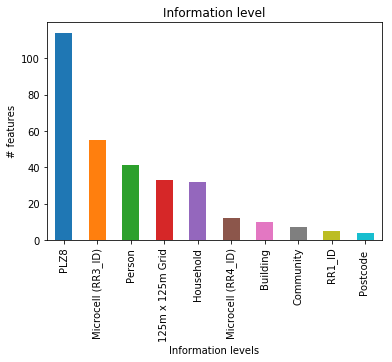

In [18]:
lastlevel = ''
for ind, row in inf.iterrows():
    if type(row['Information level']) == str and len(row['Information level']) > 0:
        lastlevel = row['Information level']
        continue
    if type(row['Information level']) != str and np.isnan(row['Information level']):
        inf.loc[ind, 'Information level'] = lastlevel
        
inf.loc[0, 'Information level'] = inf.loc[1, 'Information level'] = lastlevel

ax = inf['Information level'].value_counts().plot(kind = 'bar')
ax.set_title('Information level')
ax.set_ylabel('# features')
_ = ax.set_xlabel('Information levels')

In [19]:
def LoadColumnsAndValuesInfos(df):
    '''
    Load excel files and initialize CleanConfig
    '''
    xlAttributes, xlInfos = ReadAttributeFiles()
    currentAttrib = ''
    count = 0
    colVal = None

    # iterate over all rows
    
    meaning = ''
    for ind, row in xlAttributes.iterrows():
        
        # remember the current row
        if row['Attribute'] is not np.nan:

            if colVal is not None:
                if not colVal.IsNumeric():
                    colVal.MissingDesc = set(df[colVal.ColumnName].unique()) - set(colVal.AllValues)
                
            currentAttrib = row['Attribute'].replace('CAMEO_DEUINTL_2015', 'CAMEO_INTL_2015') 
            currentAttrib = currentAttrib.replace('SOHO_FLAG', 'SOHO_KZ')
            currentAttrib = currentAttrib.replace('_RZ', '')
            
            if 'D19_KK_KUNDENTYP' in currentAttrib:
                currentAttrib = 'KK_KUNDENTYP'
            elif 'D19_BUCH_' in currentAttrib:
                currentAttrib = 'D19_BUCH_CD'
            
            currentAttrib = currentAttrib.strip()
            
            if currentAttrib not in df.columns:
                CleanConfig.AttributesNotInAzdias.append(currentAttrib)
                colVal = None
                continue
                
            colVal = ColumnValues(currentAttrib)
            colVal.DType = df[currentAttrib].dtype
            CleanConfig.ColumnValues[colVal.ColumnName] = colVal
            
        # When row is not contained in azdias
        if colVal is None:
            continue
        
        # handle descriptions for merged cells
        if str(row['Meaning']) != 'nan':
            meaning = str(row['Meaning'])
        
        colVal.Meanings.append(meaning.split('\n')[0])
        isunknown = any(dsh.IsMatch(meaning, x) for x in CleanConfig.UnknownIdentify)
        currentVal = row['Value']
        
        # if value is a number, then add and continue
        # else try to split and parse to float
        # else add the original string value.
        try:
            if type(currentVal) != str:
                colVal.Add(isunknown, currentVal)
                colVal.Add(isunknown, str(currentVal))
                colVal.Add(isunknown, str(float(currentVal)))
                colVal.SingleValues[str(currentVal)] = meaning
                colVal.SingleValues[currentVal] = meaning

                if any(dsh.IsMatch(meaning, x) for x in CleanConfig.LowestIdentify):
                    if colVal.LowestValue < currentVal:
                        colVal.LowestValue = currentVal
                continue

            currentVal = currentVal.strip()

            # skip numerical columns
            if '...' in currentVal:
                # current column is numerical
                CleanConfig.NumericalColumns.append(col)
                continue
            
            if ',' in currentVal:
                splt = currentVal.split(',')
                for val in splt:
                    try:
                        val = val.strip()
                        colVal.Add(isunknown, val)
                        colVal.SingleValues[val] = meaning
                        flt = float(val)
                        colVal.Add(isunknown, flt)
                        colVal.Add(isunknown, str(flt))
                        colVal.SingleValues[flt] = meaning

                        if any(dsh.IsMatch(meaning, x) for x in CleanConfig.LowestIdentify):
                            if colVal.LowestValue < flt:
                                colVal.LowestValue = flt

                    except:
                        colVal.Add(isunknown, val)
                        colVal.SingleValues[val] = meaning
            else:
                colVal.SingleValues[currentVal] = meaning
                colVal.Add(isunknown, currentVal)
                
                try:
                    flt = float(currentVal)
                    colVal.SingleValues[currentVal] = meaning
                    colVal.Add(isunknown, currentVal)
                except:
                    pass
        except:
            print('Error while processing row {} with value "{}"'.format(ind, currentVal))          
    
       
    grp = ''
    desc = ''
    for ind, row in xlInfos.iterrows():
        
        col = row['Attribute']
        if len(col) == 0:
                continue
                
        desc = desc if str(row['Description']) == 'nan' else row['Description']
        grp = grp if str(row['Information level']) == 'nan' else row['Information level']

        col = col.strip()
        col = col.replace('_ ', '_').replace('_RZ', '')
        
        while ('  ' in col):
            col = col.replace('  ', ' ')
        
        for colsplt in col.split(' '):
            if len(colsplt) == 0:
                continue
                
            if colsplt in list(CleanConfig.ColumnValues.keys()):
                CleanConfig.ColumnValues[colsplt].Description = desc
                CleanConfig.ColumnValues[colsplt].Group = grp
                continue

            if colsplt not in df.columns:
                CleanConfig.AttributeLevelsNotInAzdias.append(colsplt)
                continue

            cv = ColumnValues(colsplt)
            cv.DType = df[colsplt].dtype
            cv.Description = desc
            cv.Group = grp

            CleanConfig.ColumnValues[colsplt] = cv
        
    for col in df.columns:
        if not col in CleanConfig.ColumnValues.keys():
            colVal = ColumnValues(col)
            colVal.DType = df[col].dtype
            colVal.AllValues = list(df[col].unique())
            CleanConfig.ColumnsWithoutInfo.append(col)
            CleanConfig.ColumnValues[colVal.ColumnName] = colVal  
        if df[col].dtype == object:
            cnt = 0
            for val in azdias[col].unique():
                try:
                    _ = float(val)
                except: 
                    cnt = cnt + 1
                    CleanConfig.ColumnValues[col].NotConvertable.append(val)
                if cnt > 50:
                    break    
        else: 
            if len(df[col].value_counts()) > 100 or df[col].max() > 100 or df[col].mean() > 1000:
                CleanConfig.NumericalColumns.append(col)
        
        if len(CleanConfig.ColumnValues[col].NotConvertable) > 0:
            dsh.PrintLine()
            print('Cannot convert values in {}: '.format(col), CleanConfig.ColumnValues[col].NotConvertable, '...')
    
    print('Columns and attributes successfully loaded')
    
LoadColumnsAndValuesInfos(azdias)

-------------------- - --------------------
Cannot convert values in CAMEO_DEU_2015:  [None, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C', '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C', 'XX'] ...
-------------------- - --------------------
Cannot convert values in CAMEO_DEUG_2015:  [None, 'X'] ...
-------------------- - --------------------
Cannot convert values in CAMEO_INTL_2015:  [None, 'XX'] ...
-------------------- - --------------------
Cannot convert values in D19_LETZTER_KAUF_BRANCHE:  [None, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK', 'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS', 'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD', 'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST', 'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT', 'D19_LEBENSMITTEL', 'D19_HAUS_DEKO

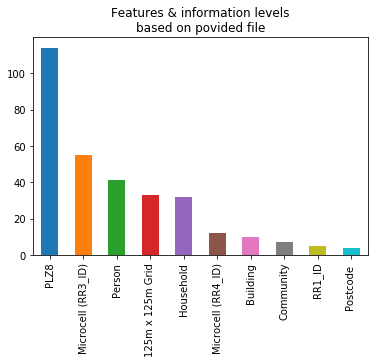

In [20]:
ax = inf.ffill().bfill()['Information level'].value_counts().plot(kind = 'bar')
_ = ax.set_title('Features & information levels\nbased on povided file')

### Features without description

In [21]:
inspect = []
for col in azdias.columns:
    if col in CleanConfig.DropColumns:
        continue
    
    if all([col in CleanConfig.ColumnsWithoutInfo,
        len(CleanConfig.ColumnValues[col].Meanings) == 0,
        len(CleanConfig.ColumnValues[col].Description) == 0]):
        print(col, azdias[col].unique())
        inspect.append(col)
        dsh.PrintLine()
        

LNR [910215 910220 910225 ... 825772 825776 825787]
-------------------- - --------------------
AKT_DAT_KL [nan  9.  1.  5.  8.  7.  6.  4.  3.  2.]
-------------------- - --------------------
ALTER_KIND1 [nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]
-------------------- - --------------------
ALTER_KIND2 [nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]
-------------------- - --------------------
ALTER_KIND3 [nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]
-------------------- - --------------------
ALTER_KIND4 [nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]
-------------------- - --------------------
ALTERSKATEGORIE_FEIN [nan 21. 17. 13. 14. 10. 16. 20. 11. 19. 15. 18.  9. 22. 12.  0.  8.  7.
 23.  4. 24.  6.  3.  2.  5. 25.  1.]
-------------------- - --------------------
ANZ_KINDER [nan  0.  1.  2.  3.  4.  5.  6.  9.  7. 11.  8.]
-------------------- - --------------------
ANZ_STATISTISCHE_HAUSHALTE [ nan  

In [22]:
azdias[(azdias['UMFELD_ALT'] > 3) & (azdias['UMFELD_JUNG'] > 3)].shape

(226470, 366)

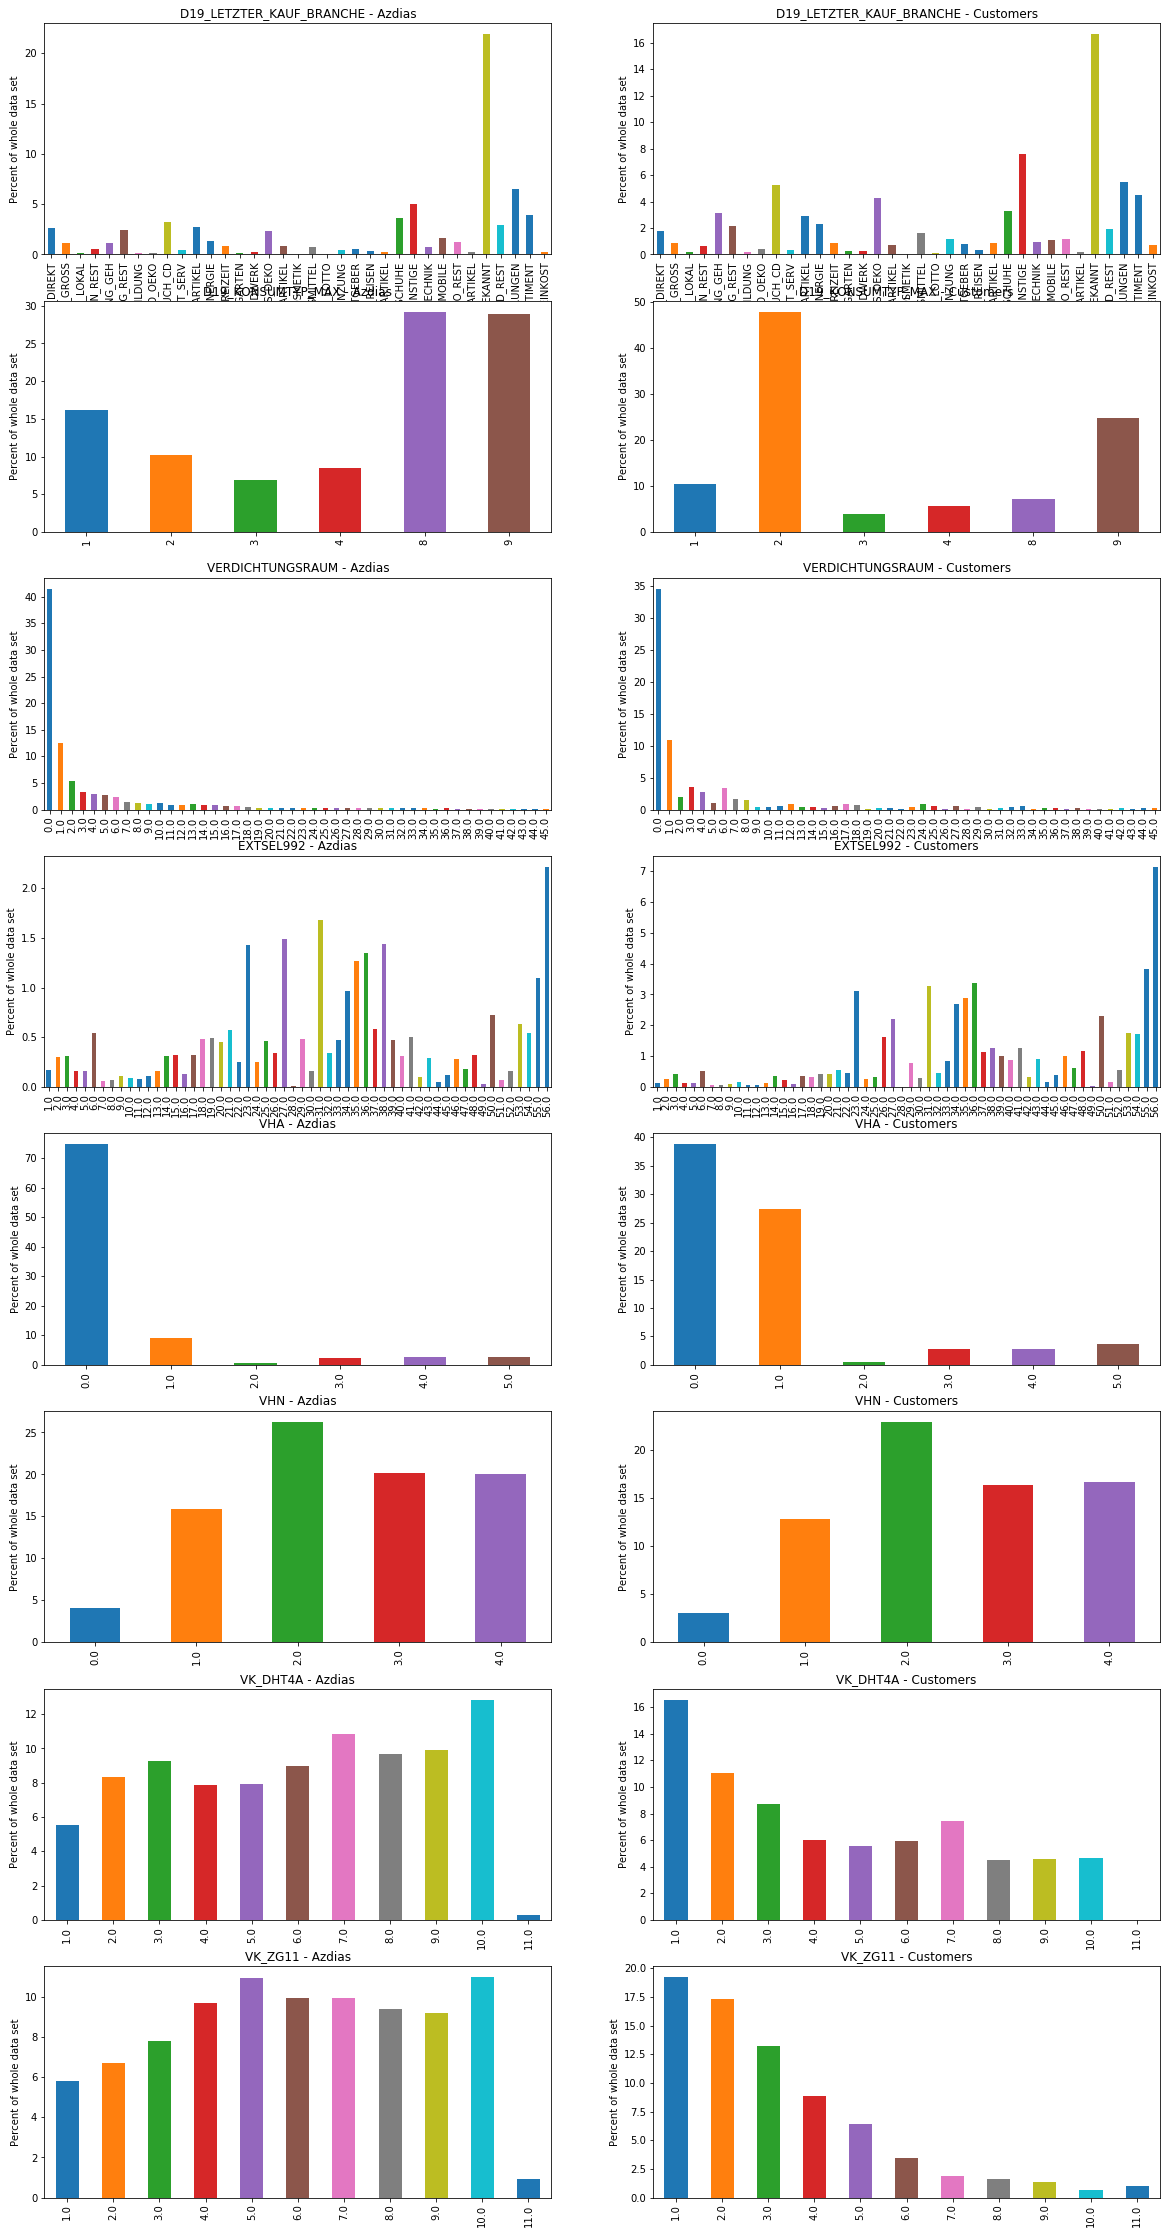

In [23]:
PlotCompare(
    azdias, 
    customers, 
    columns=['D19_LETZTER_KAUF_BRANCHE', 'D19_KONSUMTYP_MAX', 'VERDICHTUNGSRAUM', 'EXTSEL992',  'VHA', 'VHN', 'VK_DHT4A', 'VK_ZG11'], 
    fzh = 5
)

LNR stands for "laufende Nummer" ("running number") and is an index. So I drop this feature.

GEBAEUDE_TYP has values that are not accurate regarding 1=low and 5=high. I remind that in the update value part coming below.

Looking through the data I noticed two gaps:

- ARBEIT [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 9.0]
- KOMBIALTER [1, 2, 3, 4, 9]

The first AZDIAS project provided the Data_Dictioanry.md file with information for following features so I use this information to encode them if necessary.

|1.23. TITEL_K|Z9.1. ARBEIT|
|-------------|------------|
|Academic title flag|Share of unemployment in community|
|1: unknown|1: unknown|
|0: unknown|1: very low|
|1: Dr.|2: low|
|2: Dr. Dr.|3: average|
|3: Prof.|4: high|
|4: Prof. Dr.|5: very high|
|5: other|9: unknown|

There is - beside 0, -1 - another identifier for unknown values, it's the 9. So I add this information to the corresponding list. I assume that 9 is also an identifier for missing values in feature KOMBIALTER.


And now the object features:

The feature EINGEFÜEGT_AM ("inserted on") is out of interest because it gives no information about a persons interest and will be dropped without being processed. Dito for D19_LETZTER_KAUF_BRANCHE (just describing the last buy in the relevant branche). If the values are relative equally distributed, I will consider all D19 columns (respectively those that make sense).

CAMEO_DEUG/INTEL_2015 can be converted to float. (CAMEO_INTL is discussed in the coming steps)

OST_WEST_KZ needs to be one hot encoded.

I'm quite unsure how to treat CAMEO_DEU_2015 because considering this feature would end in 44 new one-hot encoded features or just drop it after cleaning... I decide to drop the column.

I intended to check if 3 is a "limit" meaning: if U_ALT > 3 then is always U_JUNG < 3. But thats false.

"Letzter Kauf" means last buy and I just was interested into the distribution of the branches. Nevertheless, I will drop that column because I don't see any advantage of one-hot encoding this columns resulting in circa 30 new columns. Another idea how to handle this information would be to 

"Verdichtungsraum" (densely populated area) is based on "Einwohnerdichte" (population density, feature EWDICHTE) and "Gemeindegröße" (community size, feature ORTSGR_KLS9) so this feature can be dropped.

But the other columns VHA, VHN etc. don't say anything to me.

In [24]:
inspect.remove('LNR')
inspect.remove('EINGEFUEGT_AM')
inspect.remove('D19_LETZTER_KAUF_BRANCHE')
inspect.remove('VERDICHTUNGSRAUM')


CleanConfig.DropColumns.append('LNR')
CleanConfig.DropColumns.append('CAMEO_DEU_2015')
CleanConfig.DropColumns.append('EINGEFUEGT_AM')
CleanConfig.DropColumns.append('D19_LETZTER_KAUF_BRANCHE')
CleanConfig.DropColumns.append('VERDICHTUNGSRAUM')


CleanConfig.ConvertToFloat.append('CAMEO_DEUG_2015')
CleanConfig.ConvertToFloat.append('CAMEO_INTL_2015')
CleanConfig.ConvertToFloat.append('OST_WEST_KZ')


for col in ['ARBEIT', 'KOMBIALTER']:
    CleanConfig.ColumnValues[col].UnknownValues.extend([9])

CleanConfig.ColumnValues['CAMEO_DEU_2015'].UnknownValues.extend(
    CleanConfig.ColumnValues['CAMEO_DEU_2015'].NotConvertable
)   
CleanConfig.ColumnValues['CAMEO_DEUG_2015'].UnknownValues.extend(
    CleanConfig.ColumnValues['CAMEO_DEUG_2015'].NotConvertable
)
CleanConfig.ColumnValues['CAMEO_INTL_2015'].UnknownValues.extend(
    CleanConfig.ColumnValues['CAMEO_INTL_2015'].NotConvertable
)
CleanConfig.ColumnValues['EINGEFUEGT_AM'].NotConvertable.clear() # don't want to keep that in memory

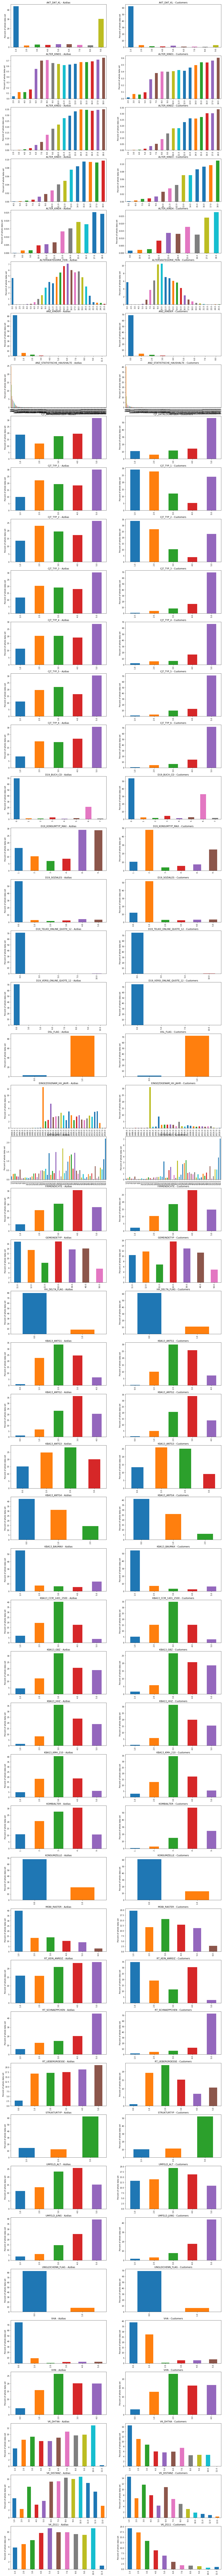

In [25]:
PlotCompare(azdias, customers, columns=inspect, fzh = 5)

### Convert missing values and find values that are not documented

With the information from the provided files, I convert the missing values to np.nan before I continue my analysis.

In [26]:
def PrepMissingValuesToNan(inpDf):
    '''
    Convert missing values to nan based on info from attribute file.
    '''
    dsh.PrintLine('Start converting missing values to nan')
    df = inpDf.copy(deep = True)
    noValuesGiven = []
    noValuesFound = []
    skipped = []
    for cv in CleanConfig.ColumnValues.values():
        if not cv.ColumnName in df.columns:
            skipped.append(cv.ColumnName)
            continue
        
        if cv.ColumnName in CleanConfig.DropColumns:
            skipped.append(cv.ColumnName)
            continue
        if cv.ColumnName in CleanConfig.NumericalColumns:
            skipped.append(cv.ColumnName)
            continue
        
        if len(cv.UnknownValues) == 0:
            noValuesGiven.append(cv.ColumnName)
            if cv.ColumnName in CleanConfig.ConvertToFloat:
                df[cv.ColumnName] = df[cv.ColumnName].astype(float)
                if df[cv.ColumnName].dtype in dsh.NumberTypes:
                    print('Converted to float: ', cv.ColumnName)
                    
        else:
        
            try:          

                pre = df[df[cv.ColumnName].isin(cv.UnknownValues)].shape[0]
                if pre == 0:
                    noValuesFound.append(cv.ColumnName)
                    continue

                df[cv.ColumnName] = df[cv.ColumnName].apply(
                    lambda x: np.nan if (x in cv.UnknownValues or dsh.IsNull(x)) else x
                )

                aft = df[df[cv.ColumnName].isin(cv.UnknownValues)].shape[0]

                print(cv.ColumnName, '-', cv.UnknownValues, '-', pre, '-', aft)

                if cv.ColumnName in CleanConfig.ConvertToFloat:
                    df[cv.ColumnName] = df[cv.ColumnName].astype(float)
                    if df[cv.ColumnName].dtype in dsh.NumberTypes:
                        print('Converted to float: ', cv.ColumnName)

                    else:
                        print('Error converting to float: ', cv.ColumnName)

            except:
                print('Error applying "lambda x: np.nan if x in CleanConfig.ColumnValues[col] else x')       
    
    if len(noValuesGiven) > 0:
        dsh.PrintEncapsulate('Following features had no information about missing values: {}'.format(noValuesGiven))
    if len(noValuesFound) > 0:
        dsh.PrintEncapsulate('Following features did not contain nan values: {}'.format(noValuesGiven))
    if len(skipped) > 0:
        dsh.PrintEncapsulate('Following features were skipped: {}'.format(skipped))
    
    dsh.PrintLine('Finished converting missing values to nan')
    return df    



In [27]:
azRun = PrepMissingValuesToNan(azdias)
cusRun = PrepMissingValuesToNan(customers)

-------------------- Start converting missing values to nan --------------------
AGER_TYP - [-1, '-1', '-1.0', 0, '0', '0.0'] - 685843 - 0
ALTER_HH - [0, '0', '0.0'] - 236768 - 0
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 99352 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 99352 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0'] - 111196 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 13877 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14791 - 0
KBA05_BAUMAX - ['-1', -1.0, '-1.0', '0', 0.0, '0.0'] - 343200 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '

AGER_TYP - [-1, '-1', '-1.0', 0, '0', '0.0'] - 96738 - 0
ALTER_HH - [0, '0', '0.0'] - 22151 - 0
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 50554 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 50554 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0'] - 48990 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 871 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 934 - 0
KBA05_BAUMAX - ['-1', -1.0, '-1.0', '0', 0.0, '0.0'] - 53555 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM4 - ['-1', -1

In [28]:
for col in azRun.columns:
    if col in CleanConfig.DropColumns:
        continue
    keys = list(CleanConfig.ColumnValues[col].SingleValues.keys())
    if len(keys) <= 1:
        continue
    uq = azRun[col].unique()
    for x in uq:
        if dsh.IsNull(x):
            continue
        if not x in keys:
            print(col, '--', x, '--', keys)

KBA05_MODTEMP -- 6.0 -- ['-1', -1.0, '9', 9.0, '1', 1, '2', 2, '3', 3, '4', 4, '5', 5]
LP_FAMILIE_FEIN -- 0.0 -- ['1', 1, '2', 2, '3', 3, '4', 4, '5', 5, '6', 6, '7', 7, '8', 8, '9', 9, '10', 10, '11', 11]
LP_FAMILIE_GROB -- 0.0 -- ['1', 1, '2', 2, '3', 3, '4', 4, '5', 5, '6', 6, '7', 7, '8', 8, '9', 9, '10', 10, '11', 11]
LP_LEBENSPHASE_FEIN -- 0.0 -- ['1', 1, '2', 2, '3', 3, '4', 4, '5', 5, '6', 6, '7', 7, '8', 8, '9', 9, '10', 10, '11', 11, '12', 12, '13', 13, '14', 14, '15', 15, '16', 16, '17', 17, '18', 18, '19', 19, '20', 20, '21', 21, '22', 22, '23', 23, '24', 24, '25', 25, '26', 26, '27', 27, '28', 28, '29', 29, '30', 30, '31', 31, '32', 32, '33', 33, '34', 34, '35', 35, '36', 36, '37', 37, '38', 38, '39', 39, '40', 40]
LP_LEBENSPHASE_GROB -- 0.0 -- ['1', 1, '2', 2, '3', 3, '4', 4, '5', 5, '6', 6, '7', 7, '8', 8, '9', 9, '10', 10, '11', 11, '12', 12]
ORTSGR_KLS9 -- 0.0 -- ['-1', '1', 1, '2', 2, '3', 3, '4', 4, '5', 5, '6', 6, '7', 7, '8', 8, '9', 9]


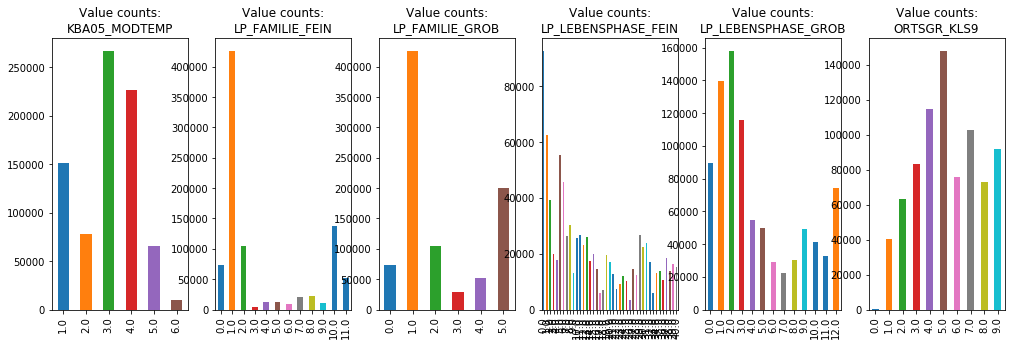

In [29]:
subset = ['KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'ORTSGR_KLS9']
PlotValueCounts(azRun, subset, figsize = (20, 5))

In [30]:
azRun[(azRun['LP_FAMILIE_FEIN'] == 0) & (azRun['LP_FAMILIE_GROB'] != 0) ]

Empty DataFrame
Columns: [LNR, AGER_TYP, AKT_DAT_KL, ALTER_HH, ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4, ALTERSKATEGORIE_FEIN, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_KINDER, ANZ_PERSONEN, ANZ_STATISTISCHE_HAUSHALTE, ANZ_TITEL, ARBEIT, BALLRAUM, CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015, CJT_GESAMTTYP, CJT_KATALOGNUTZER, CJT_TYP_1, CJT_TYP_2, CJT_TYP_3, CJT_TYP_4, CJT_TYP_5, CJT_TYP_6, D19_BANKEN_ANZ_12, D19_BANKEN_ANZ_24, D19_BANKEN_DATUM, D19_BANKEN_DIREKT, D19_BANKEN_GROSS, D19_BANKEN_LOKAL, D19_BANKEN_OFFLINE_DATUM, D19_BANKEN_ONLINE_DATUM, D19_BANKEN_ONLINE_QUOTE_12, D19_BANKEN_REST, D19_BEKLEIDUNG_GEH, D19_BEKLEIDUNG_REST, D19_BILDUNG, D19_BIO_OEKO, D19_BUCH_CD, D19_DIGIT_SERV, D19_DROGERIEARTIKEL, D19_ENERGIE, D19_FREIZEIT, D19_GARTEN, D19_GESAMT_ANZ_12, D19_GESAMT_ANZ_24, D19_GESAMT_DATUM, D19_GESAMT_OFFLINE_DATUM, D19_GESAMT_ONLINE_DATUM, D19_GESAMT_ONLINE_QUOTE_12, D19_HANDWERK, D19_HAUS_DEKO, D19_KINDERARTIKEL, D19_KONSUMTYP, D19_KONSUMTYP_MAX, D19_KOSMETIK, D19_LEBENSMITTEL, D19_LETZTER_KAUF_BRANCHE, D19_LOTTO, D19_NAHRUNGSERGAENZUNG, D19_RATGEBER, D19_REISEN, D19_SAMMELARTIKEL, D19_SCHUHE, D19_SONSTIGE, D19_SOZIALES, D19_TECHNIK, D19_TELKO_ANZ_12, D19_TELKO_ANZ_24, D19_TELKO_DATUM, D19_TELKO_MOBILE, D19_TELKO_OFFLINE_DATUM, D19_TELKO_ONLINE_DATUM, D19_TELKO_ONLINE_QUOTE_12, D19_TELKO_REST, D19_TIERARTIKEL, D19_VERSAND_ANZ_12, D19_VERSAND_ANZ_24, D19_VERSAND_DATUM, D19_VERSAND_OFFLINE_DATUM, D19_VERSAND_ONLINE_DATUM, D19_VERSAND_ONLINE_QUOTE_12, D19_VERSAND_REST, D19_VERSI_ANZ_12, D19_VERSI_ANZ_24, D19_VERSI_DATUM, D19_VERSI_OFFLINE_DATUM, D19_VERSI_ONLINE_DATUM, D19_VERSI_ONLINE_QUOTE_12, D19_VERSICHERUNGEN, D19_VOLLSORTIMENT, D19_WEIN_FEINKOST, DSL_FLAG, EINGEFUEGT_AM, EINGEZOGENAM_HH_JAHR, EWDICHTE, ...]
Index: []

[0 rows x 366 columns]

Interesing that there are some not documented values in documented columns...

Currently I don't see any other other columns that provide more info about social/living status. I will use these features (LP...) to extract more features. So these values will also be converted to null.

Then, before I analyze nan counts and start dropping columns, I intend to extract values for missing values, that might be hided in other columns. For example: if ANZ_TITEL_HH is null but LP_STATUS_FEIN is 7	= title holder-households, then we can definitely the value in ANZ_HH_TITEL to 1.

In [31]:
azdias[(azRun['ANZ_HH_TITEL'].isnull()) & (azdias['LP_STATUS_FEIN'] == 7)].shape

(870, 366)

In [32]:
azdias[(azRun['HH_EINKOMMEN_SCORE'].isnull()) & (~azdias['LP_STATUS_FEIN'].isnull())].shape

(18248, 366)

In [33]:
def Update_ANZ_HH_TITEL(row):
    if np.isnan(row['ANZ_HH_TITEL']):
        if row['LP_STATUS_FEIN'] == 7 or row['TITEL_KZ'] > 0:
            return 1
    return row['ANZ_HH_TITEL']

def AlterKindGiven(row):
    return row['ALTER_KIND1'] > 0 or row['ALTER_KIND2'] > 0 or row['ALTER_KIND3'] > 0 or row['ALTER_KIND4'] > 0

# def Apply_IsMatchWithMeaning(row, search):
#     if np.isnan(row['LP_LEBENSPHASE_FEIN']):
#         return np.nan
#     return dsh.IsMatch(CleanConfig.ColumnValues['LP_LEBENSPHASE_FEIN'].SingleValues[row['LP_LEBENSPHASE_FEIN']], search)

def Apply_HasChildren(row):
    return any(
        [row['LP_FAMILIE_FEIN'] in [3, 4, 5, 6, 7, 8, 10, 11],
        row['LP_LEBENSPHASE_FEIN'] in CleanConfig.ColumnValues['LP_LEBENSPHASE_FEIN'].SingleValues.keys() and dsh.IsMatch(CleanConfig.ColumnValues['LP_LEBENSPHASE_FEIN'].SingleValues[row['LP_LEBENSPHASE_FEIN']], '*parent*'),
        AlterKindGiven(row)])
    


def Update_EINKOMMEN_SCORE(row):
    if not np.isnan(row['HH_EINKOMMEN_SCORE']):
        return row['HH_EINKOMMEN_SCORE']
    
    lpfein = row['LP_STATUS_FEIN']
    lbgrob = row['LP_STATUS_GROB']
    
    if lpfein in [1,2,3] or lbgrob in [1,2]:
        return 5
    if lpfein in [4, 6] or lbgrob in [3, 4, 5]:
        return 4
    if lpfein in [5, 7] or lbgrob in [6, 7]:
        return 3
    if lpfein in [8, 9] or lbgrob in [8, 9]:
        return 2
    if lpfein in [10] or lbgrob in [10]:
        return 1
    return row['HH_EINKOMMEN_SCORE']
            
def PrepUpdateValues(dfInput):
    df = dfInput.copy(deep = True)
    
    dsh.PrintLine('Convert undocumented values to nan')
    
    for col in ['KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'ORTSGR_KLS9']:
        rep = 0
        if col == 'KBA05_MODTEMP':
            rep = 6
        df[col] = df[col].apply(lambda x: np.nan if x == rep else x)
        print(col, ' creplace value: ', rep)
    
    dsh.PrintLine('Update values based on other columns')
    
    df['ANZ_HH_TITEL'] =  df.apply(lambda row: Update_ANZ_HH_TITEL(row), axis = 1)
    df['HH_EINKOMMEN_SCORE'] =  df.apply(lambda row: Update_EINKOMMEN_SCORE(row), axis = 1)
    df['W_KEIT_KIND_HH'] = df.apply(lambda row: 4 if Apply_HasChildren(row) > 0 else row['W_KEIT_KIND_HH'], axis = 1)

    # GEMEINDETYP [nan 22. 40. 21. 12. 30. 11. 50.]
    df['GEMEINDETYP'] = df['GEMEINDETYP'].apply(lambda x:
                                               np.NaN if dsh.IsNull(x)
                                               else 1 if x == 11
                                               else 2 if x == 12
                                               else 3 if x == 21
                                               else 4 if x == 22
                                               else 5 if x == 30
                                               else 6 if x == 40
                                               else 5 if x == 50
                                               else np.NaN)
    
    dsh.PrintLine('Finished')
    
    return df

In [34]:
azRun = PrepUpdateValues(azRun)
cusRun = PrepUpdateValues(cusRun)

-------------------- Convert undocumented values to nan --------------------
KBA05_MODTEMP  creplace value:  6
LP_FAMILIE_FEIN  creplace value:  0
LP_FAMILIE_GROB  creplace value:  0
LP_LEBENSPHASE_FEIN  creplace value:  0
LP_LEBENSPHASE_GROB  creplace value:  0
ORTSGR_KLS9  creplace value:  0
-------------------- Update values based on other columns --------------------
-------------------- Finished --------------------
-------------------- Convert undocumented values to nan --------------------
KBA05_MODTEMP  creplace value:  6
LP_FAMILIE_FEIN  creplace value:  0
LP_FAMILIE_GROB  creplace value:  0
LP_LEBENSPHASE_FEIN  creplace value:  0
LP_LEBENSPHASE_GROB  creplace value:  0
ORTSGR_KLS9  creplace value:  0
-------------------- Update values based on other columns --------------------
-------------------- Finished --------------------


After converting unknown values to nan, the chance is given that there are now columns having more nan values than before and who might now also be dropped.

### Have a glance at data

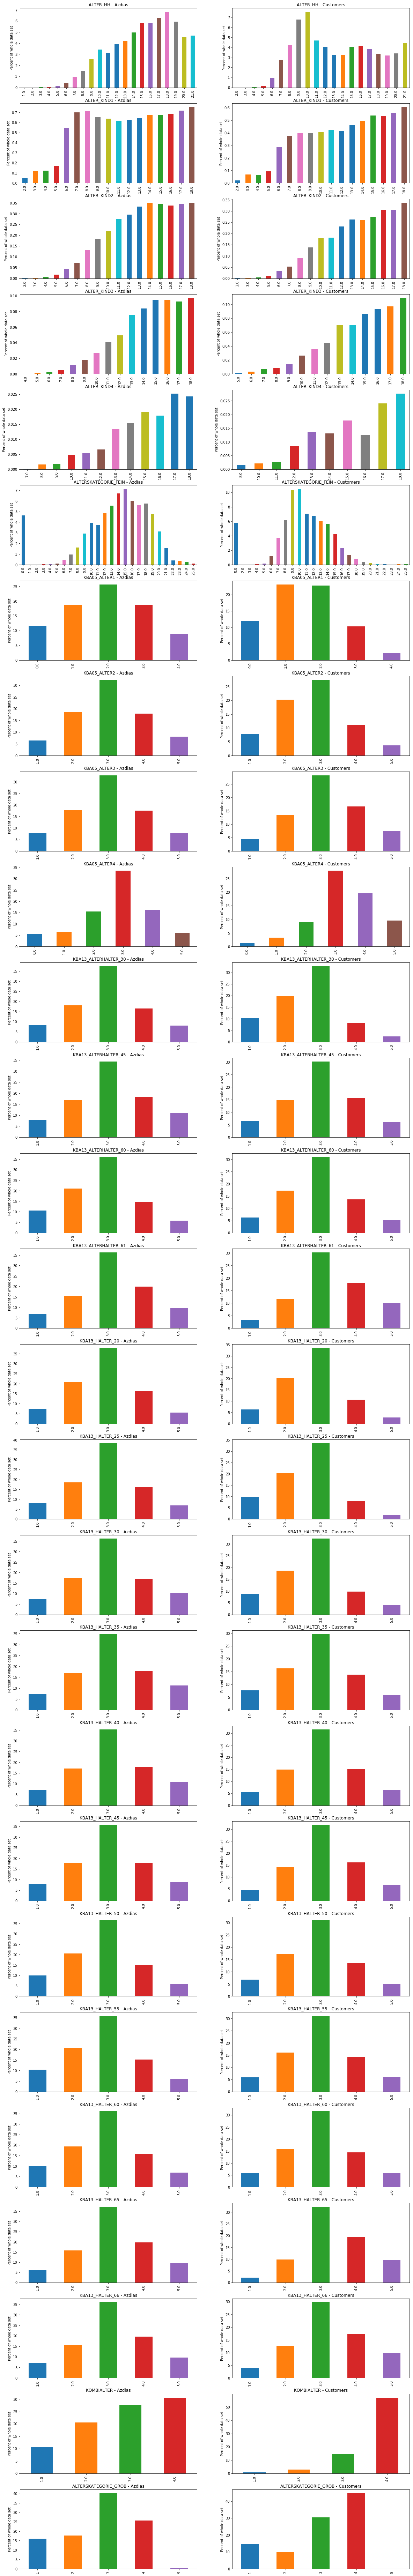

In [35]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun.columns, '*alter*'))

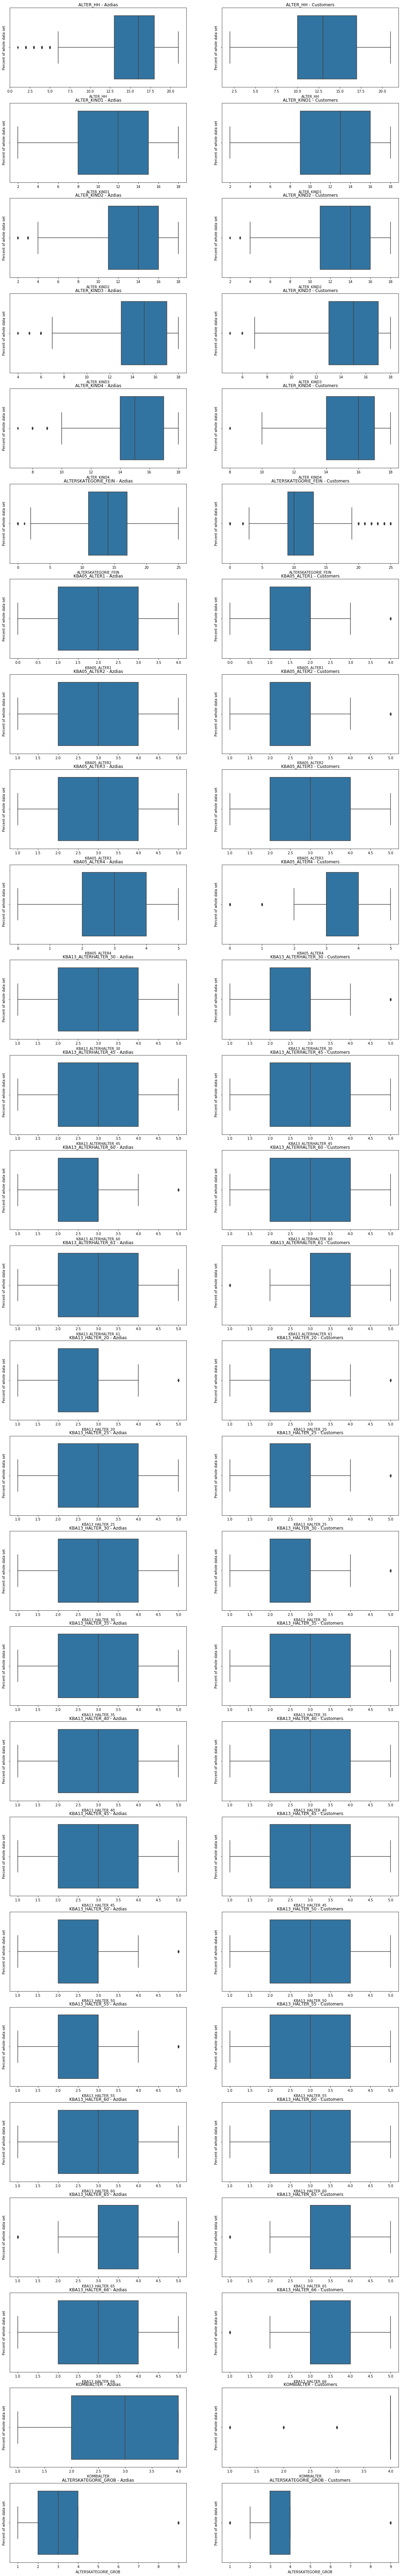

In [36]:
PlotCompareDist(azRun, cusRun, dsh.GetMatches(azRun.columns, '*alter*'))

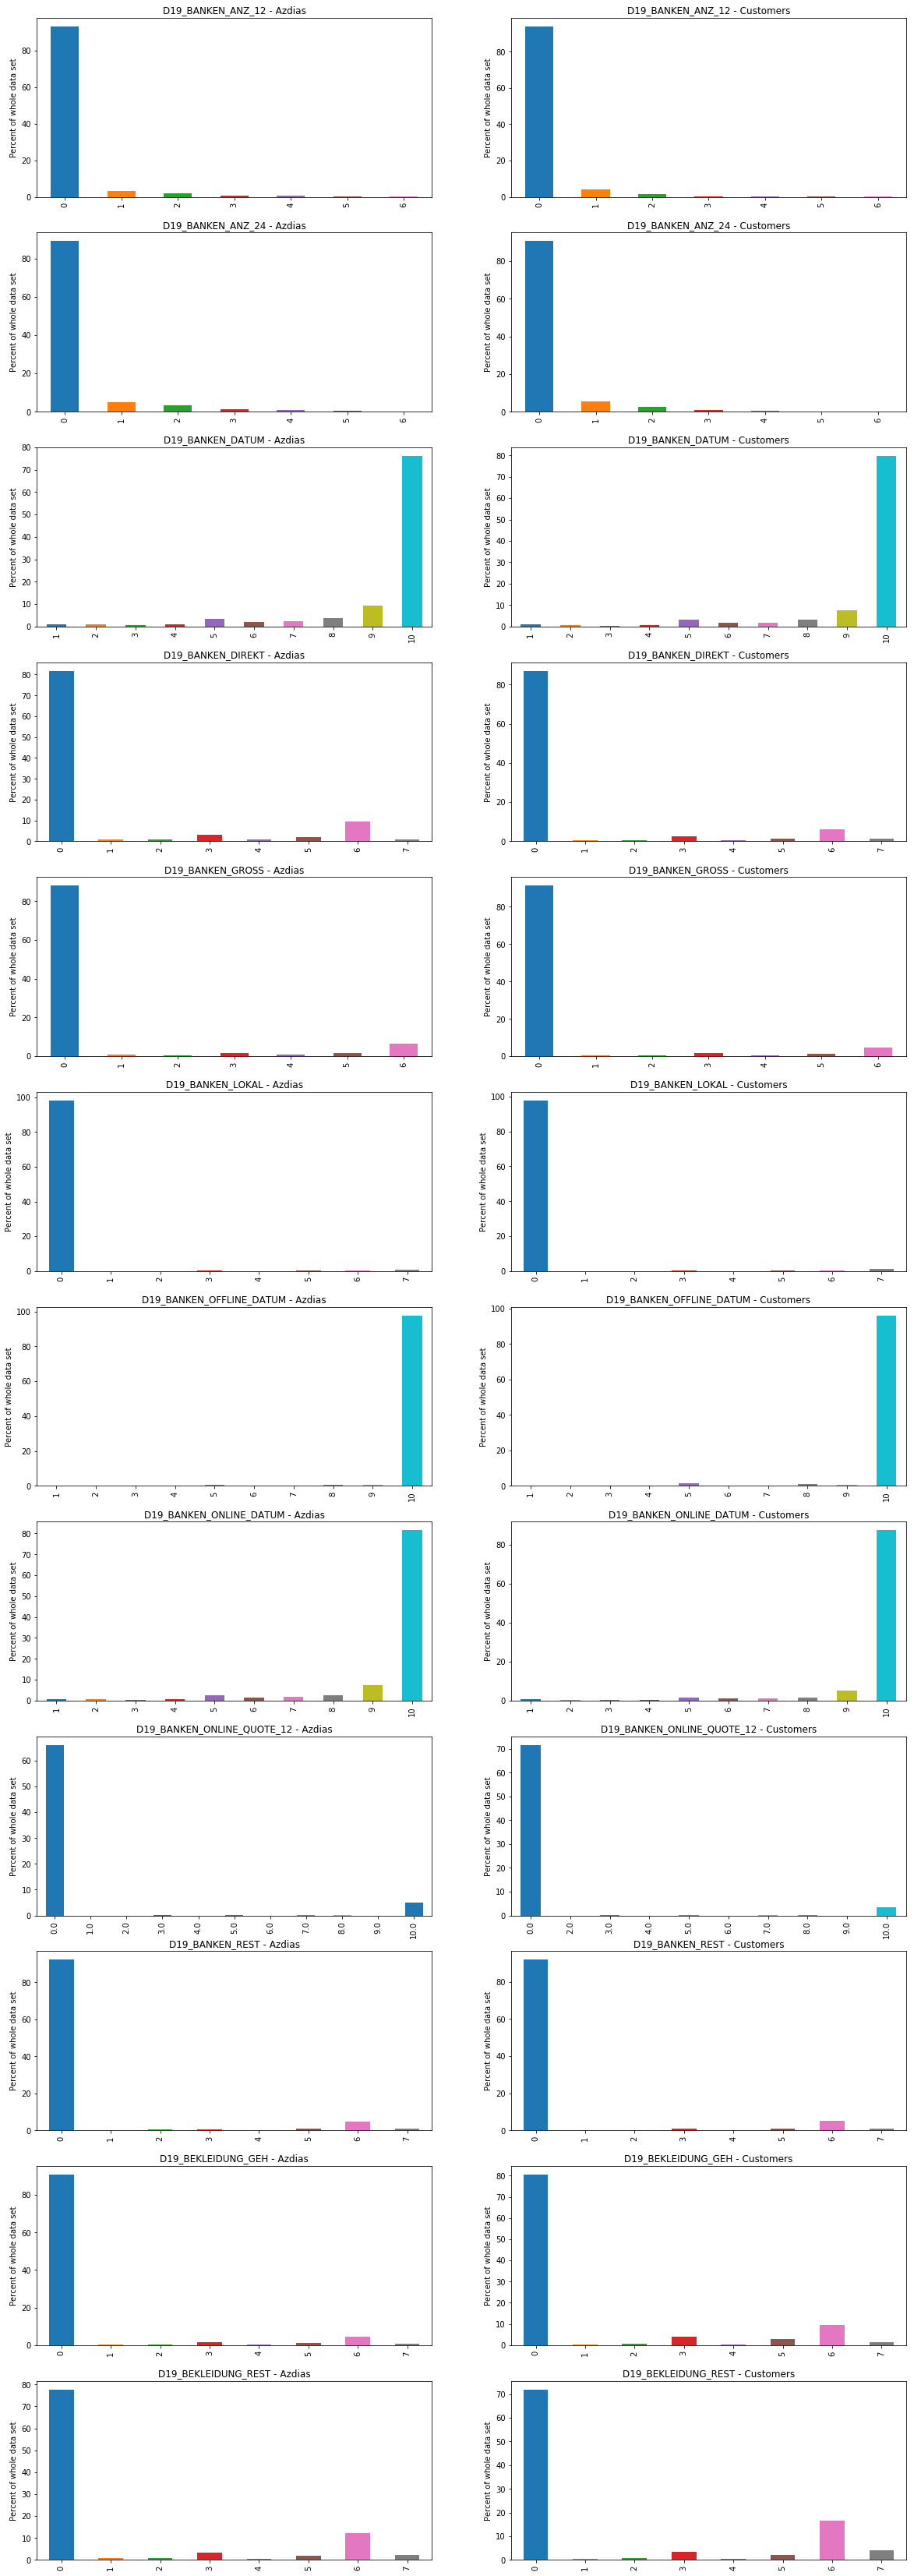

In [37]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun.columns, '*D19*')[:12])

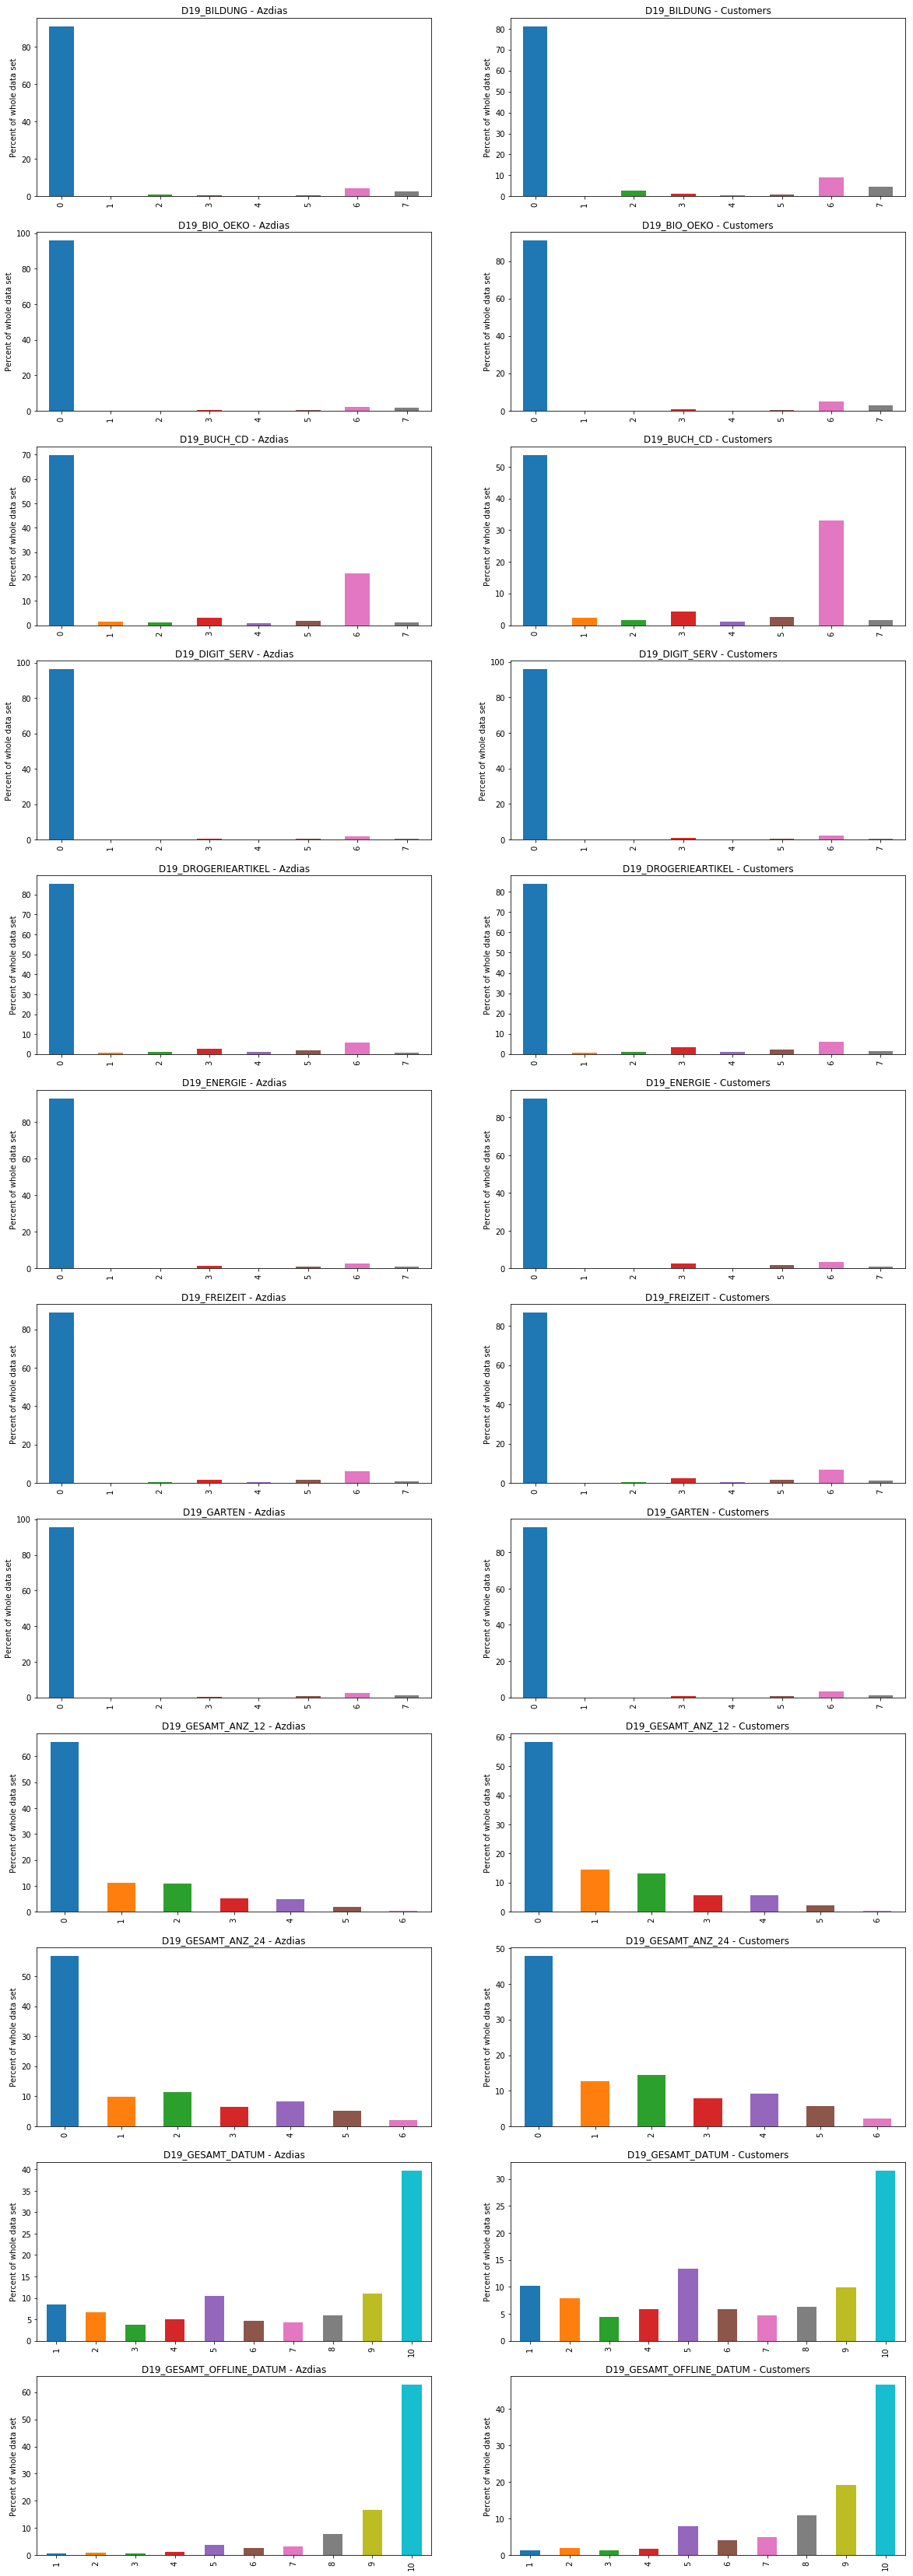

In [38]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun.columns, '*D19*')[12:24])

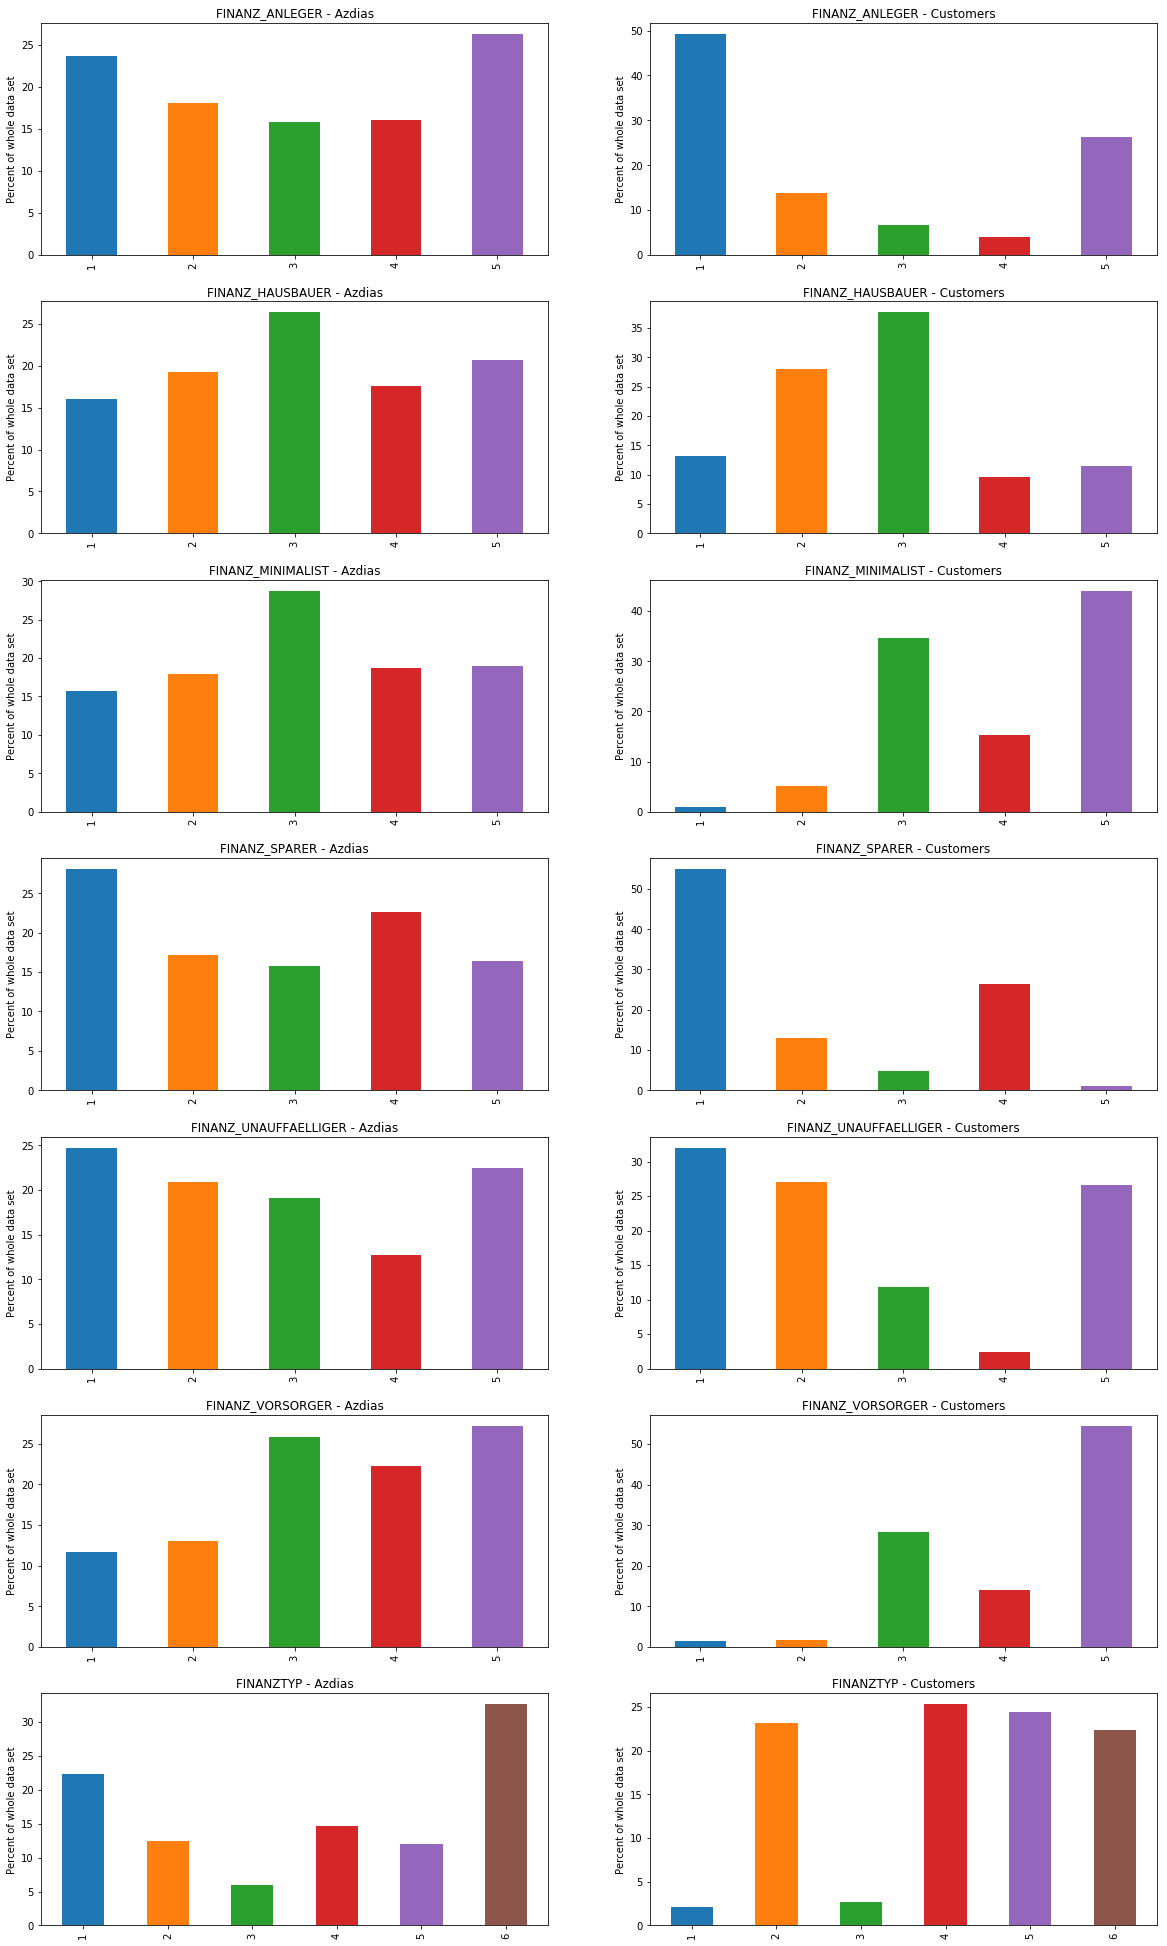

In [39]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*finanz*'))

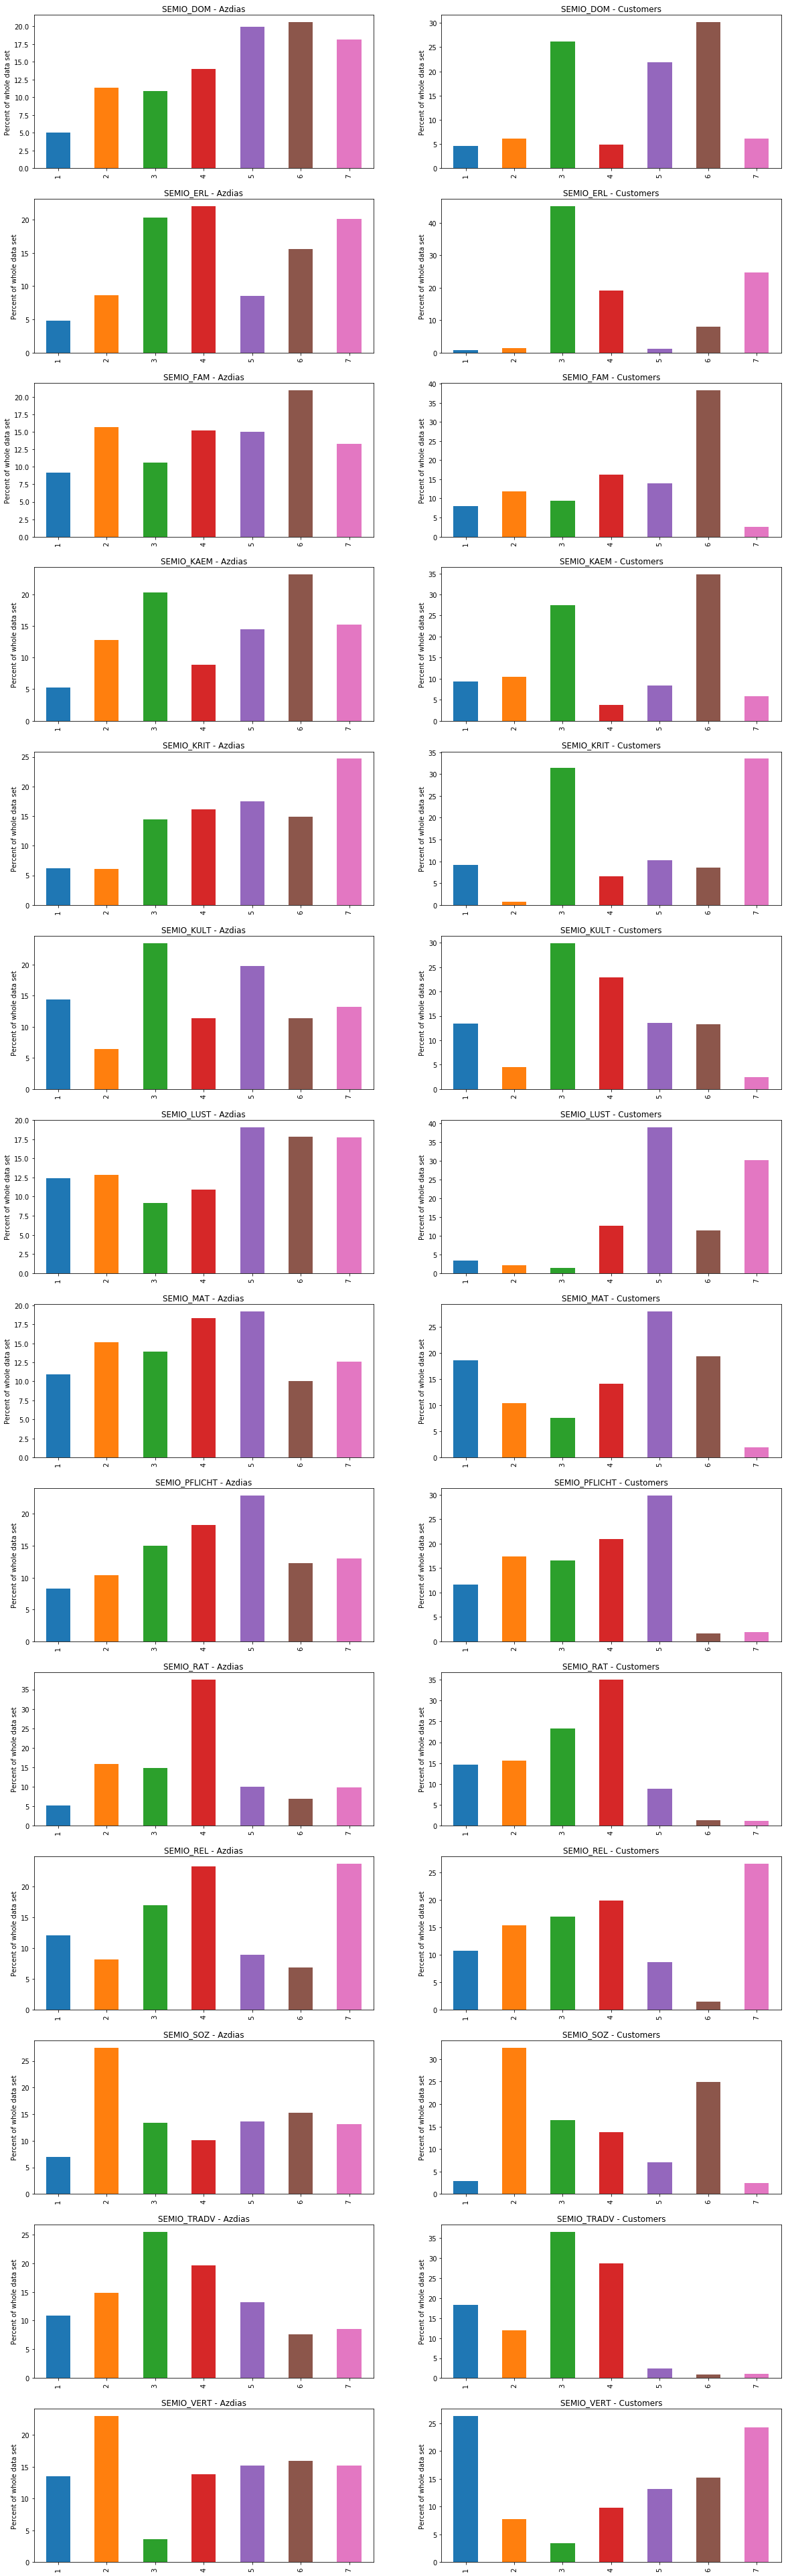

In [40]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*semio*'))

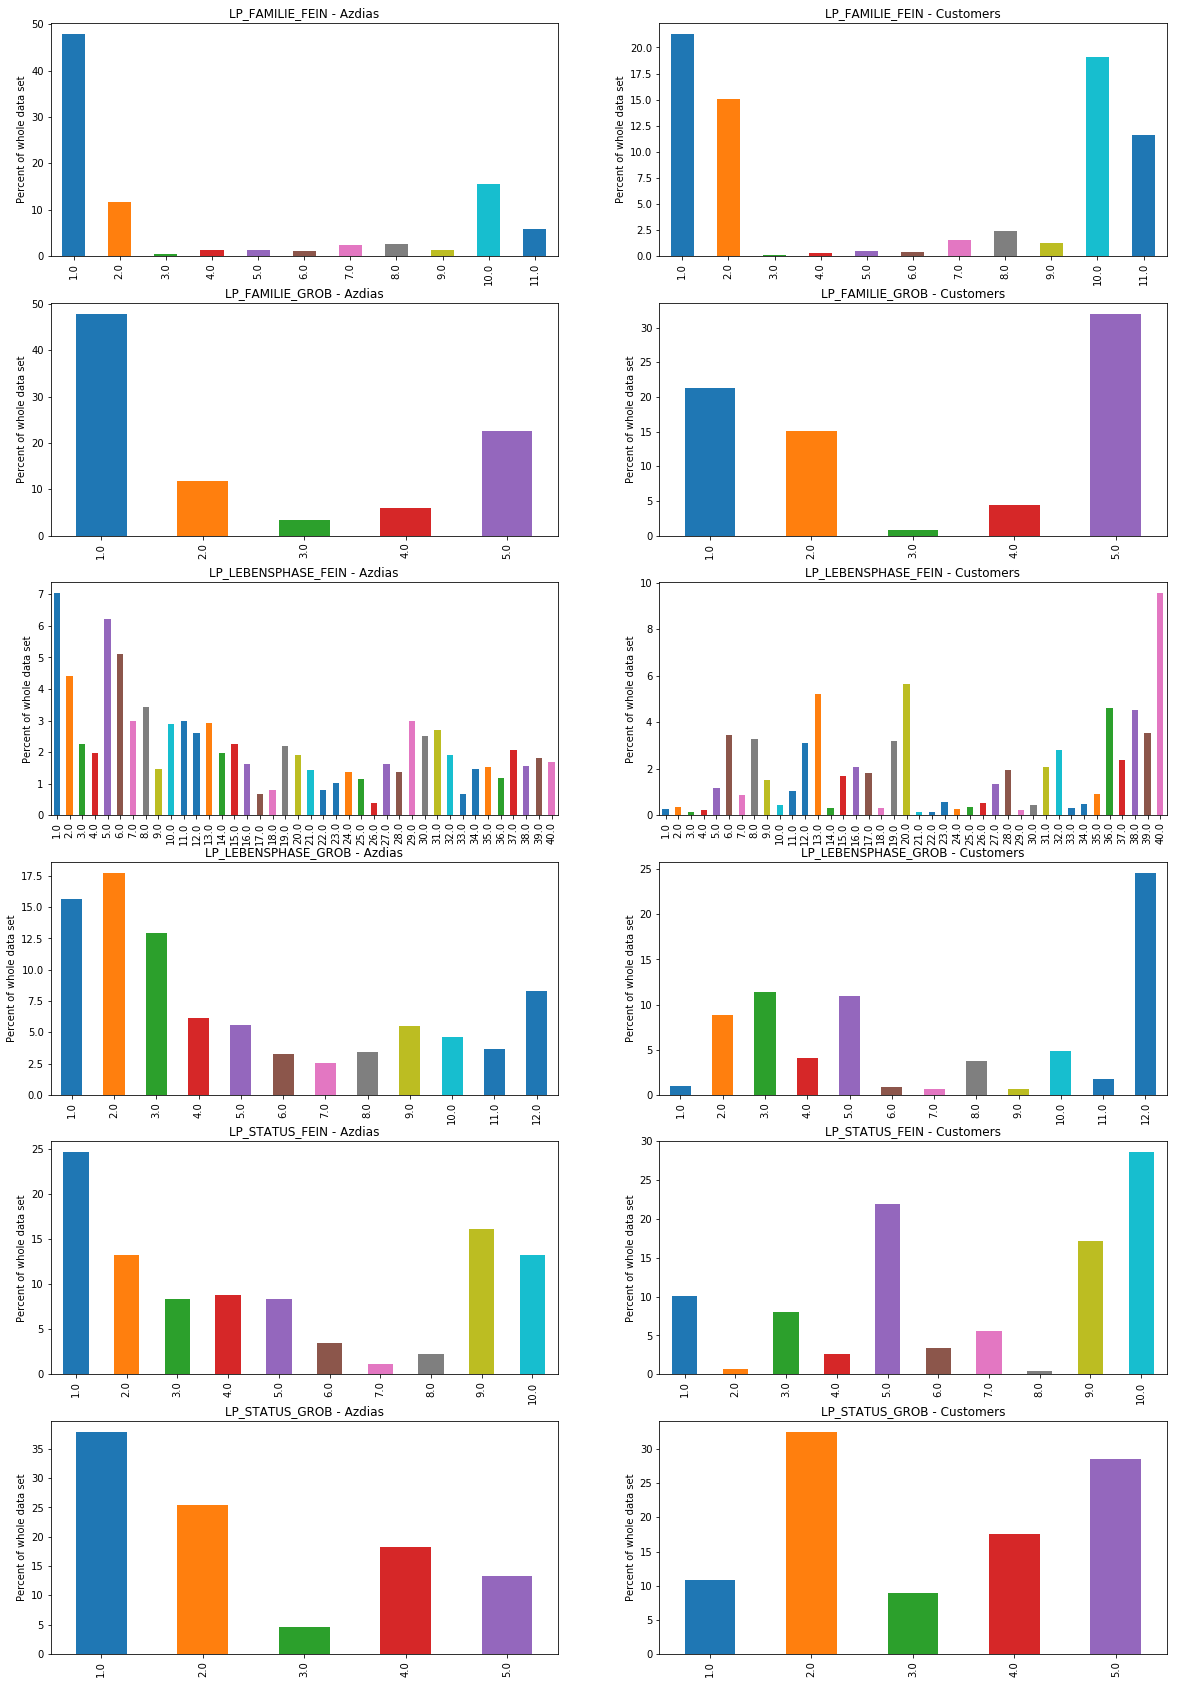

In [41]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*LP*'))

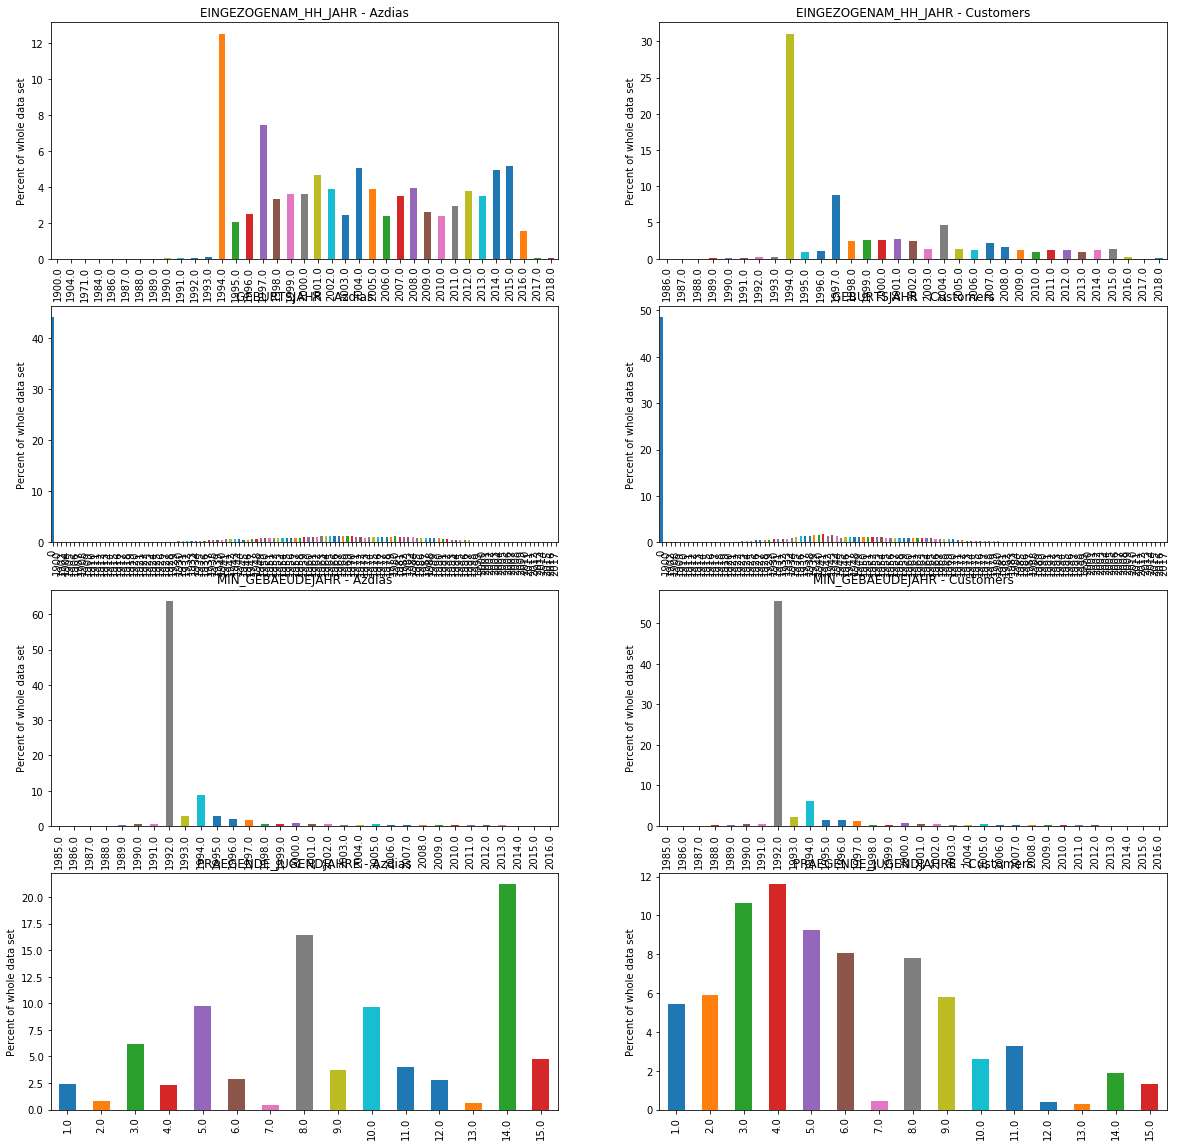

In [42]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*jahr*']))

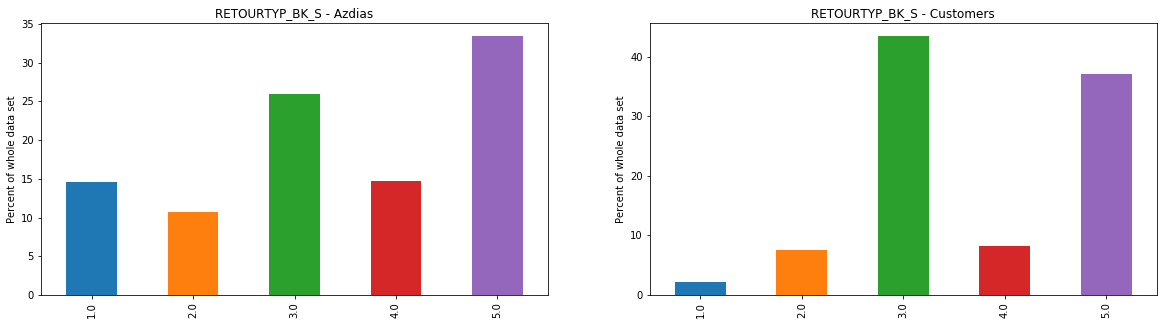

In [43]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*retour*'))

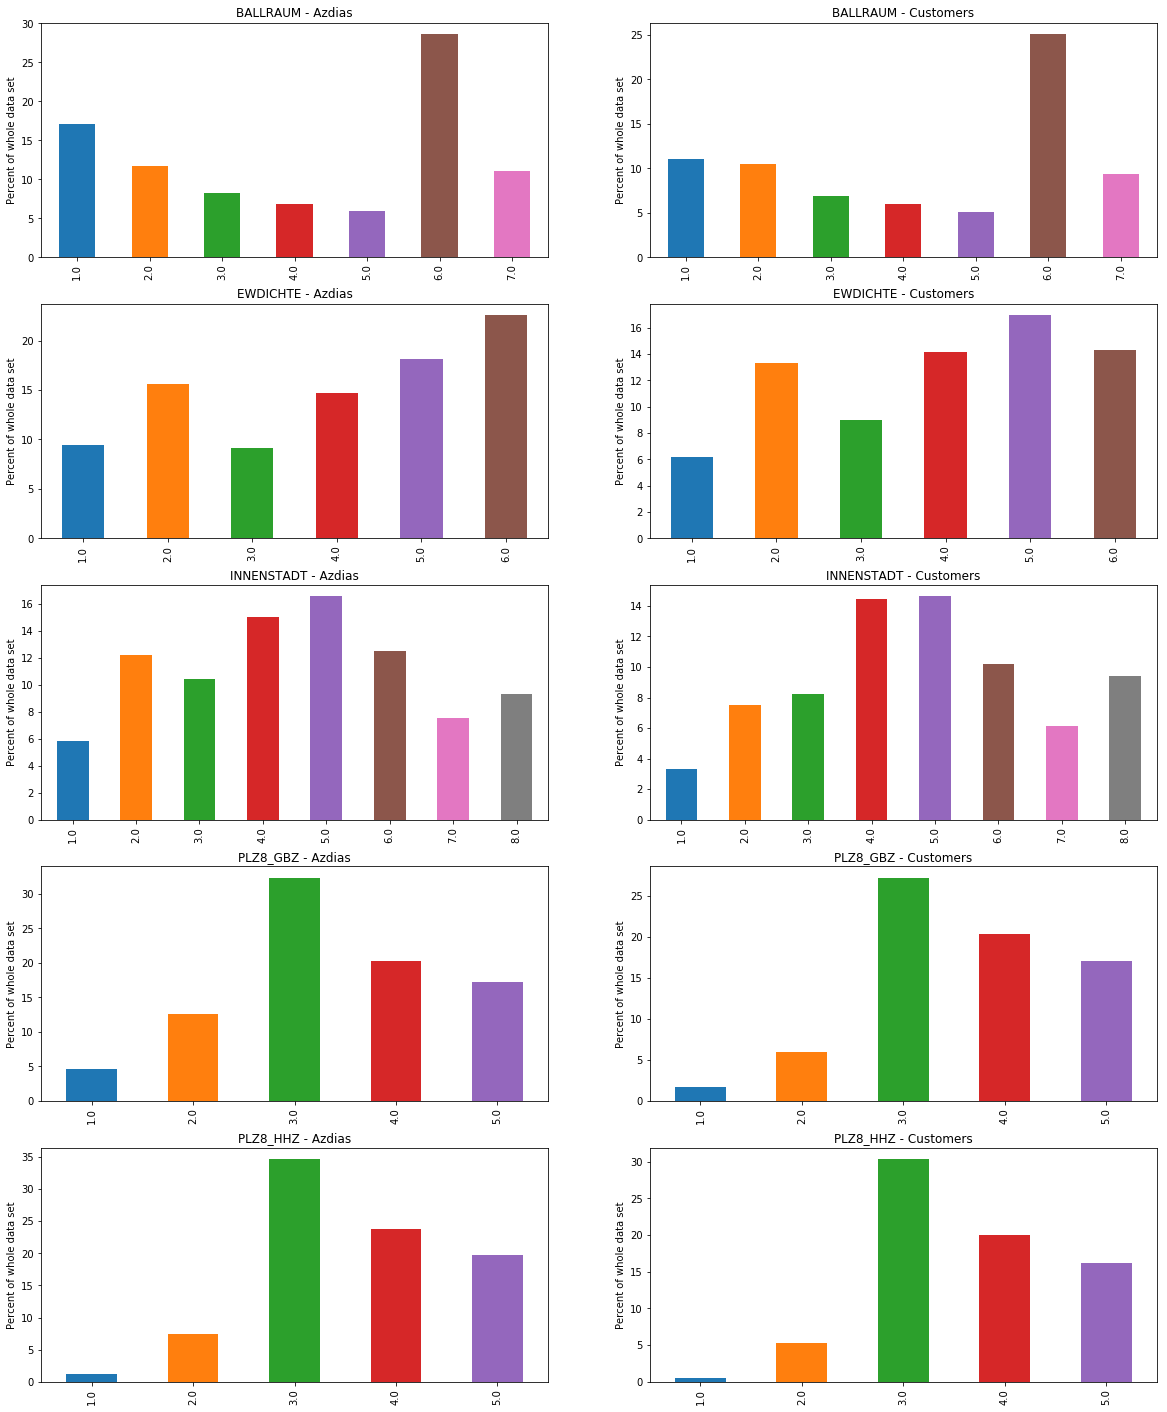

In [44]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*ballraum*', '*ewdichte*', '*innenstadt*', '*PLZ8_HHZ*', '*PLZ8_GBZ*']))

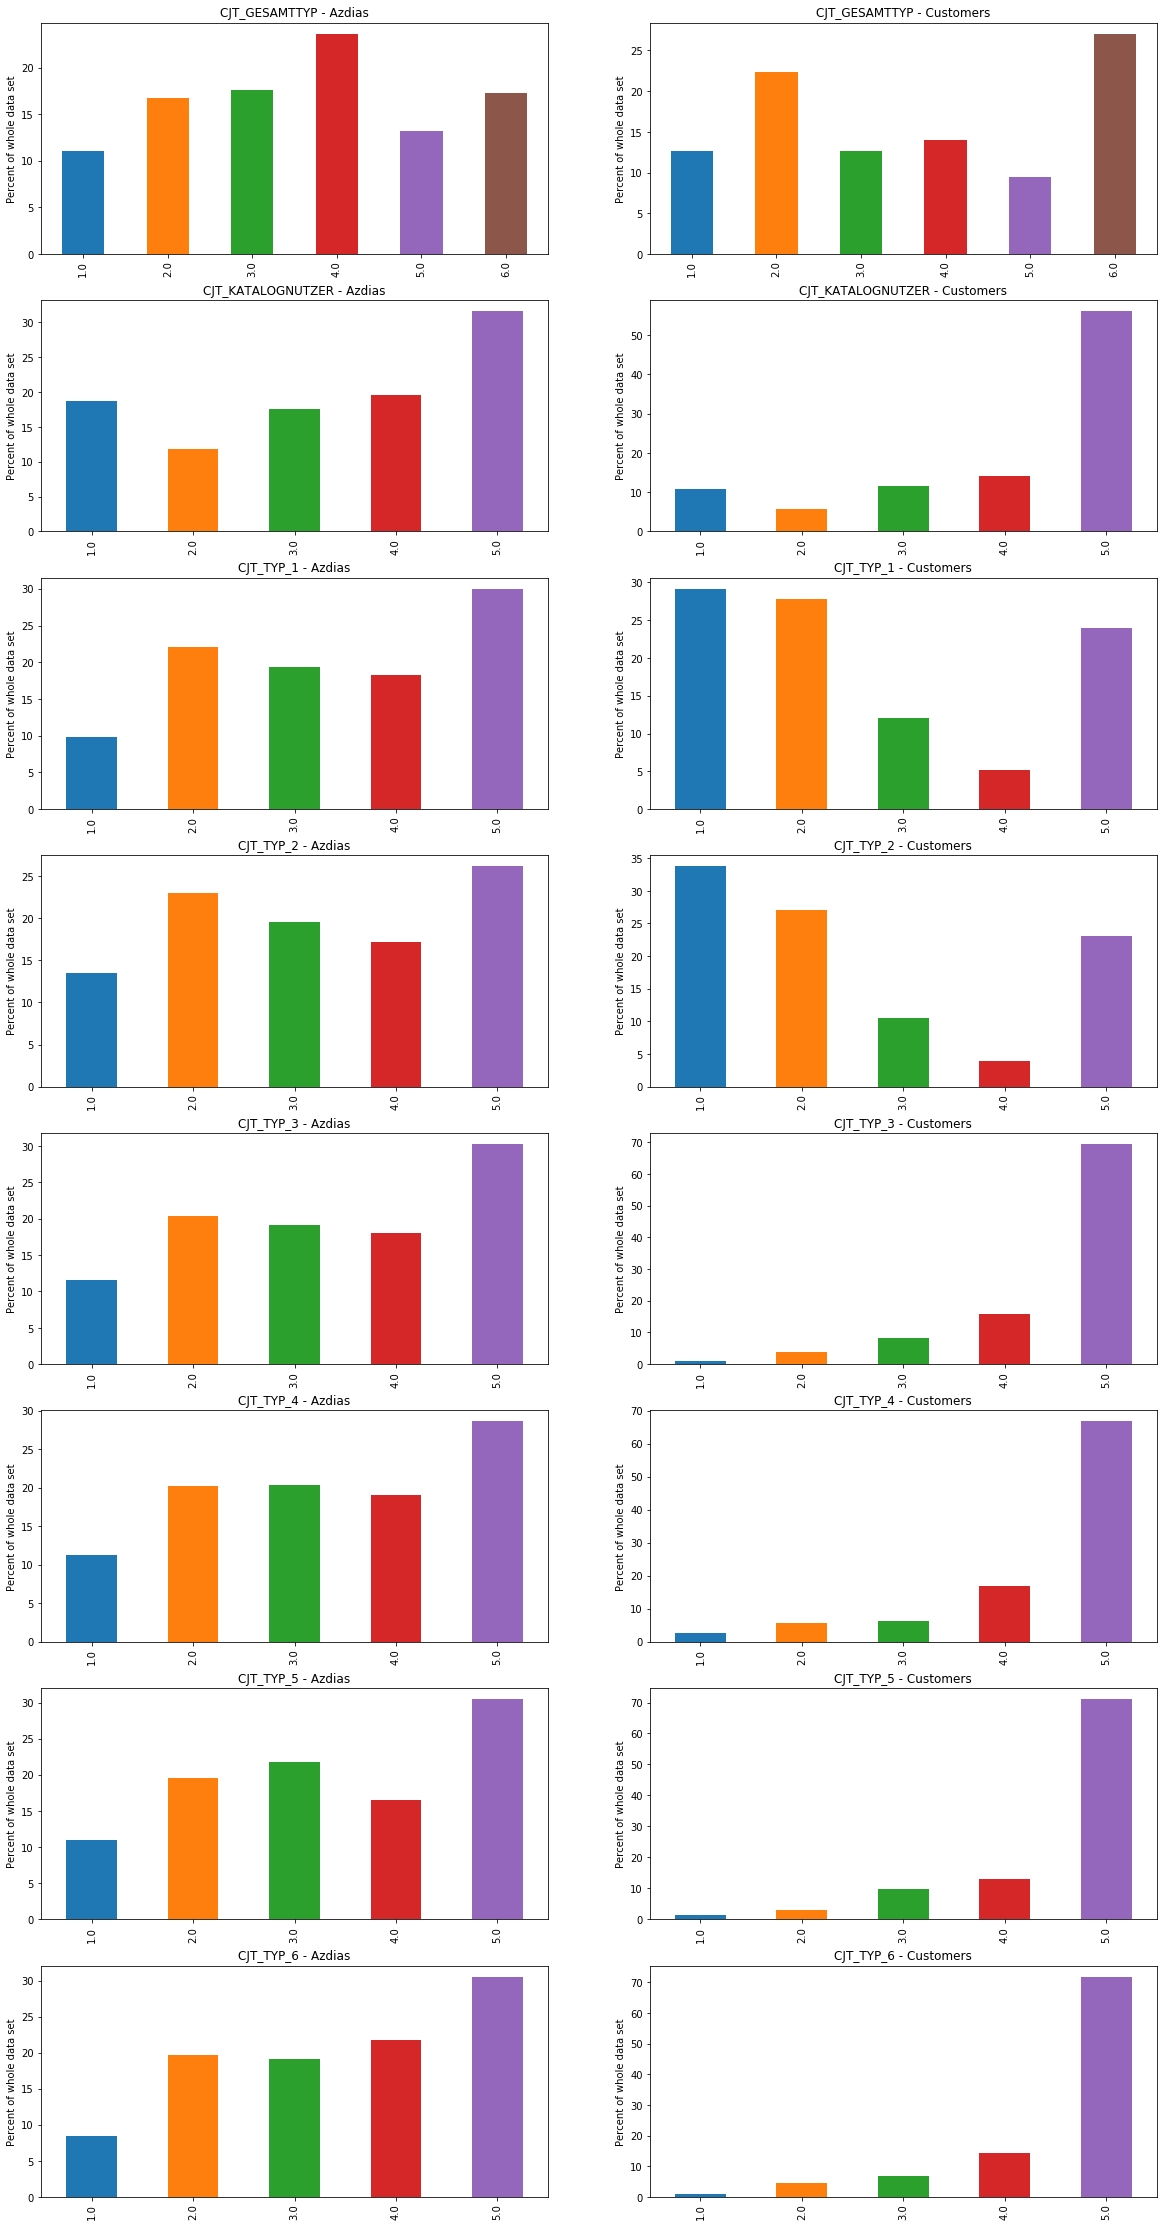

In [45]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*cjt*']))

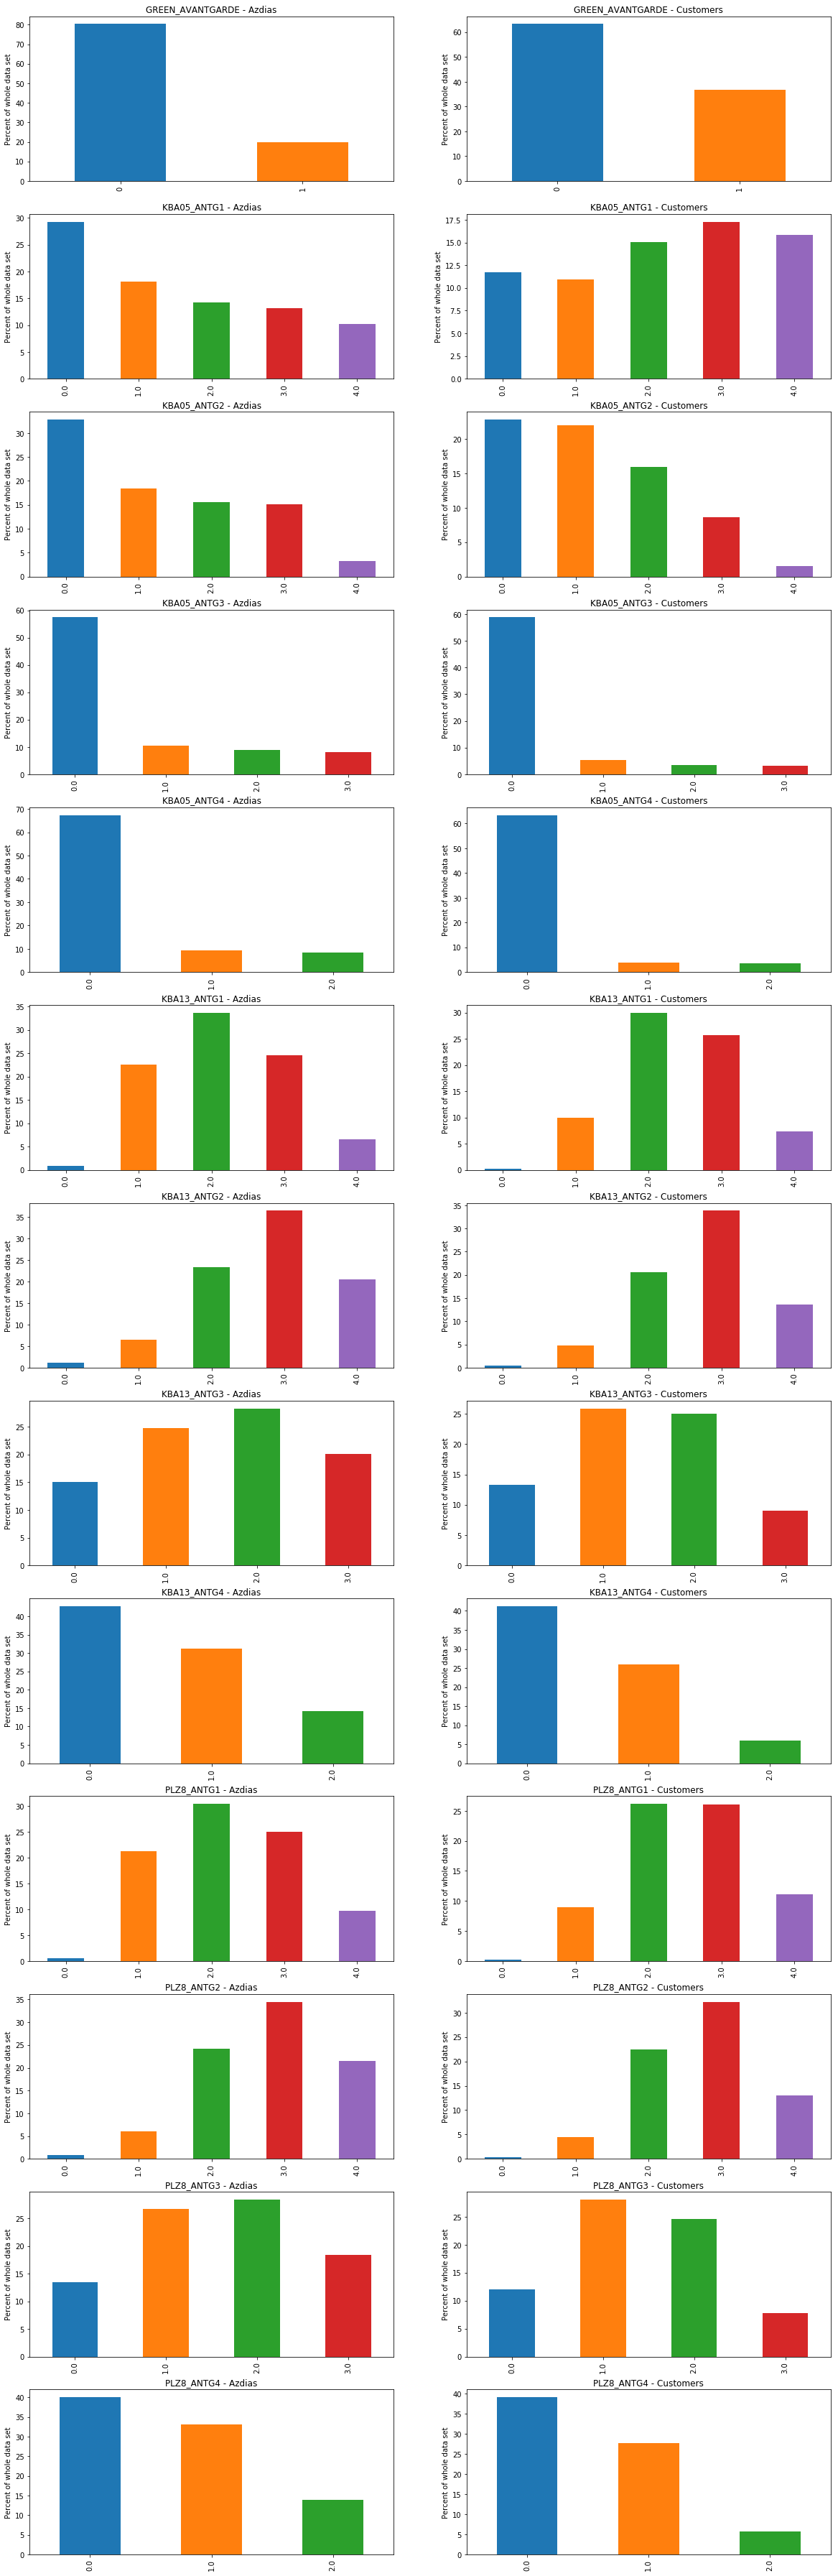

In [46]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*antg*']))

So there are some values for given eatures in azdias that do not occurr in the customer data set. But I will keep those rows so that the model is trained on all values given.

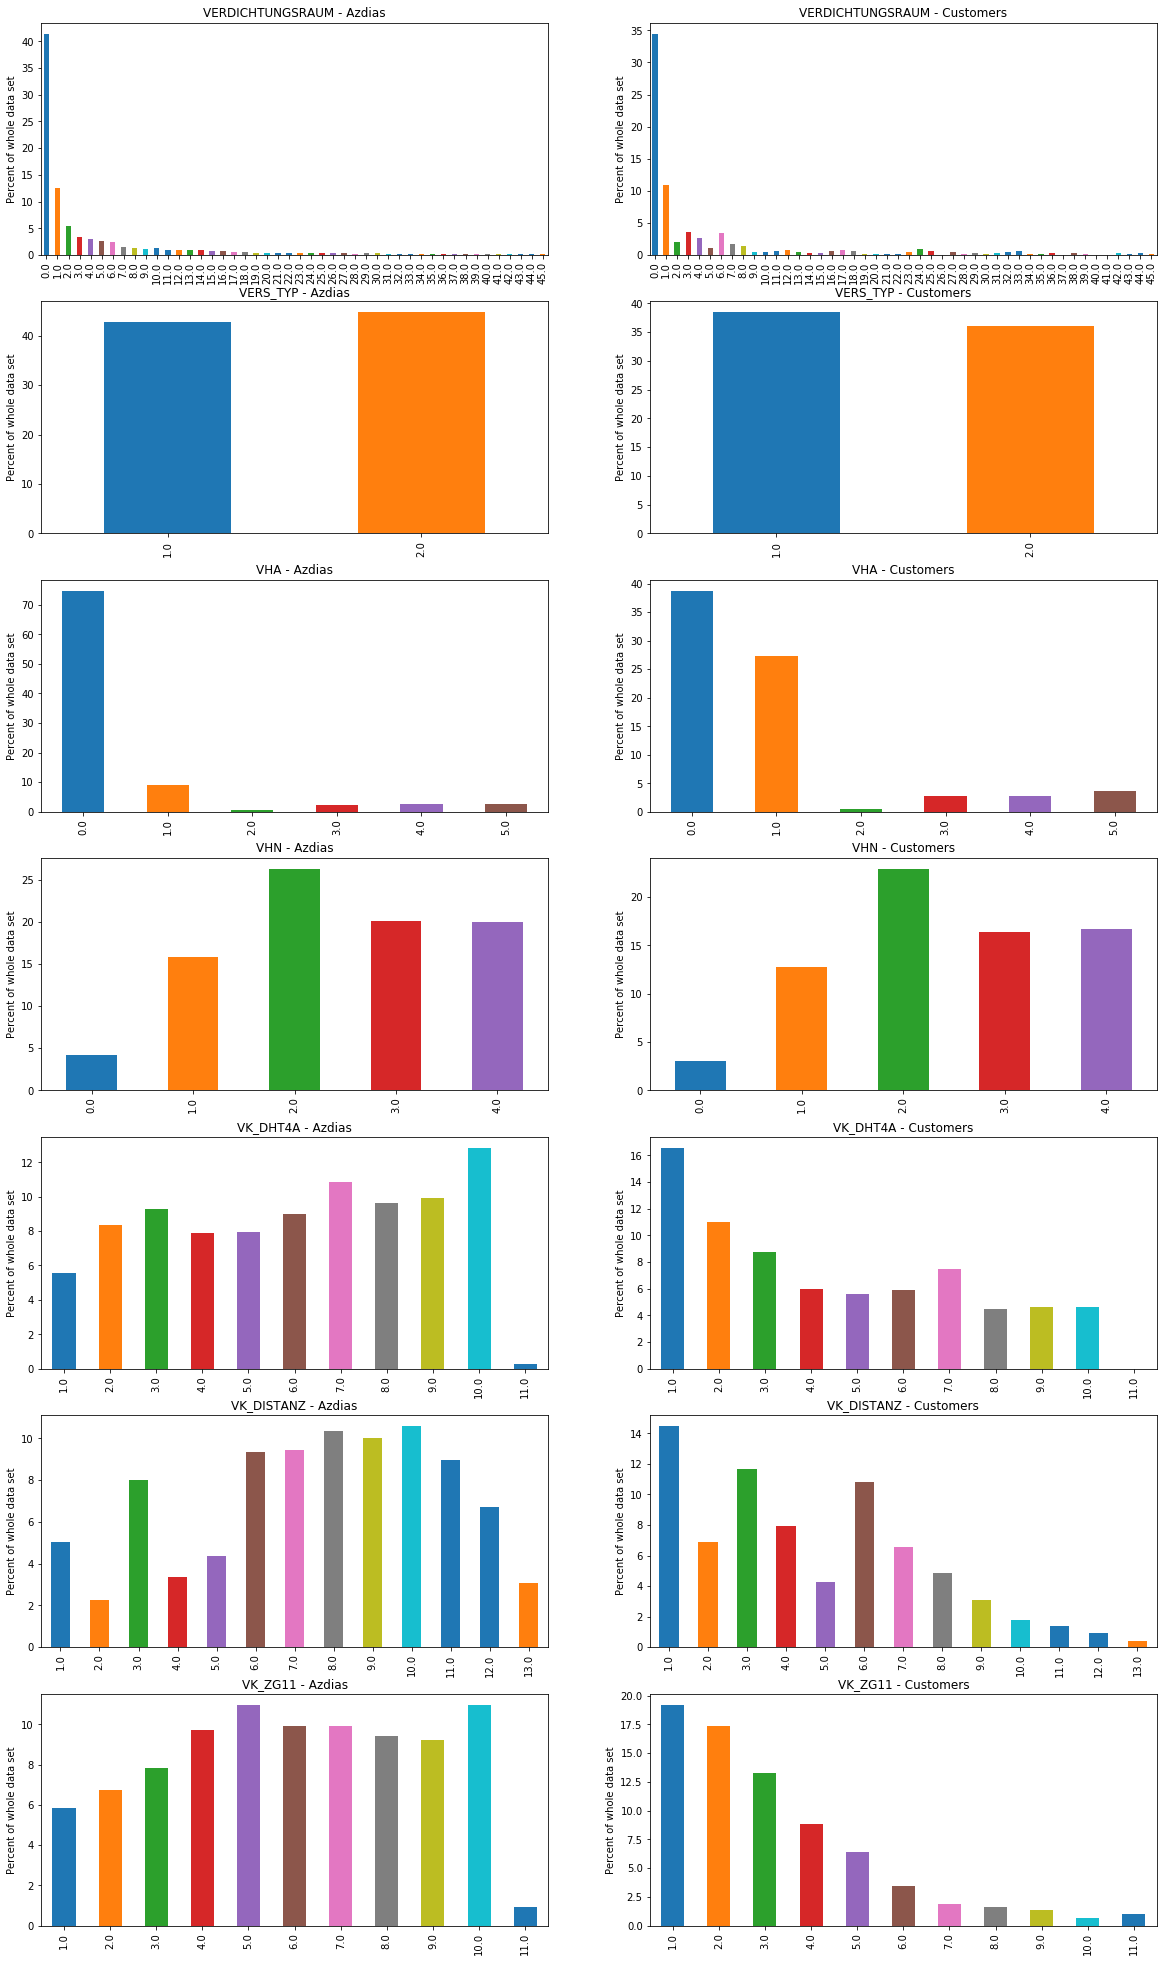

In [47]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['v*']))

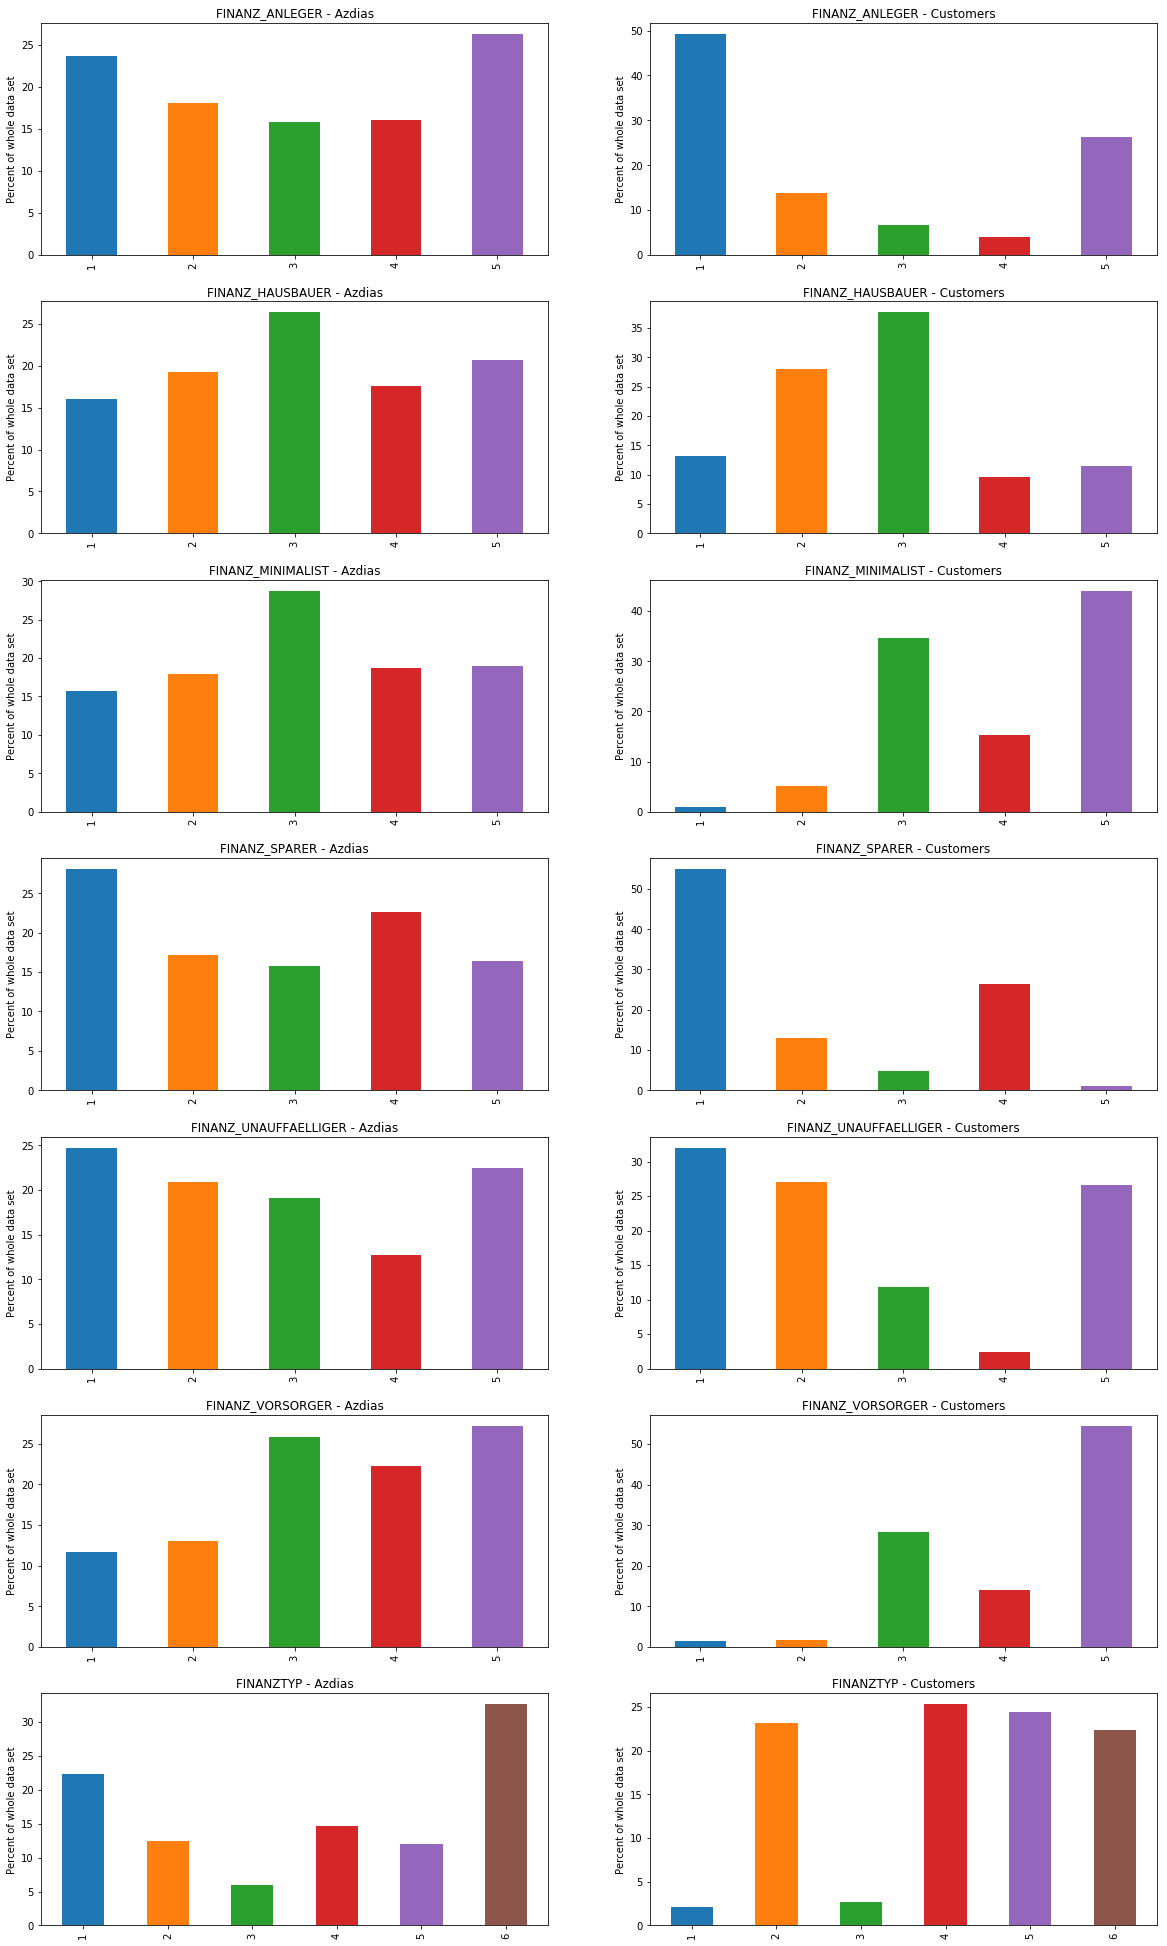

In [48]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*finanz*'))

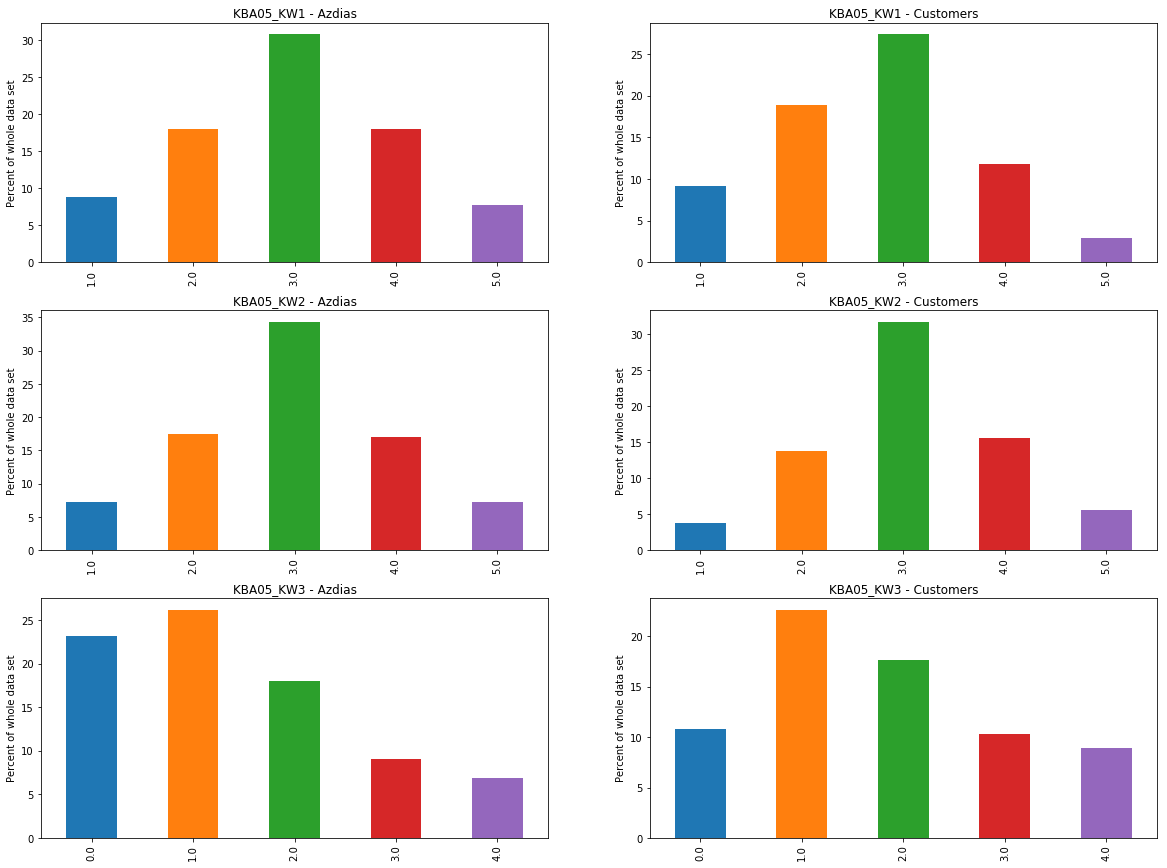

In [49]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*kba05*kw*'))

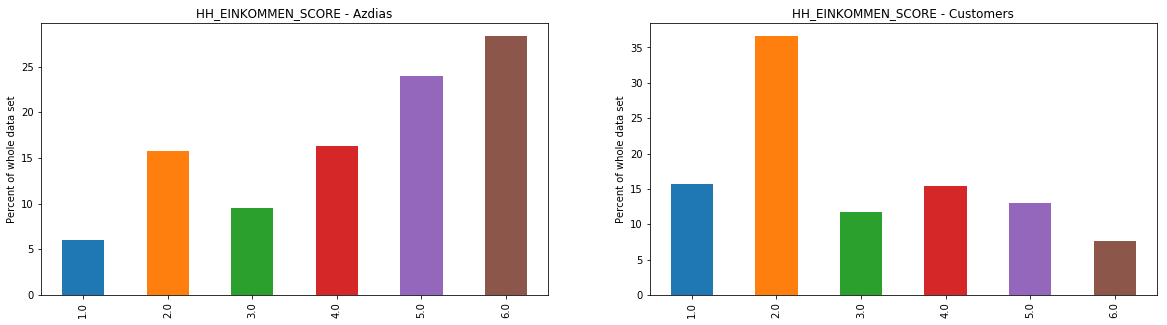

In [50]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*einkomm*']))

### Drop rows and columns

I try to identiy more outliners to clean the data set.

This attemp tries to find columns whose unique values show gaps.

In [51]:
check =[]
for col in azRun.columns:
    if azRun[col].dtype == object or col in CleanConfig.NumericalColumns:
        continue
    vc = sorted(azRun[col].unique())
    
    last = None
    for ind in range(len(vc)):
        if np.isnan(vc[ind]):
            continue
        if last is None:
            last = vc[ind]
            continue
        
        if last + 1 != vc[ind]:
            check.append(col)
            break
        last = vc[ind]

In [52]:
dsh.PrintEncapsulate('Following features have gaps in values:\n\n{}'.format(check))

--------------------  --------------------
Following features have gaps in values:

['ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_TITEL', 'CAMEO_INTL_2015', 'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'GEBAEUDETYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'ALTERSKATEGORIE_GROB']
-------------------- - --------------------


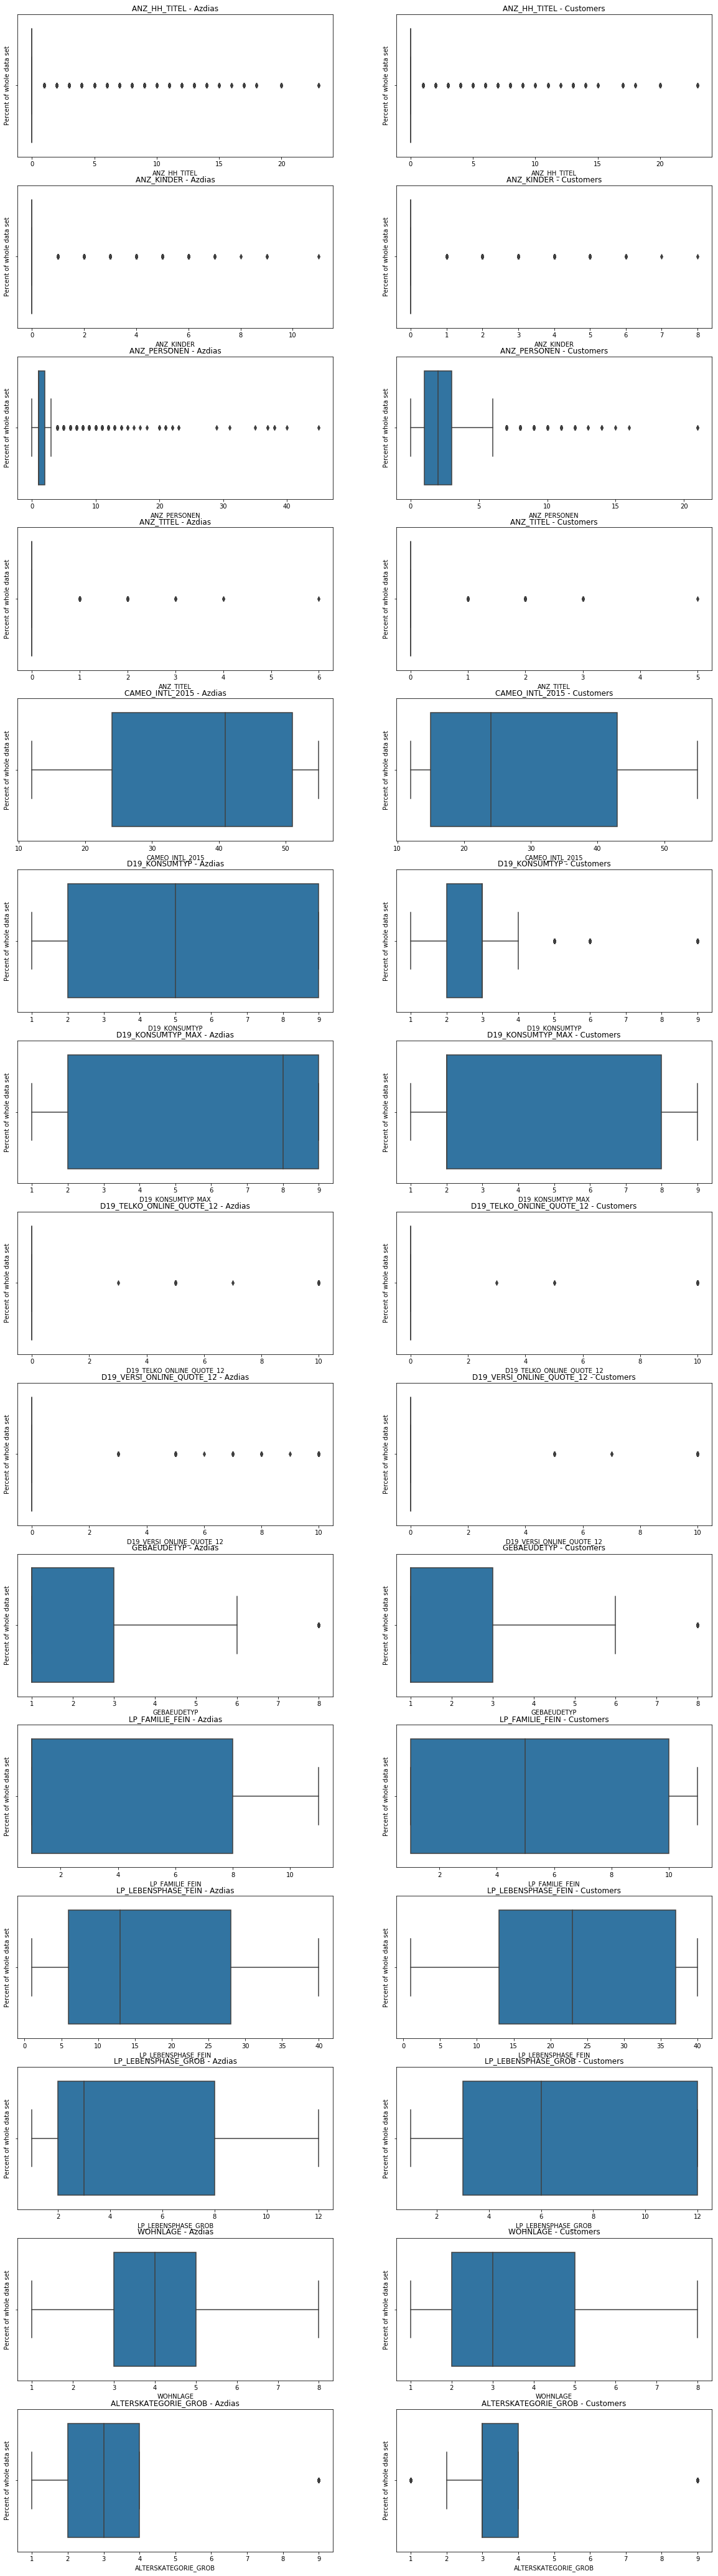

In [53]:
PlotCompareDist(azRun, cusRun, columns = check)

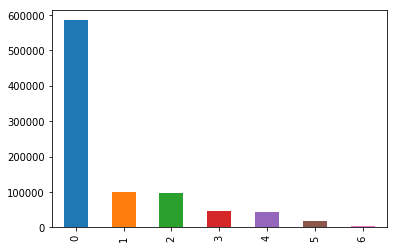

In [54]:
azdias['D19_GESAMT_ANZ_12'].value_counts().plot(kind=  'bar')

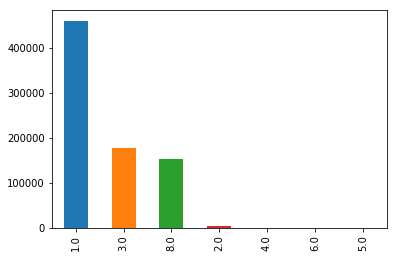

In [55]:
azdias['GEBAEUDETYP'].value_counts().plot(kind=  'bar')

In [56]:
def CalcMeanOutlinerRows(df):
    '''
    Calc mean of missing values in each row
    '''
    return df.copy(deep = True).isnull().sum(axis = 1) / df.shape[1]


def SelectOutlinerRows(dfInp):
    '''
    Select rows by: dfInput[CalcMeanOutlinerRows(dfInput) > CleanConfig.RowsToTropByMisNan]
    '''
    df = dfInp.copy(deep = True)
    return df[CalcMeanOutlinerRows(df) > CleanConfig.RowsToTropByMisNan]

def DropOutlinerRows(dfInp):
    '''
    Drop rows by: dfInput[CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan]
    '''
    df = dfInp.copy(deep = True)
    return df[CalcMeanOutlinerRows(df) <= CleanConfig.RowsToTropByMisNan]

def DropDuplicates(dfInp):
    '''
    Drop duplicates
    '''
    df = dfInp.copy(deep = True)
    bef = df.shape[0]
    dftmp = df.drop_duplicates()
    dsh.PrintLine('{} duplicate rows removed'.format(bef - df.shape[0]))
    return dftmp

def PrepDropRowsAndColumnsByNAN(dfInp, testData = False):
    '''
    Remove rows by: CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan 
                    ALTER_HH in [1, .., CleanConfig.RemoveRowsByAlterHHLimit]
    
    '''
    df = dfInp.copy(deep = True)
    
    df = dsh.RemoveColumnsByWildcard(df, CleanConfig.DropColumns)
    
    if not testData:
        df = DropOutlinerRows(df)
        dsh.PrintLine('{} rows removed '.format(dfInp.shape[0] - df.shape[0], CleanConfig.RowsToTropByMisNan))
    
        df = DropDuplicates(df)
    
    return df

In [57]:
dsh.AnalyzeNanColumns(azdias)

-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 93, 25.41%
LNR, type: int64                         0.0
AGER_TYP, type: int64                    0.0
D19_BANKEN_ANZ_12, type: int64           0.0
D19_BANKEN_ANZ_24, type: int64           0.0
D19_BANKEN_DATUM, type: int64            0.0
D19_BANKEN_DIREKT, type: int64           0.0
D19_BANKEN_GROSS, type: int64            0.0
D19_BANKEN_LOKAL, type: int64            0.0
D19_BANKEN_OFFLINE_DATUM, type: int64    0.0
D19_BANKEN_ONLINE_DATUM, type: int64     0.0
D19_BANKEN_REST, type: int64             0.0
D19_BEKLEIDUNG_GEH, type: int64          0.0
D19_BEKLEIDUNG_REST, type: int64         0.0
D19_BILDUNG, type: int64                 0.0
D19_BIO_OEKO, type: int64                0.0
D19_BUCH_CD, type: int64                 0.0
D19_DIGIT_SERV, type: int64              0.0
D19_DROGERIEARTIKEL, type: int64         0.0
D19_ENERGIE, type: int64                 0.0
D19_FREIZEIT, type: int64    

In [58]:
dsh.AnalyzeNanColumns(azRun)

-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 86, 23.50%
LNR, type: int64                         0.0
D19_BANKEN_ANZ_12, type: int64           0.0
D19_BANKEN_ANZ_24, type: int64           0.0
D19_BANKEN_DATUM, type: int64            0.0
D19_BANKEN_DIREKT, type: int64           0.0
D19_BANKEN_GROSS, type: int64            0.0
D19_BANKEN_LOKAL, type: int64            0.0
D19_BANKEN_OFFLINE_DATUM, type: int64    0.0
D19_BANKEN_ONLINE_DATUM, type: int64     0.0
D19_BANKEN_REST, type: int64             0.0
D19_BEKLEIDUNG_GEH, type: int64          0.0
D19_BEKLEIDUNG_REST, type: int64         0.0
D19_BILDUNG, type: int64                 0.0
D19_BIO_OEKO, type: int64                0.0
D19_BUCH_CD, type: int64                 0.0
D19_DIGIT_SERV, type: int64              0.0
D19_DROGERIEARTIKEL, type: int64         0.0
D19_ENERGIE, type: int64                 0.0
D19_FREIZEIT, type: int64                0.0
D19_GARTEN, type: int64      

ALTER_KIND4                    99.864792
TITEL_KZ                       99.757636
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
AGER_TYP                       76.955435
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
KBA05_BAUMAX                   53.468668
ALTER_HH                       34.813699
ALTERSKATEGORIE_FEIN           29.504130
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_LOTTO                      28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
dtype: float64


(ALTER_KIND4                    99.864792
 TITEL_KZ                       99.757636
 ALTER_KIND3                    99.307691
 ALTER_KIND2                    96.690047
 ALTER_KIND1                    90.904837
 AGER_TYP                       76.955435
 EXTSEL992                      73.399639
 KK_KUNDENTYP                   65.596749
 KBA05_BAUMAX                   53.468668
 ALTER_HH                       34.813699
 ALTERSKATEGORIE_FEIN           29.504130
 D19_TELKO_ONLINE_QUOTE_12      28.849522
 D19_VERSAND_ONLINE_QUOTE_12    28.849522
 D19_VERSI_ONLINE_QUOTE_12      28.849522
 D19_SOZIALES                   28.849522
 D19_GESAMT_ONLINE_QUOTE_12     28.849522
 D19_KONSUMTYP                  28.849522
 D19_LOTTO                      28.849522
 D19_LETZTER_KAUF_BRANCHE       28.849522
 D19_BANKEN_ONLINE_QUOTE_12     28.849522
 REGIOTYP                       17.735668
 KKK                            17.735668
 KBA05_AUTOQUOT                 16.619335
 KBA05_MOD1                     16

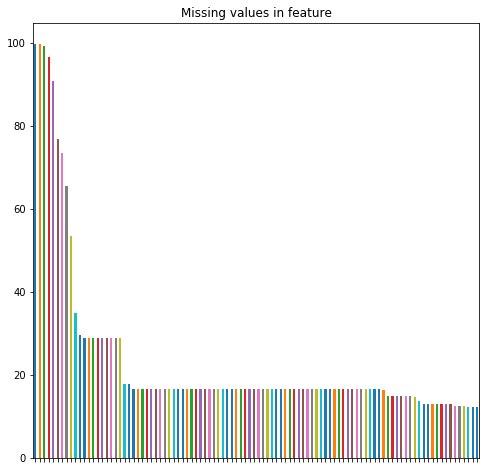

In [59]:
PlotIsNullDist(azRun, axis = 0)

          0
7    133185
8    124491
6     90658
9     72226
264   45580
10    42491
19    40197
5     35739
20    32775
17    28922
18    26323
11    24765
259   16494
16    12345
258   10577
12     9250
13     7934
14     7411
15     5610
4      4989
28     4928
21     4707
22     4555
74     4275
23     3880
73     3663
71     3643
29     3613
72     3529
26     3319
..      ...
105       7
157       7
155       6
109       5
110       5
156       5
252       5
181       4
113       3
159       3
255       3
166       3
254       3
263       3
184       2
183       2
60        2
58        1
120       1
116       1
114       1
182       1
253       1
180       1
164       1
256       1
162       1
161       1
160       1
158       1

[233 rows x 1 columns]


(          0
 7    133185
 8    124491
 6     90658
 9     72226
 264   45580
 10    42491
 19    40197
 5     35739
 20    32775
 17    28922
 18    26323
 11    24765
 259   16494
 16    12345
 258   10577
 12     9250
 13     7934
 14     7411
 15     5610
 4      4989
 28     4928
 21     4707
 22     4555
 74     4275
 23     3880
 73     3663
 71     3643
 29     3613
 72     3529
 26     3319
 ..      ...
 105       7
 157       7
 155       6
 109       5
 110       5
 156       5
 252       5
 181       4
 113       3
 159       3
 255       3
 166       3
 254       3
 263       3
 184       2
 183       2
 60        2
 58        1
 120       1
 116       1
 114       1
 182       1
 253       1
 180       1
 164       1
 256       1
 162       1
 161       1
 160       1
 158       1
 
 [233 rows x 1 columns],
 <matplotlib.axes._subplots.AxesSubplot at 0x1ae626e76a0>)

<Figure size 576x576 with 0 Axes>

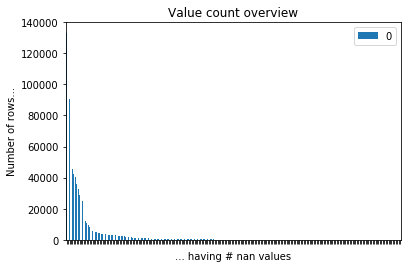

In [60]:
PlotIsNullDist(azRun, axis = 1)

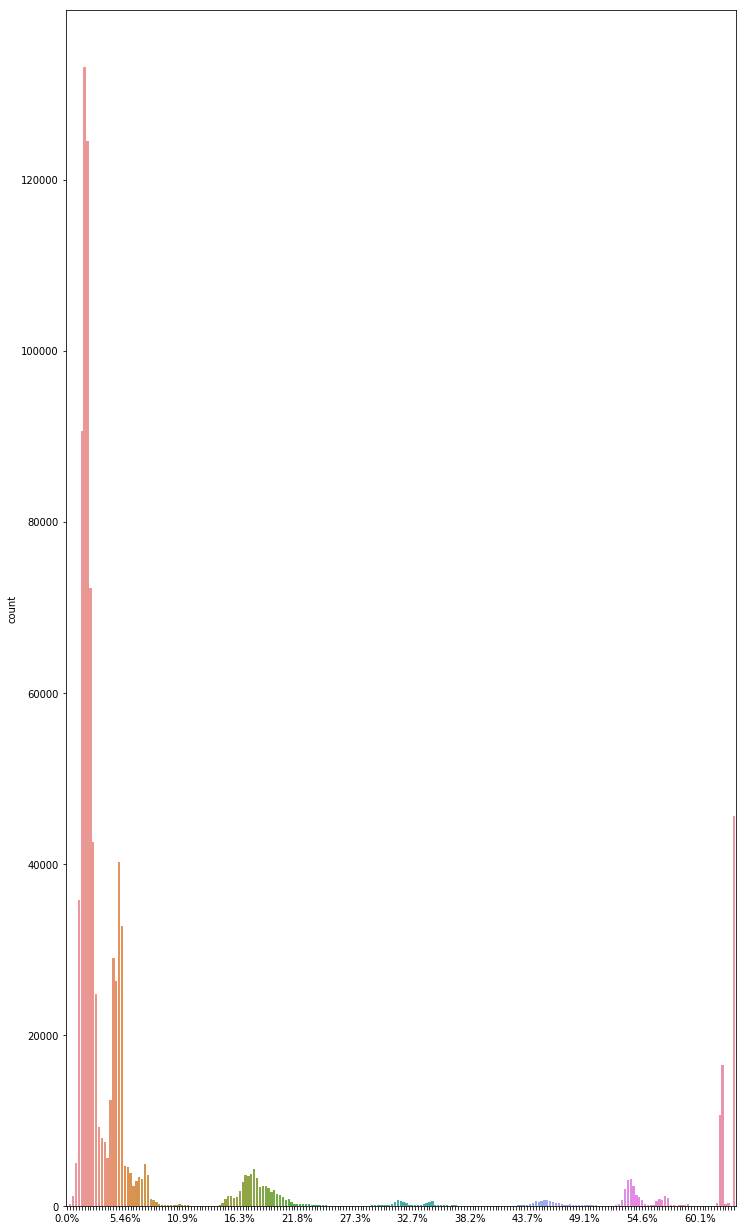

In [61]:
ser = azRun.isnull().sum(axis = 1)
plt.figure(figsize = (12, 22))
ax = sns.countplot(ser)

ticklabels = [''] * azRun.shape[1]
for ind in range(0, azRun.shape[1], 20):
    ticklabels[ind] = str((ser.index[ind] / azRun.shape[1] * 100))[:4] + '%'

_ = ax.set_xticklabels(ticklabels)

Most of the rows and columns have up to circa 22% of missing values. The outliners will be dropped. I set a large height so that the very small bars around 32% are also visible.

In [62]:
CleanConfig.ColumnsToDropByMisNan = 0.2
CleanConfig.RowsToTropByMisNan = 0.2

In [63]:
for col in azRun.columns:
    if azRun[col].isnull().mean() > CleanConfig.ColumnsToDropByMisNan:
        print(col)

AGER_TYP
ALTER_HH
ALTER_KIND1
ALTER_KIND2
ALTER_KIND3
ALTER_KIND4
ALTERSKATEGORIE_FEIN
D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_ONLINE_QUOTE_12
D19_KONSUMTYP
D19_LETZTER_KAUF_BRANCHE
D19_LOTTO
D19_SOZIALES
D19_TELKO_ONLINE_QUOTE_12
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ONLINE_QUOTE_12
EXTSEL992
KBA05_BAUMAX
KK_KUNDENTYP
TITEL_KZ


I add these features to the list of features that can be dropped.

In [64]:
for col in azRun.columns:
    if azRun[col].isnull().mean() > CleanConfig.ColumnsToDropByMisNan:
        CleanConfig.DropColumns.append(col)

Before I start dropping rows, I would like to see how they are distributed regarding certain columns.

In [65]:
azOut = SelectOutlinerRows(azRun)
azIn = DropOutlinerRows(azRun)

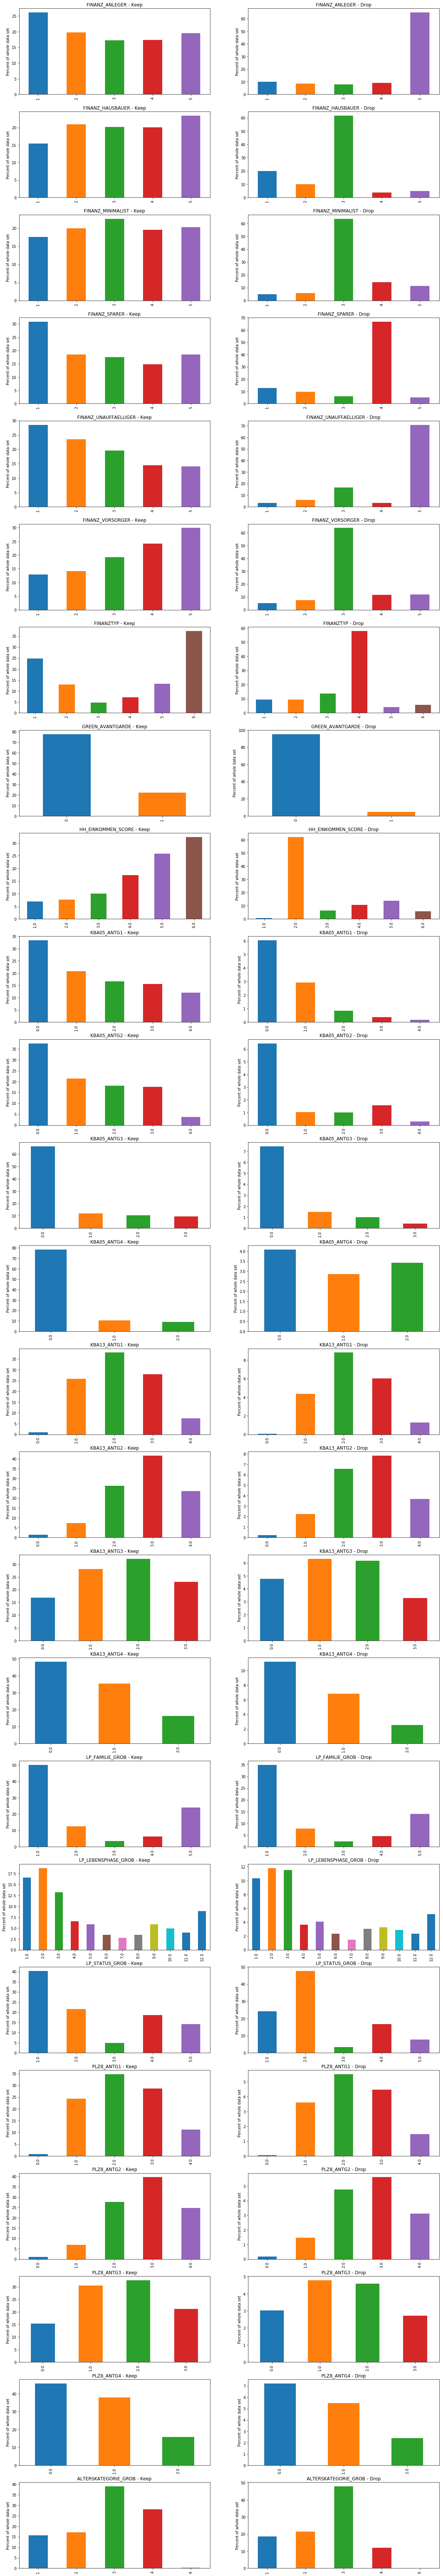

In [66]:
PlotCompare(
    azIn, azOut, 
    columns=dsh.GetMatches(azRun.columns, ['*finanz*', '*grob*', '*antg*', '*einkommen*']), 
    name1='Keep', name2 = 'Drop')

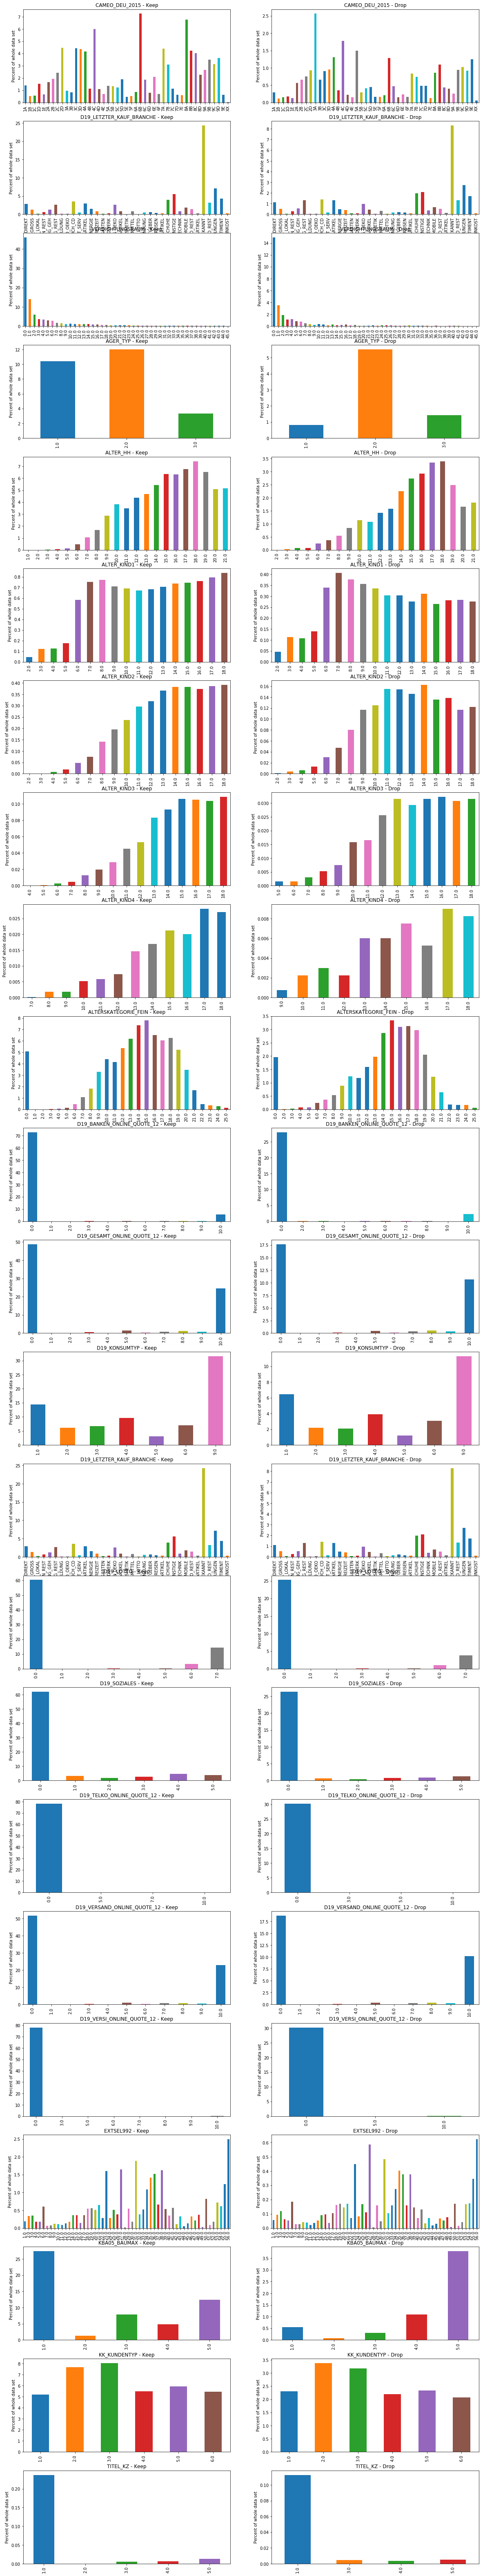

In [67]:
tmplst = [x for x in CleanConfig.DropColumns]
tmplst.remove('LNR')
tmplst.remove('EINGEFUEGT_AM')
for x in CleanConfig.NumericalColumns:
    try:
        tmplst.remove(x)
    except:
        pass
    
PlotCompare(
    azIn, azOut,
    columns = tmplst,
    name1='Keep', name2 = 'Drop')

The features Finanz* and Einkommen show up the most significant difference. The attitude to be Anleger or Sparer is very high whereas the attidude of dropped persons is average or even very low. This corresponds to the finding that kept people have a lower income than those who will be dropped.

In [68]:
del azIn, azOut

gc.collect()

163494

So most of of the columns have less that 20% of missing values. Outliners are those with a minimum of 50% of missing values and will be dropped. But before, I try to (re)engineer/update/create features to slightly reduce features and to extract new information from existing ones. Updating will (hopefully) reduce the number of nan values. 

But before dropping these rows, I look for further rows that can be dropped because of multiple accurrance of information (for example KBA_60KW, 80KW, .. is represented by KBA_0_140KW). 

KBA05_CCM describes the cylinder capacity, so the feature 'KBA05_MOTOR' describing the engine size is unnecessary.

The same for columns having appendix _GROB, _FEIN.

In [69]:
azRun[dsh.GetMatches(azRun.columns, ['*kba13*kmh*', '*kba13*kw*'], ['*anzahl*', '*1'])]

KBA13_KMH_0_140  KBA13_KMH_110  KBA13_KMH_140  KBA13_KMH_140_210  \
0                   NaN            NaN            NaN                NaN   
1                   3.0            1.0            3.0                3.0   
2                   1.0            1.0            1.0                2.0   
3                   5.0            1.0            5.0                1.0   
4                   5.0            1.0            5.0                1.0   
5                   3.0            1.0            3.0                2.0   
6                   0.0            1.0            2.0                4.0   
7                   0.0            1.0            2.0                3.0   
8                   0.0            1.0            2.0                2.0   
9                   1.0            1.0            1.0                1.0   
10                  1.0            1.0            1.0                4.0   
11                  NaN            NaN            NaN                NaN   
12                  3.0            1.0            3.0                2.0   
13                  0.0            1.0            2.0                4.0   
14                  NaN            NaN            NaN                NaN   
15                  NaN            NaN            NaN                NaN   
16                  3.0            2.0            4.0                2.0   
17                  NaN            NaN            NaN                NaN   
18                  3.0            1.0            3.0                3.0   
19                  1.0            1.0            1.0                1.0   
20                  NaN            NaN            NaN                NaN   
21                  3.0            1.0            4.0                2.0   
22                  1.0            1.0            1.0                2.0   
23                  NaN            NaN            NaN                NaN   
24                  NaN            NaN            NaN                NaN   
25                  3.0            2.0            3.0                3.0   
26                  NaN            NaN            NaN                NaN   
27                  1.0            1.0            1.0                3.0   
28                  0.0            2.0            2.0                2.0   
29                  0.0            1.0            2.0                3.0   
...                 ...            ...            ...                ...   
891191              4.0            3.0            4.0                2.0   
891192              1.0            1.0            1.0                4.0   
891193              1.0            1.0            1.0                3.0   
891194              0.0            1.0            2.0                3.0   
891195              4.0            3.0            4.0                3.0   
891196              1.0            1.0            1.0                5.0   
891197              1.0            1.0            1.0                3.0   
891198              3.0            1.0            4.0                3.0   
891199              5.0            3.0            5.0                1.0   
891200              5.0            1.0            5.0                2.0   
891201              3.0            1.0            4.0                2.0   
891202              1.0            1.0            1.0                1.0   
891203              0.0            1.0            2.0                2.0   
891204              3.0            1.0            4.0                3.0   
891205              5.0            1.0            5.0                3.0   
891206              0.0            1.0            3.0                3.0   
891207              1.0            1.0            1.0                4.0   
891208              3.0            1.0            3.0                3.0   
891209              3.0            1.0            4.0                2.0   
891210              5.0            1.0            5.0                3.0   
891211              4.0            1.0            5.0   

At first, I intended to keep features KB_CCM_X_Y but then I noticed that those features have gaps/wrong values. For example for row with index = 6 it says: KBA13_KMH_0_140 = 0 but KBA13_KMH_110 = 1 and KBA13_KMH_140 = 2. For other rows the formula is: KBA13_KMH_0_140 = MAX(KBA13_KMH_110, KBA13_KMH_140).

So I decide to keep the single features and drop the summed features because two features keep more information than the max of both :)

In [70]:
dsh.GetMatches(azdias.columns, '*max*')

['D19_KONSUMTYP_MAX',
 'KBA05_BAUMAX',
 'KBA05_MAXAH',
 'KBA05_MAXBJ',
 'KBA05_MAXHERST',
 'KBA05_MAXSEG',
 'KBA05_MAXVORB',
 'KBA13_BAUMAX',
 'PLZ8_BAUMAX']

As the word "max" says, the max of the relevant features is taken and put in these columns. And using the same argument above: KBA05_MAXHERST describes the most common manufacturer, there are again wrong values. For example row index 3: KBA05_MAXHERST = 5 but KBA05_HERST5 = 3 and KBA05_HERST1 = 4.

KBA05_MAXBJ is described by KBA05_ZUL1-4
KBA05_MAXHERST is described by KBA05_HERST1-5
and so on...

So I decide to drop the max rows because I assume the same errors in the other columns.

In [71]:
azRun[dsh.GetMatches(azRun.columns, '*herst*', '*krsher*')][:20]

KBA05_HERST1  KBA05_HERST2  KBA05_HERST3  KBA05_HERST4  KBA05_HERST5  \
0            NaN           NaN           NaN           NaN           NaN   
1            5.0           5.0           2.0           2.0           0.0   
2            2.0           2.0           3.0           2.0           5.0   
3            4.0           3.0           3.0           2.0           3.0   
4            2.0           2.0           4.0           1.0           4.0   
5            2.0           3.0           1.0           3.0           4.0   
6            2.0           3.0           3.0           3.0           3.0   
7            2.0           2.0           4.0           3.0           4.0   
8            3.0           3.0           3.0           4.0           3.0   
9            5.0           2.0           2.0           3.0           2.0   
10           0.0           5.0           3.0           0.0           3.0   
11           NaN           NaN           NaN           NaN           NaN   
12           NaN           NaN           NaN           NaN           NaN   
13           NaN           NaN           NaN           NaN           NaN   
14           NaN           NaN           NaN           NaN           NaN   
15           0.0           4.0           4.0           0.0           4.0   
16           2.0           3.0           4.0           3.0           3.0   
17           NaN           NaN           NaN           NaN           NaN   
18           2.0           4.0           3.0           3.0           2.0   
19           4.0           4.0           0.0           3.0           2.0   

    KBA05_HERSTTEMP  KBA05_MAXHERST  KBA13_HERST_ASIEN  KBA13_HERST_AUDI_VW  \
0               NaN             NaN                NaN                  NaN   
1               4.0             2.0                1.0                  4.0   
2               4.0             5.0                3.0                  2.0   
3               3.0             3.0                3.0                  4.0   
4               3.0             3.0                3.0                  4.0   
5               4.0             2.0                4.0                  3.0   
6               1.0             2.0                3.0                  3.0   
7               3.0             3.0                3.0                  2.0   
8               1.0             2.0                2.0                  3.0   
9               2.0             1.0                2.0                  3.0   
10              2.0             2.0                4.0                  2.0   
11              NaN             NaN                NaN                  NaN   
12              5.0             NaN                2.0                  3.0   
13              5.0             NaN                4.0                  3.0   
14              NaN             NaN                NaN                  NaN   
15              2.0             2.0                NaN                  NaN   
16              3.0             3.0                2.0                  3.0   
17              NaN             NaN                NaN                  NaN   
18              2.0             2.0                3.0                  4.0   
19              1.0             2.0                1.0                  4.0   

    KBA13_HERST_BMW_BENZ  KBA13_HERST_EUROPA  KBA13_HERST_FORD_OPEL  \
0                    NaN                 NaN                    NaN   
1                    4.0                 4.0                    2.0   
2                    4.0                 3.0                    3.0   
3                    3.0                 2.0                    2.0   
4                    3.0                 4.0                    3.0   
5                    3.0                 3.0                    3.0   
6                    3.0                 5.0                    3.0   
7                    4.0                 3.0                    3.0   
8                    5.0                 3.0                    2.0   
9                    5.0             

In [72]:
azRun[dsh.GetMatches(azRun.columns, '*bj*')][:20]

KBA05_MAXBJ  KBA13_BJ_1999  KBA13_BJ_2000  KBA13_BJ_2004  KBA13_BJ_2006  \
0           NaN            NaN            NaN            NaN            NaN   
1           1.0            3.0            3.0            3.0            3.0   
2           4.0            2.0            2.0            4.0            5.0   
3           4.0            2.0            2.0            3.0            3.0   
4           2.0            3.0            3.0            3.0            2.0   
5           4.0            2.0            2.0            3.0            3.0   
6           2.0            3.0            2.0            4.0            4.0   
7           4.0            4.0            3.0            3.0            3.0   
8           2.0            3.0            3.0            2.0            2.0   
9           4.0            1.0            1.0            3.0            4.0   
10          1.0            3.0            4.0            3.0            2.0   
11          NaN            NaN            NaN            NaN            NaN   
12          NaN            3.0            3.0            2.0            2.0   
13          NaN            3.0            4.0            3.0            2.0   
14          NaN            NaN            NaN            NaN            NaN   
15          1.0            NaN            NaN            NaN            NaN   
16          4.0            3.0            3.0            3.0            3.0   
17          NaN            NaN            NaN            NaN            NaN   
18          2.0            2.0            1.0            3.0            4.0   
19          2.0            2.0            2.0            3.0            3.0   

    KBA13_BJ_2008  KBA13_BJ_2009  
0             NaN            NaN  
1             3.0            2.0  
2             3.0            1.0  
3             4.0            3.0  
4             0.0            5.0  
5             4.0            3.0  
6             2.0            3.0  
7             3.0            3.0  
8             5.0            3.0  
9             5.0            5.0  
10            3.0            3.0  
11            NaN            NaN  
12            4.0            5.0  
13            1.0            5.0  
14            NaN            NaN  
15            NaN            NaN  
16            4.0            0.0  
17            NaN            NaN  
18            3.0            4.0  
19            3.0            5.0

In [73]:
dsh.GetMatches(azRun.columns, ['kb*ccm_*_*', 'kb*_*2?1'])

['KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_KMH_211', 'KBA13_KMH_251']

In [74]:
azRun[dsh.GetMatches(azRun.columns, ['KbA13_*alter*'])][:20]

KBA13_ALTERHALTER_30  KBA13_ALTERHALTER_45  KBA13_ALTERHALTER_60  \
0                    NaN                   NaN                   NaN   
1                    3.0                   2.0                   3.0   
2                    3.0                   2.0                   3.0   
3                    2.0                   3.0                   5.0   
4                    3.0                   3.0                   3.0   
5                    2.0                   4.0                   3.0   
6                    3.0                   3.0                   3.0   
7                    2.0                   3.0                   2.0   
8                    1.0                   1.0                   3.0   
9                    1.0                   1.0                   2.0   
10                   3.0                   1.0                   2.0   
11                   NaN                   NaN                   NaN   
12                   3.0                   3.0                   2.0   
13                   3.0                   2.0                   3.0   
14                   NaN                   NaN                   NaN   
15                   NaN                   NaN                   NaN   
16                   4.0                   5.0                   4.0   
17                   NaN                   NaN                   NaN   
18                   3.0                   3.0                   3.0   
19                   3.0                   3.0                   2.0   

    KBA13_ALTERHALTER_61  KBA13_HALTER_20  KBA13_HALTER_25  KBA13_HALTER_30  \
0                    NaN              NaN              NaN              NaN   
1                    4.0              3.0              3.0              3.0   
2                    3.0              3.0              3.0              2.0   
3                    2.0              2.0              2.0              2.0   
4                    3.0              3.0              3.0              3.0   
5                    3.0              3.0              2.0              3.0   
6                    3.0              3.0              3.0              3.0   
7                    4.0              2.0              2.0              3.0   
8                    5.0              2.0              1.0              2.0   
9                    5.0              2.0              2.0              1.0   
10                   5.0              4.0              3.0              2.0   
11                   NaN              NaN              NaN              NaN   
12                   4.0              2.0              3.0              3.0   
13                   3.0              4.0              4.0              3.0   
14                   NaN              NaN              NaN              NaN   
15                   NaN              NaN              NaN              NaN   
16                   1.0              5.0              4.0              4.0   
17                   NaN              NaN              NaN              NaN   
18                   3.0              5.0              3.0              3.0   
19                   4.0              3.0              3.0              4.0   

    KBA13_HALTER_35  KBA13_HALTER_40  KBA13_HALTER_45  KBA13_HALTER_50  \
0               NaN              NaN              NaN              NaN   
1               3.0              3.0              2.0              2.0   
2               2.0              2.0              3.0              3.0   
3               3.0              3.0              3.0              5.0   
4               3.0              3.0              3.0              4.0   
5               3.0              3.0              5.0              3.0   
6               3.0              3.0              3.0              3.0   
7               3.0              3.0              3.0              3.0   
8               1.0              1.0              2.0              2.0   
9               1.0              2.0              2.0              2.0   
10              1

The formula for KBA_HALTERALTER_30 is min(KBA_HALTER_20/25/30), dito for the other features. So I will drop these.

In [75]:
match = dsh.GetMatches(azRun.columns, ['KB*seg*'])
match

['KBA05_MAXSEG',
 'KBA05_SEG1',
 'KBA05_SEG10',
 'KBA05_SEG2',
 'KBA05_SEG3',
 'KBA05_SEG4',
 'KBA05_SEG5',
 'KBA05_SEG6',
 'KBA05_SEG7',
 'KBA05_SEG8',
 'KBA05_SEG9',
 'KBA13_KRSSEG_KLEIN',
 'KBA13_KRSSEG_OBER',
 'KBA13_KRSSEG_VAN',
 'KBA13_SEG_GELAENDEWAGEN',
 'KBA13_SEG_GROSSRAUMVANS',
 'KBA13_SEG_KLEINST',
 'KBA13_SEG_KLEINWAGEN',
 'KBA13_SEG_KOMPAKTKLASSE',
 'KBA13_SEG_MINIVANS',
 'KBA13_SEG_MINIWAGEN',
 'KBA13_SEG_MITTELKLASSE',
 'KBA13_SEG_OBEREMITTELKLASSE',
 'KBA13_SEG_OBERKLASSE',
 'KBA13_SEG_SONSTIGE',
 'KBA13_SEG_SPORTWAGEN',
 'KBA13_SEG_UTILITIES',
 'KBA13_SEG_VAN',
 'KBA13_SEG_WOHNMOBILE']

The data set also contains processed data in columns KBA05_MOD = Share of upper - small - vans cars in AZ specific definition. I assume this is based on the features KBA_SEG1..10. When AZ introduces a specific definition, I trust these segmentations and drop the KB_SEG columns (I can still keep the *SEG* columns and drop the *MOD* columns).

In [76]:
match = dsh.GetMatches(azRun.columns, ['*mod*', '*seg?', '*seg??'])
match

['KBA05_MOD1',
 'KBA05_MOD2',
 'KBA05_MOD3',
 'KBA05_MOD4',
 'KBA05_MOD8',
 'KBA05_MODTEMP',
 'KBA05_SEG1',
 'KBA05_SEG10',
 'KBA05_SEG2',
 'KBA05_SEG3',
 'KBA05_SEG4',
 'KBA05_SEG5',
 'KBA05_SEG6',
 'KBA05_SEG7',
 'KBA05_SEG8',
 'KBA05_SEG9']

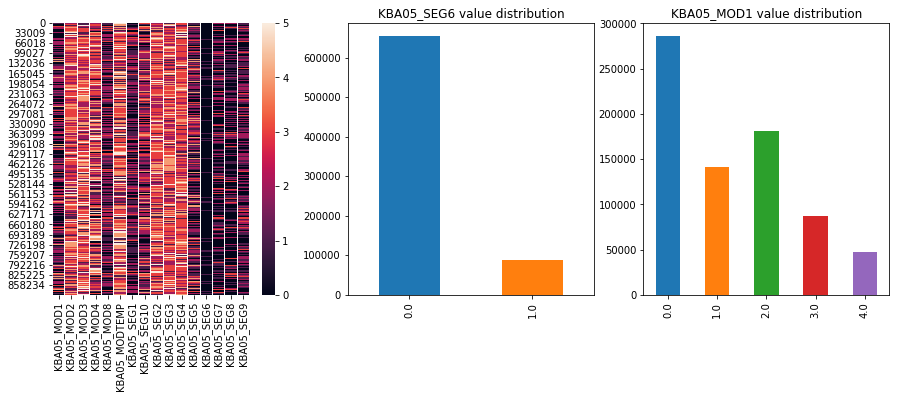

In [77]:
chk = 'KBA05_SEG6' # just takes two values 0 or 1 (none or some)

plt.figure(figsize = (15, 5))
plt.subplot(1,3,1)
ax = sns.heatmap(azRun[match])
plt.subplot(1,3,2)
ax = PlotValueCounts(azRun, cols=[chk])
_ = ax.set_title(chk + ' value distribution')
plt.subplot(1,3,3)
ax = PlotValueCounts(azRun, cols=['KBA05_MOD1'])
_ = ax.set_title('KBA05_MOD1' + ' value distribution')

In [78]:
azRun['KBA05_SEG6'].skew(), azRun['KBA05_MOD1'].skew()

(2.3523863896819845, 0.5647573886789276)

My decision was good because the AZ specifid description for high class cars (=MOD1) has a better distribution than the description for high class cars like BMW 7er (=KBA05_SEG6).

In [79]:
dsh.GetMatches(azRun.columns, '*kmh*')

['KBA13_KMH_0_140',
 'KBA13_KMH_110',
 'KBA13_KMH_140',
 'KBA13_KMH_140_210',
 'KBA13_KMH_180',
 'KBA13_KMH_210',
 'KBA13_KMH_211',
 'KBA13_KMH_250',
 'KBA13_KMH_251']

In [80]:
CleanConfig.DropColumns.extend(dsh.GetMatches(azdias.columns, ['*max*']))

CleanConfig.DropColumns.extend([
    
    'KBA05_MOTOR',                                            # described by KBA05_CCM
    'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_MOTOR', # described by KBA13_CCM
    
    'KBA13_KW_61_120', 'KBA13_KW_0_60', 
    'KBA13_KMH_0_140', 'KBA13_KMH_140_210',  'KBA13_KMH_211'
    
])

CleanConfig.DropColumns.extend(dsh.GetMatches(azRun.columns, '*alterhalter_??')) # described by HALTER_20...

CleanConfig.DropColumns.extend(dsh.GetMatches(azRun.columns, ['*seg?', '*seg??'])) # described by KBA_MOD_1..5

CleanConfig.DropColumns.extend(dsh.GetMatches(azRun.columns, '*_fein')) # described by *_GROB

CleanConfig.DropColumns.append('ALTER_HH') # described by ALTERSKATEGORIE_GROB

In [81]:
azRun = PrepDropRowsAndColumnsByNAN(azRun)
cusRun = PrepDropRowsAndColumnsByNAN(cusRun)

-------------------- Start finding and removing columns matchting to wildcards: ['LNR', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE', 'VERDICHTUNGSRAUM', 'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'D19_KONSUMTYP_MAX', 'KBA05_BAUMAX', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA13_BAUMAX', 'PLZ8_BAUMAX', 'KBA05_MOTOR', 'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_MOTOR', 'KBA13_KW_61_120', 'KBA13_KW_0_60', 'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211', 'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61', 'KBA05_SEG1', 'KBA05_SEG10', '

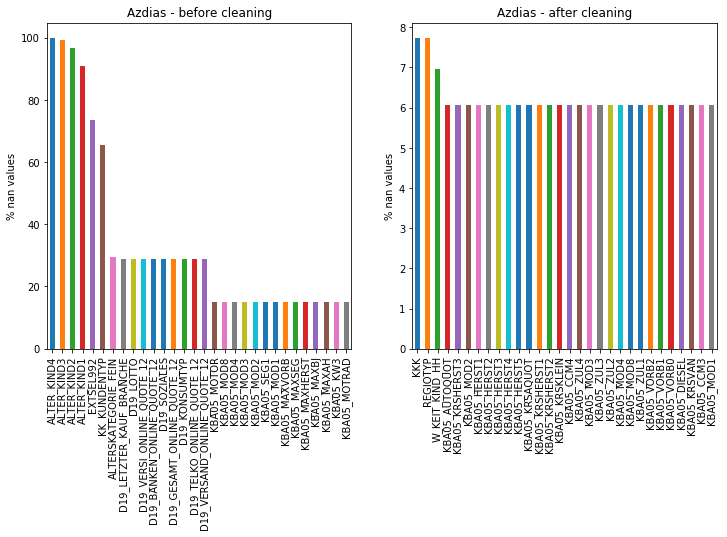

In [82]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)

azSum = azdias.isnull().sum().sort_values(ascending= False)[:30] / azdias.shape[0] * 100
azRSum = azRun.isnull().sum().sort_values(ascending= False)[:30] / azRun.shape[0] * 100

ax = azSum.plot(kind = 'bar')
_ = ax.set_title('Azdias - before cleaning')
_ = ax.set_ylabel('% nan values')

plt.subplot(1,2,2)
ax = azRSum.plot(kind = 'bar')
_ = ax.set_title('Azdias - after cleaning')
_ = ax.set_ylabel('% nan values')


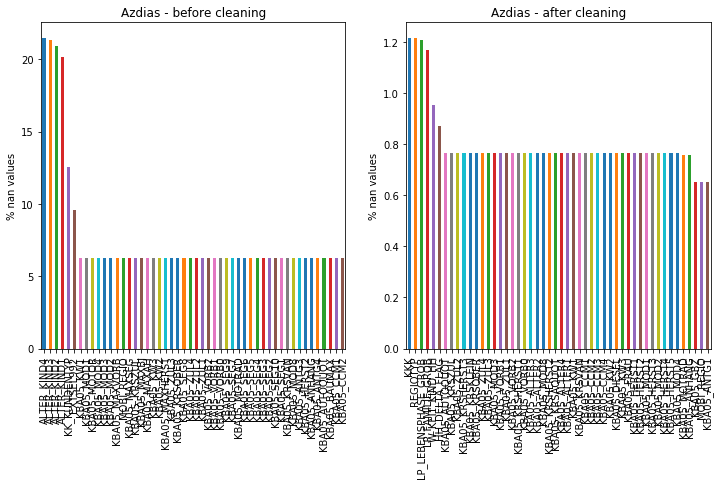

In [83]:
azSum = customers.isnull().sum().sort_values(ascending= False)[:50] / azdias.shape[0] * 100
azRSum = cusRun.isnull().sum().sort_values(ascending= False)[:50] / azRun.shape[0] * 100

plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
ax = azSum.plot(kind = 'bar')
_ = ax.set_title('Azdias - before cleaning')
_ = ax.set_ylabel('% nan values')

plt.subplot(1,2,2)
ax = azRSum.plot(kind = 'bar')
_ = ax.set_title('Azdias - after cleaning')
_ = ax.set_ylabel('% nan values')

### Check Logscaling

ANZ_HAUSHALTE_AKTIV 8.774807605915928
ANZ_STATISTISCHE_HAUSHALTE 8.470665116216928
KBA13_ANZAHL_PKW 1.2633760496905049
MIN_GEBAEUDEJAHR 3.4546277691361182


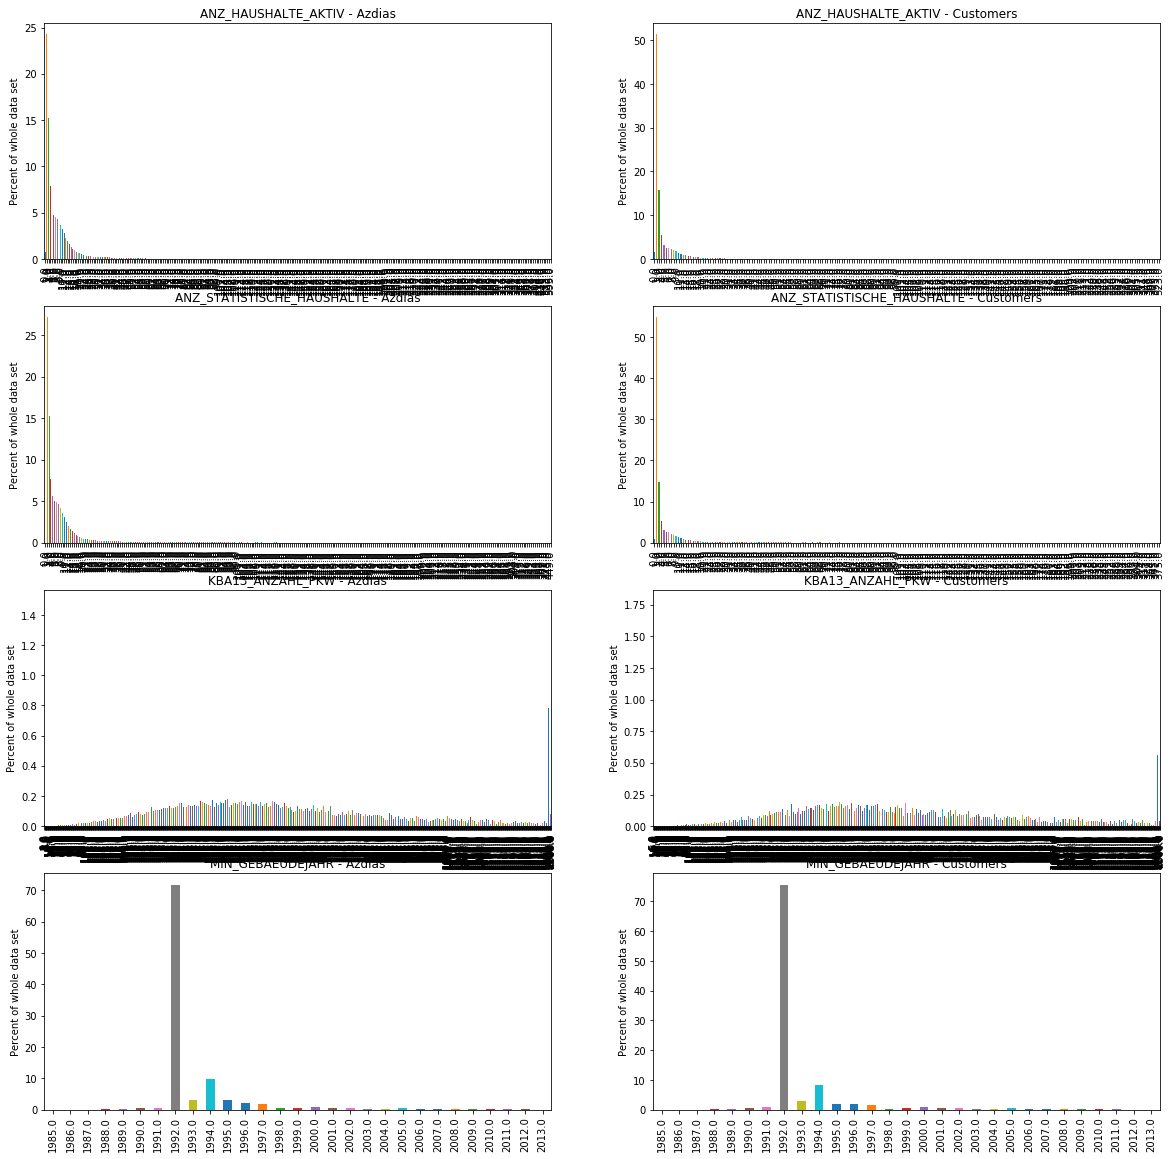

In [84]:
skewed = []
for col in azRun.columns:
    if not col in CleanConfig.NumericalColumns:
        continue
    sk1 = azRun[col].skew() 
    if abs(sk1) > 1:
        print(col, sk1)
        skewed.append(col)
        
PlotCompare(azRun, cusRun, skewed)

In [85]:
for col in azRun.columns:
    if not col in CleanConfig.NumericalColumns:
        continue
    if not abs(azRun[col].skew()) >= CleanConfig.SkewLimitForLog:
        continue
    CleanConfig.ColumnsToLogScale.append(col)
CleanConfig.ColumnsToLogScale

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

In [86]:
def PrepLogscaleColumns(dfInput):
    df = dfInput.copy(deep = True)
    dsh.PrintLine('Start logscaling')
    for col in CleanConfig.ColumnsToLogScale:
        if not col in df.columns:
            print('Columns not in dataframe: ', col)
            continue
        df[col] = df[col].apply(lambda x: np.log(x + 1))
    dsh.PrintEncapsulate('Finished logscaling: {}'.format(CleanConfig.ColumnsToLogScale))
    return df

In [87]:
azRun = PrepLogscaleColumns(azRun)
cusRun = PrepLogscaleColumns(cusRun)

-------------------- Start logscaling --------------------
--------------------  --------------------
Finished logscaling: ['ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
-------------------- - --------------------
-------------------- Start logscaling --------------------
--------------------  --------------------
Finished logscaling: ['ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
-------------------- - --------------------


### Object columns & feature creation

In [88]:
azdias[[x for x in azdias.columns 
        if azdias[x].dtype == object 
        and x not in CleanConfig.DropColumns
]].head()

CAMEO_DEUG_2015 CAMEO_INTL_2015 OST_WEST_KZ
0            None            None        None
1             8.0            51.0           W
2             4.0            24.0           W
3             2.0            12.0           W
4             6.0            43.0           W

In [89]:
azRun[[x for x in azRun.columns 
        if azRun[x].dtype == object 
        and x not in CleanConfig.DropColumns
]].head()

OST_WEST_KZ
1           W
2           W
3           W
4           W
5           W

In [90]:
print(CleanConfig.ColumnValues['CAMEO_DEUG_2015'].Meanings)
dsh.PrintLine()
print(CleanConfig.ColumnValues['CAMEO_INTL_2015'].Meanings)
dsh.PrintLine()
print(CleanConfig.ColumnValues['PRAEGENDE_JUGENDJAHRE'].Meanings)

['unknown', 'upper class', 'upper middleclass', 'established middleclasse', 'consumption-oriented middleclass ', 'active middleclass ', 'low-consumption middleclass', 'lower middleclass', 'working class', 'urban working class']
-------------------- - --------------------
['unknown', 'Wealthy Households-Pre-Family Couples & Singles', 'Wealthy Households-Young Couples With Children', 'Wealthy Households-Families With School Age Children', 'Wealthy Households-Older Families &  Mature Couples', 'Wealthy Households-Elders In Retirement', 'Prosperous Households-Pre-Family Couples & Singles', 'Prosperous Households-Young Couples With Children', 'Prosperous Households-Families With School Age Children', 'Prosperous Households-Older Families & Mature Couples', 'Prosperous Households-Elders In Retirement', 'Comfortable Households-Pre-Family Couples & Singles', 'Comfortable Households-Young Couples With Children', 'Comfortable Households-Families With School Age Children', 'Comfortable Households

CAMEO_DEUG_2015 has been treated in the previous steps (converted to float).

OST_WEST_KZ and the other categorical features will be one-hot encoded (replace W, E by 1, 0). For that, I create a list to iterate over it.

The feature PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 will be dropped, but before I extract new features giving information about the ages, avantgarge/mainstream and east/west.

From LEBENSPHASE_GROB I also extract the information regarding income and household.

In [91]:
def PrepExtractFeatures(dfInput):
    df = dfInput.copy(deep = True)
    dropcols = []
    
    dsh.PrintLine('Preparing column: CAMEO_INTL_2015')
    print(df['CAMEO_INTL_2015'].value_counts())
    df['CAMEO_INTL_2015_Wealth'] = pd.to_numeric(df['CAMEO_INTL_2015']) // 10
    df['CAMEO_INTL_2015_Ages'] = pd.to_numeric(df['CAMEO_INTL_2015']) % 10
    print(df['CAMEO_INTL_2015_Ages'].value_counts())
    print(df['CAMEO_INTL_2015_Wealth'].value_counts())
    df = df.drop('CAMEO_INTL_2015', axis = 1)
    
    dsh.PrintLine('Preparing column: PRAEGENDE_JUGENDJAHRE')
    print(df['PRAEGENDE_JUGENDJAHRE'].value_counts())
    mainstreamId = []
    avantId = []
    ages = {}
    praegO = []
    praegW = []
    
    
    col = 'PRAEGENDE_JUGENDJAHRE'
    for ind, x in enumerate(CleanConfig.ColumnValues[col].Meanings):
        if ind == 0:
            continue
        if 'Mainstream' in x:
            mainstreamId.append(ind)
        elif 'Avant' in x:
            avantId.append(ind)
        else:
            print('Neither "Mainstream" nor "Avant" in value: ', x)
        
        if dsh.IsMatch(x, ['*O)', '* O+*']):
            praegO.append(ind)
        elif dsh.IsMatch(x, ['*W)', '* W+*']):
            praegW.append(ind)

        ages[ind] = float(x[:2]) / 10.0

    df['PRAEGENDE_JUGENDJAHRE_MainAvant'] = df[col].apply(
        lambda x: 1 if x in mainstreamId
                else 0 if x in avantId
                else x
    )
    
    df['PRAEGENDE_JUGENDJAHRE_Ages'] = df[col].apply(
        lambda x: x if np.isnan(x) else ages[x]
    )
    
    df['PRAEGENDE_JUGENDJAHRE_Ost'] = df[col].apply(
        lambda x: x if np.isnan(x) else 1 if x in praegO else 0
    )
    df['PRAEGENDE_JUGENDJAHRE_West'] = df[col].apply(
    lambda x: x if np.isnan(x) else 1 if x in praegW else 0
    )
    
    print(df['PRAEGENDE_JUGENDJAHRE_Ost'].value_counts())
    print(df['PRAEGENDE_JUGENDJAHRE_West'].value_counts())
    dsh.PrintLine(ages)
    
    print(df['PRAEGENDE_JUGENDJAHRE_MainAvant'].value_counts())
    print(df['PRAEGENDE_JUGENDJAHRE_Ages'].value_counts())
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    
# single low-income- and average earners of younger age   1
# single low-income- and average earners of higher age    1
# single high-income earners                              1
# single low-income- and average earner-couples           2
# single high-income earner-couples                       2
# single parents                                          2
# single low-income- and average earner-families          2
# high-income earner-families                             2
# average earners of younger age from mulitperson households 
# low-income- and average earners of higher age from mulitperson households
# high-income earners of younger age from multiperson households
# high-income earners of higher age from multiperson households  

    # LP_LEBENSPHASE_GROB
    
    sv = CleanConfig.ColumnValues['LP_LEBENSPHASE_GROB'].SingleValues
    df['LP_LEBENSPHASE_GROB_Income'] = df['LP_LEBENSPHASE_GROB'].apply(lambda x:
                                                                      np.NaN if x not in sv.keys()
                                                                      else 2 if dsh.IsMatch(sv[x], '*low*income*average*')
                                                                      else 1 if dsh.IsMatch(sv[x], '*low*income*')
                                                                      else 3 if dsh.IsMatch(sv[x], '*high*income*')
                                                                      else np.NaN
                                                                      )

    df['LP_LEBENSPHASE_GROB_HouseHold'] = df['LP_LEBENSPHASE_GROB'].apply(lambda x:
                                                                      np.NaN if x not in sv.keys()
                                                                      else 3 if dsh.IsMatch(sv[x], '*multiperson*')  
                                                                      else 2 if dsh.IsMatch(sv[x], '*single*earners*')
                                                                      else 1
                                                                      )
    df = df.drop('LP_LEBENSPHASE_GROB', axis = 1)
    
    
    if 'CAMEO_DEU_2015' in df.columns and not 'CAMEO_DEU_2015' in CleanConfig.DropColumns:
        print('Pay attention: CAMEO_DEU_2015 one-hot encoding')
        df = dsh.ApplyOneHotEncoding(df, columns=['CAMEO_DEU_2015'])    
    
    dsh.PrintLine(n=10)
    print('New columns: ', set(df.columns) - set(dfInput.columns))
    dsh.PrintLine(n=10)
    print('Dropped columns: ', set(dfInput.columns) - set(df.columns))
    dsh.PrintLine('Finished object column preparation')
    
    return df

In [92]:
azRun = PrepExtractFeatures(azRun)
cusRun = PrepExtractFeatures(cusRun)

-------------------- Preparing column: CAMEO_INTL_2015 --------------------
51.0    131840
41.0     90964
24.0     90076
14.0     62171
43.0     56056
54.0     44835
25.0     39223
22.0     32626
13.0     26006
23.0     25928
45.0     25881
55.0     23344
52.0     20390
31.0     18560
34.0     18208
15.0     16849
44.0     14640
12.0     13096
35.0     10250
32.0     10235
33.0      9774
Name: CAMEO_INTL_2015, dtype: int64
1.0    241364
4.0    229930
3.0    117764
5.0    115547
2.0     76347
Name: CAMEO_INTL_2015_Ages, dtype: int64
5.0    220409
2.0    187853
4.0    187541
1.0    118122
3.0     67027
Name: CAMEO_INTL_2015_Wealth, dtype: int64
-------------------- Preparing column: PRAEGENDE_JUGENDJAHRE --------------------
14.0    180065
8.0     139100
10.0     84412
5.0      83729
3.0      53150
15.0     41657
11.0     35097
9.0      33127
6.0      25439
12.0     24132
1.0      20318
4.0      20303
2.0       7434
13.0      5628
7.0       3957
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


### Reorder and shift values
There are some columns whose values to not correspond for what they actually stand for (for example (0 - verly likely/high income/great neighbourhodd, 10 very unlikely/lowest income/poor neighbourhood). I intend to run PCA on the data and to facilitate the interpretation, I change the order of these values.

Other columns need to be shifted: 

In [93]:
reorder = []
for cv in CleanConfig.ColumnValues.values():
    if cv.ColumnName in CleanConfig.DropColumns or not cv.ColumnName in azRun.columns:
        continue
    if cv.LowestValue > 2:
        if cv.ColumnName in ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']:
            continue
        print(cv.ColumnName, cv.LowestValue)
        reorder.append(cv.ColumnName)

CAMEO_DEUG_2015 9
D19_BANKEN_DATUM 10
D19_BANKEN_DIREKT 7
D19_BANKEN_GROSS 7
D19_BANKEN_LOKAL 7
D19_BANKEN_OFFLINE_DATUM 10
D19_BANKEN_ONLINE_DATUM 10
D19_BANKEN_REST 7
D19_BEKLEIDUNG_GEH 7
D19_BEKLEIDUNG_REST 7
D19_BILDUNG 7
D19_BIO_OEKO 7
D19_DIGIT_SERV 7
D19_DROGERIEARTIKEL 7
D19_ENERGIE 7
D19_FREIZEIT 7
D19_GARTEN 7
D19_GESAMT_DATUM 10
D19_GESAMT_OFFLINE_DATUM 10
D19_GESAMT_ONLINE_DATUM 10
D19_HANDWERK 7
D19_HAUS_DEKO 7
D19_KINDERARTIKEL 7
D19_KOSMETIK 7
D19_LEBENSMITTEL 7
D19_NAHRUNGSERGAENZUNG 7
D19_RATGEBER 7
D19_REISEN 7
D19_SAMMELARTIKEL 7
D19_SCHUHE 7
D19_SONSTIGE 7
D19_TECHNIK 7
D19_TELKO_DATUM 10
D19_TELKO_MOBILE 7
D19_TELKO_OFFLINE_DATUM 10
D19_TELKO_ONLINE_DATUM 10
D19_TELKO_REST 7
D19_TIERARTIKEL 7
D19_VERSAND_DATUM 10
D19_VERSAND_OFFLINE_DATUM 10
D19_VERSAND_ONLINE_DATUM 10
D19_VERSAND_REST 7
D19_VERSICHERUNGEN 7
D19_VOLLSORTIMENT 7
D19_WEIN_FEINKOST 7
FINANZ_ANLEGER 5
FINANZ_HAUSBAUER 5
FINANZ_MINIMALIST 5
FINANZ_SPARER 5
FINANZ_UNAUFFAELLIGER 5
FINANZ_VORSORGER 5
GEBA

In [94]:
CleanConfig.ColumnsReorderValues = reorder

FINANZTYPs highest scalar value standing for 'unremarkable' is not on top of 'investor'. So I rearange the values: 

- 0 = unremarkable,
- 1 = low fincancial interest, ...
- 6 = investor

I also shift the values in the column describing the nationality. Currently its 1=sounding german, 2 = sounding foreign, 3 = assimilated.

In [95]:
def ReorderSeries(ser):
    vmin = ser.min()
    vmax = ser.max()
    
    if 'D19' in ser.name and 'no transaction known' in CleanConfig.ColumnValues[ser.name].Meanings[0]:
        vmin = vmin + 1
    
    dsh.PrintLine()
    print('current column: ', ser.name)

    repDic = {}
    for ind in range (int(vmin), int(vmax) + 1):
        repDic[ind] = float(vmax + 1 - ind)
    return repDic
            
def ReorderValues(dfInput):
    dsh.PrintLine('Start reordering values')
    df = dfInput.copy(deep = True)
    
    for col in CleanConfig.ColumnsReorderValues:
        if not col in df.columns:
            print('Skipping column because it is not contained: ', col)
            continue
        
        repDic = ReorderSeries(df[col])
        
        dsh.PrintLine('Applying reorder on {}: {}'.format(col, repDic))
        
        meanings = CleanConfig.ColumnValues[col].Meanings
        if len(meanings) > 2:
            print('Having meanings: ', meanings[:1], ' - ', meanings[:-1])
        try:
            df[col] = df[col].apply(lambda x: repDic[x] if x in repDic.keys() else x)
        except:
            print('Error reordering values in column "{}": '.format(col), repDic, df[col].unique())
            return
    
    dsh.PrintLine('Finished reordering values')
    return df


def ShiftRight(ser, mod):
    return ser.apply(
        lambda x: 
        x if x == 0 or np.isnan(x) # don't change the meaning of unknown!
        else ((x % mod) + 1)
    )

def ShiftLeft(ser, mod):
    return ser.apply(
        lambda x: 
        x if x == 0 or np.isnan(x) # don't change the meaning of unknown!
        else (x - 2) % mod + 1
        # 1 => 3
        # 3 => 2
        # 2 => 1
    )

def ShiftValues(dfInput):
    dsh.PrintLine('Start shifting vaues')
    df = dfInput.copy(deep = True)
    
    df['FINANZTYP'] = ShiftRight(df['FINANZTYP'], 6)
    df['NATIONALITAET_KZ'] = ShiftLeft(df['NATIONALITAET_KZ'], 3)
    
    dsh.PrintLine('Finshed shifting vaues')
    return df

def PrepReorderShiftValues(dfInput):
    df = dfInput.copy(deep = True)
    df = ReorderValues(df)
    df = ShiftValues(df)
    return df

In [96]:
azRun = PrepReorderShiftValues(azRun)
cusRun = PrepReorderShiftValues(cusRun)


-------------------- Start reordering values --------------------
-------------------- - --------------------
current column:  CAMEO_DEUG_2015
-------------------- Applying reorder on CAMEO_DEUG_2015: {1: 9.0, 2: 8.0, 3: 7.0, 4: 6.0, 5: 5.0, 6: 4.0, 7: 3.0, 8: 2.0, 9: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'upper class', 'upper middleclass', 'established middleclasse', 'consumption-oriented middleclass ', 'active middleclass ', 'low-consumption middleclass', 'lower middleclass', 'working class']
-------------------- - --------------------
current column:  D19_BANKEN_DATUM
-------------------- Applying reorder on D19_BANKEN_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12 months']  -  ['highest activity within the last 12 months', 'very high activity within the last 12 months', 'high activity within the last 12 months', 'increased activit

-------------------- - --------------------
current column:  D19_GESAMT_DATUM
-------------------- Applying reorder on D19_GESAMT_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12 months']  -  ['highest activity within the last 12 months', 'very high activity within the last 12 months', 'high activity within the last 12 months', 'increased activity within the last 12 months', 'slightly increased activity within the last 12 months', 'activity elder than 1 year', 'activity elder than 1,5 years', 'activity elder than 2 years', 'activity elder than 3 years']
-------------------- - --------------------
current column:  D19_GESAMT_OFFLINE_DATUM
-------------------- Applying reorder on D19_GESAMT_OFFLINE_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12 months'] 

-------------------- - --------------------
current column:  D19_TELKO_OFFLINE_DATUM
-------------------- Applying reorder on D19_TELKO_OFFLINE_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12 months']  -  ['highest activity within the last 12 months', 'very high activity within the last 12 months', 'high activity within the last 12 months', 'increased activity within the last 12 months', 'slightly increased activity within the last 12 months', 'activity elder than 1 year', 'activity elder than 1,5 years', 'activity elder than 2 years', 'activity elder than 3 years']
-------------------- - --------------------
current column:  D19_TELKO_ONLINE_DATUM
-------------------- Applying reorder on D19_TELKO_ONLINE_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12

-------------------- - --------------------
current column:  HH_EINKOMMEN_SCORE
-------------------- Applying reorder on HH_EINKOMMEN_SCORE: {1: 6.0, 2: 5.0, 3: 4.0, 4: 3.0, 5: 2.0, 6: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest income', 'very high income', 'high income', 'average income', 'lower income']
-------------------- - --------------------
current column:  KBA05_HERSTTEMP
-------------------- Applying reorder on KBA05_HERSTTEMP: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'promoted', 'stayed upper level', 'stayed lower/average level', 'demoted']
-------------------- - --------------------
current column:  KBA05_MODTEMP
-------------------- Applying reorder on KBA05_MODTEMP: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'promoted', 'stayed upper level', 'stayed lower/average level', 'demoted']
-------------------- - -

-------------------- Finshed shifting vaues --------------------
-------------------- Start reordering values --------------------
-------------------- - --------------------
current column:  CAMEO_DEUG_2015
-------------------- Applying reorder on CAMEO_DEUG_2015: {1: 9.0, 2: 8.0, 3: 7.0, 4: 6.0, 5: 5.0, 6: 4.0, 7: 3.0, 8: 2.0, 9: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'upper class', 'upper middleclass', 'established middleclasse', 'consumption-oriented middleclass ', 'active middleclass ', 'low-consumption middleclass', 'lower middleclass', 'working class']
-------------------- - --------------------
current column:  D19_BANKEN_DATUM
-------------------- Applying reorder on D19_BANKEN_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12 months']  -  ['highest activity within the last 12 months', 'very high activity within the last 12 month

-------------------- - --------------------
current column:  D19_GESAMT_ONLINE_DATUM
-------------------- Applying reorder on D19_GESAMT_ONLINE_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12 months']  -  ['highest activity within the last 12 months', 'very high activity within the last 12 months', 'high activity within the last 12 months', 'increased activity within the last 12 months', 'slightly increased activity within the last 12 months', 'activity elder than 1 year', 'activity elder than 1,5 years', 'activity elder than 2 years', 'activity elder than 3 years']
-------------------- - --------------------
current column:  D19_HANDWERK
-------------------- Applying reorder on D19_HANDWERK: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Do

-------------------- - --------------------
current column:  D19_VERSAND_DATUM
-------------------- Applying reorder on D19_VERSAND_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12 months']  -  ['highest activity within the last 12 months', 'very high activity within the last 12 months', 'high activity within the last 12 months', 'increased activity within the last 12 months', 'slightly increased activity within the last 12 months', 'activity elder than 1 year', 'activity elder than 1,5 years', 'activity elder than 2 years', 'activity elder than 3 years']
-------------------- - --------------------
current column:  D19_VERSAND_OFFLINE_DATUM
-------------------- Applying reorder on D19_VERSAND_OFFLINE_DATUM: {1: 10.0, 2: 9.0, 3: 8.0, 4: 7.0, 5: 6.0, 6: 5.0, 7: 4.0, 8: 3.0, 9: 2.0, 10: 1.0} --------------------
Having meanings:  ['highest activity within the last 12 month

-------------------- - --------------------
current column:  SEMIO_KAEM
-------------------- Applying reorder on SEMIO_KAEM: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_KRIT
-------------------- Applying reorder on SEMIO_KRIT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_KULT
-------------------- Applying reorder on SEMIO_KULT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', '

In [97]:
pd.concat([
    azdias[azdias.index < 5][[x for x in CleanConfig.ColumnsReorderValues if x in azRun.columns]],
    azRun[azRun.index < 5][[x for x in CleanConfig.ColumnsReorderValues if x in azRun.columns]]
])

CAMEO_DEUG_2015  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
0            None              10.0                0.0               0.0   
1             8.0              10.0                0.0               0.0   
2             4.0              10.0                0.0               0.0   
3             2.0              10.0                0.0               0.0   
4             6.0               5.0                1.0               2.0   
1               2               1.0                0.0               0.0   
2               6               1.0                0.0               0.0   
3               8               1.0                0.0               0.0   
4               4               6.0                7.0               5.0   

   D19_BANKEN_LOKAL  D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0               0.0                      10.0                     10.0   
1               0.0                      10.0                     10.0   
2               0.0                      10.0                     10.0   
3               0.0                      10.0                     10.0   
4               0.0                      10.0                      5.0   
1               0.0                       1.0                      1.0   
2               0.0                       1.0                      1.0   
3               0.0                       1.0                      1.0   
4               0.0                       1.0                      6.0   

   D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  D19_BEKLEIDUNG_REST    ...     \
0              0.0                 0.0                  0.0    ...      
1              0.0                 0.0                  0.0    ...      
2              0.0                 0.0                  0.0    ...      
3              0.0                 0.0                  0.0    ...      
4              6.0                 6.0                  1.0    ...      
1              0.0                 0.0                  0.0    ...      
2              0.0                 0.0                  0.0    ...      
3              0.0                 0.0                  0.0    ...      
4              2.0                 2.0                  7.0    ...      

   SEMIO_LUST  SEMIO_MAT  SEMIO_PFLICHT  SEMIO_RAT  SEMIO_REL  SEMIO_SOZ  \
0         5.0        5.0            5.0        4.0        7.0        2.0   
1         2.0        3.0            7.0        6.0        4.0        5.0   
2         4.0        3.0            3.0        4.0        3.0        4.0   
3         4.0        1.0            4.0        3.0        2.0        5.0   
4         4.0        2.0            4.0        2.0        4.0        6.0   
1         6.0        5.0            1.0        2.0        4.0        3.0   
2         4.0        5.0            5.0        4.0        5.0        4.0   
3         4.0        7.0            4.0        5.0        6.0        3.0   
4         4.0        6.0            4.0        6.0        4.0        2.0   

   SEMIO_TRADV  SEMIO_VERT  SHOPPER_TYP  WOHNLAGE  
0          3.0         1.0         -1.0       NaN  
1          6.0         1.0          3.0       4.0  
2          3.0         4.0          2.0       2.0  
3          4.0         4.0          1.0       7.0  
4          2.0         7.0          2.0       3.0  
1          2.0         7.0          1.0       5.0  
2          5.0         4.0          2.0       7.0  
3          4.0         4.0          3.0       2.0  
4          6.0         1.0          2.0       6.0  

[9 rows x 75 columns]

### Final Step - One-hot Encode

Most of the features are ordinal and mostly having the meaning 1-low....5/7/10 high. In real life, a low share of VW is not equal to a low share of VW. But here, I will treat them as interval data to avoid one-hot encoding for all those columns. Numerical values and interval values are kept as they are.

In [98]:
list(azRun.columns)

['AKT_DAT_KL',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SC

In [99]:
def PrepOneHotEncode(dfInp):
    df = dfInp.copy(deep = True)
    dsh.PrintLine('Starting one-hot encodng')
    # I intend to facilitate GEBAEUDETYP_RASTER to 0 = residual, 1 = business
    # and to extract one-hot encoded features from GEBAEUDETYP.
    
    meanings = CleanConfig.ColumnValues['GEBAEUDETYP'].Meanings
    
    # Pay attention. The values of this column has been reordered. So 1 = residual, > 1 business
    df['GEBAEUDETYP_RASTER'] = df['GEBAEUDETYP_RASTER'].apply(lambda x:
                                                             np.nan if np.isnan(x)
                                                             else 1 if x > 1
                                                             else 0)
    
    df['GEBAEUDETYP_Residental'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
                                          else dsh.IsMatch(meanings[int(x)], ['residental*', 'mixed*'])) # avoid false match for 3
    df['GEBAEUDETYP_Mixed'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
                                          else dsh.IsMatch(meanings[int(x)], ['*mixed*']))
    df['GEBAEUDETYP_Company'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
                                          else dsh.IsMatch(meanings[int(x)], ['*company b*', 'mixed'])) 
    df['GEBAEUDETYP_WithHousehold'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
                                          else dsh.IsMatch(meanings[int(x)], ['*with *household*', 'mixed']))
    df['GEBAEUDETYP_WitCompany'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
                                          else dsh.IsMatch(meanings[int(x)], ['*with *company*', 'mixed']))
    df = df.drop('GEBAEUDETYP', axis = 1)
    
    # I decided to reduce one-hot encoding for LP_FAMILIE_GROB:
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].apply(lambda x:
                                                       3 if x in [3, 4, 5]
                                                       else 4 if x in [6,7,8]
                                                        else 5 if x in [9, 10, 11]
                                                        else x
                                                       )
    
    
    
    ohFeatures = [
        'OST_WEST_KZ',
        
        'AGER_TYP',
        'ANREDE_KZ',
        'ALTERSKATEGORIE_GROB',
        'CAMEO_DEUG_2015',
        
        'CAMEO_INTL_2015_Ages',
        'CAMEO_INTL_2015_Wealth',
        
        'CJT_GESAMTTYP',
        'GFK_URLAUBERTYP',
        'HEALTH_TYP',
        'LP_FAMILIE_GROB',
        'NATIONALITAET_KZ',
        'RETOURTYP_BK_S',
        'VERS_TYP',
        'ZABEOTYP',
        
        'FINANZTYP',
        
        'KBA05_MAXBJ',
        'KBA05_MAXHERST',
        
        
    ]

    errorcnt = 0
    
    for col in ohFeatures:
        
        if not col in df.columns:
            dsh.PrintEncapsulate('Feature does not exist anymore: {}'.format(col))
            continue
        
        uq = df[col].unique()
        uq = [x for x in uq if not dsh.IsNull(x)]
        
        if len(uq) == 1:
            dsh.PrintEncapsulate(col, 'with only one value: {}'.format(uq))
            errorcnt = errorcnt + 1
            continue
        
        if len(uq) == 2:
            df[col] = dsh.ApplyBinaryEncoding(df[col])
            continue
        
        df, _ = dsh.ApplyOneHotEncoding(df, columns = [col])
        
    
    
#     dsh.PrintLine('Preparing column: OST_WEST_KZ')
#     df['OST_WEST_KZ'] = dsh.ApplyBinaryEncoding(df['OST_WEST_KZ'])
    
    if errorcnt > 0:
        dsh.PrintLine('One-Hot encoding NOT successfully finished')
    else:
        dsh.PrintLine('One-Hot encoding successfully finished')
    return df

In [100]:
azRun = PrepOneHotEncode(azRun)

-------------------- Starting one-hot encodng --------------------
Binary encoding column:  OST_WEST_KZ
Old value counts:  W    618864
O    166066
Name: OST_WEST_KZ, dtype: int64
New value counts:  0    618864
1    166066
Name: OST_WEST_KZ, dtype: int64
--------------------  --------------------
Feature does not exist anymore: AGER_TYP
-------------------- - --------------------
Binary encoding column:  ANREDE_KZ
Old value counts:  2    409411
1    375519
Name: ANREDE_KZ, dtype: int64
New value counts:  1    409411
0    375519
Name: ANREDE_KZ, dtype: int64
-------------------- Start applying one-hot encoding on: ['ALTERSKATEGORIE_GROB'] --------------------
Columns before one hot encoding:  317
Columns to be removed and replaced:  ['ALTERSKATEGORIE_GROB']
Size after encoding:  321
Columns successfully one hot encoded :)  New columns are:  ['ALTERSKATEGORIE_GROB_1', 'ALTERSKATEGORIE_GROB_2', 'ALTERSKATEGORIE_GROB_3', 'ALTERSKATEGORIE_GROB_4', 'ALTERSKATEGORIE_GROB_9']
Removed columns af

### Clean original data with clean function

In [101]:
def PrepareForSegmentation(dfinput, testData = False):
    df = dfinput.copy(deep = True)
    
    df = PrepMissingValuesToNan(df)
    df = PrepUpdateValues(df)
    df = PrepDropRowsAndColumnsByNAN(df, testData)
    df = PrepLogscaleColumns(df)
    df = PrepExtractFeatures(df)
    df = PrepReorderShiftValues(df)
    df = PrepOneHotEncode(df)
    
    return df

In [102]:
azRun = PrepareForSegmentation(azdias)

-------------------- Start converting missing values to nan --------------------
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 99352 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 99352 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0'] - 111196 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 13877 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14791 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_CCM4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_DIESEL - ['-1'

-------------------- Convert undocumented values to nan --------------------
KBA05_MODTEMP  creplace value:  6
LP_FAMILIE_FEIN  creplace value:  0
LP_FAMILIE_GROB  creplace value:  0
LP_LEBENSPHASE_FEIN  creplace value:  0
LP_LEBENSPHASE_GROB  creplace value:  0
ORTSGR_KLS9  creplace value:  0
-------------------- Update values based on other columns --------------------
-------------------- Finished --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['LNR', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE', 'VERDICHTUNGSRAUM', 'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'D19_KONSUMTYP_M

-------------------- - --------------------
current column:  D19_BEKLEIDUNG_GEH
-------------------- Applying reorder on D19_BEKLEIDUNG_GEH: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_BEKLEIDUNG_REST
-------------------- Applying reorder on D19_BEKLEIDUNG_REST: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_BILDUNG
---------------

-------------------- - --------------------
current column:  D19_NAHRUNGSERGAENZUNG
-------------------- Applying reorder on D19_NAHRUNGSERGAENZUNG: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_RATGEBER
-------------------- Applying reorder on D19_RATGEBER: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_REISEN
-------------------- A

-------------------- - --------------------
current column:  D19_VERSAND_REST
-------------------- Applying reorder on D19_VERSAND_REST: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_VERSICHERUNGEN
-------------------- Applying reorder on D19_VERSICHERUNGEN: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_VOLLSORTIMENT
---------------

-------------------- - --------------------
current column:  SEMIO_LUST
-------------------- Applying reorder on SEMIO_LUST: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_MAT
-------------------- Applying reorder on SEMIO_MAT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_PFLICHT
-------------------- Applying reorder on SEMIO_PFLICHT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity

-------------------- Start applying one-hot encoding on: ['LP_FAMILIE_GROB'] --------------------
Columns before one hot encoding:  355
Columns to be removed and replaced:  ['LP_FAMILIE_GROB']
Size after encoding:  357
Columns successfully one hot encoded :)  New columns are:  ['LP_FAMILIE_GROB_1.0', 'LP_FAMILIE_GROB_2.0', 'LP_FAMILIE_GROB_3.0']
Removed columns after one hot encoding:  ['LP_FAMILIE_GROB']
-------------------- Finished applying one-hot encoding --------------------
-------------------- Start applying one-hot encoding on: ['NATIONALITAET_KZ'] --------------------
Columns before one hot encoding:  357
Columns to be removed and replaced:  ['NATIONALITAET_KZ']
Size after encoding:  359
Columns successfully one hot encoded :)  New columns are:  ['NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_2.0', 'NATIONALITAET_KZ_3.0']
Removed columns after one hot encoding:  ['NATIONALITAET_KZ']
-------------------- Finished applying one-hot encoding --------------------
-------------------- S

## Preparing for model - Feature transformation

I use an imputer to replace NaN values by the mean because there are too many rows having at least one nan value and dropping those rows means loosing information. 

To use PCA, we need to impute missing values and scale all the given values to be a number between 0 and 1 so that differences in scaling do not effect the principal components.

In [103]:
CleanConfig.Imputer = preprocessing.Imputer(missing_values = 'NaN', strategy = 'median')
CleanConfig.Scaler = preprocessing.StandardScaler()

CleanConfig.ImputerBinary = preprocessing.Imputer(missing_values = 'NaN', strategy = 'most_frequent')

In [104]:
def GetBinaryColumns(df):
    binaryCols = []
    for col in df.columns:
        uq = [x for x in df[col].unique() if not dsh.IsNull(x)]
        if len(uq) <= 2:
            binaryCols.append(col)
    return binaryCols

GetBinaryColumns(azRun)

['DSL_FLAG',
 'GEBAEUDETYP_RASTER',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ANREDE_KZ',
 'PRAEGENDE_JUGENDJAHRE_MainAvant',
 'PRAEGENDE_JUGENDJAHRE_Ost',
 'PRAEGENDE_JUGENDJAHRE_West',
 'LP_LEBENSPHASE_GROB_Income',
 'GEBAEUDETYP_Residental',
 'GEBAEUDETYP_Mixed',
 'GEBAEUDETYP_Company',
 'GEBAEUDETYP_WithHousehold',
 'GEBAEUDETYP_WitCompany',
 'ALTERSKATEGORIE_GROB_1',
 'ALTERSKATEGORIE_GROB_2',
 'ALTERSKATEGORIE_GROB_3',
 'ALTERSKATEGORIE_GROB_4',
 'ALTERSKATEGORIE_GROB_9',
 'CAMEO_DEUG_2015_1.0',
 'CAMEO_DEUG_2015_2.0',
 'CAMEO_DEUG_2015_3.0',
 'CAMEO_DEUG_2015_4.0',
 'CAMEO_DEUG_2015_5.0',
 'CAMEO_DEUG_2015_6.0',
 'CAMEO_DEUG_2015_7.0',
 'CAMEO_DEUG_2015_8.0',
 'CAMEO_DEUG_2015_9.0',
 'CAMEO_INTL_2015_Ages_1.0',
 'CAMEO_INTL_2015_Ages_2.0',
 'CAMEO_INTL_2015_Ages_3.0',
 'CAMEO_INTL_2015_Ages_4.0',
 'CAMEO_INTL_2015_Ages_5.0',
 'CAMEO_INTL_2015_Wealth_1.0',
 'CAMEO_INTL_2015_Wealth_2.0',
 'CAMEO_INTL_2015

In [105]:
def Impute(dfInput, fit = True):
    df = dfInput.copy(deep = True)
    
    binCols = GetBinaryColumns(df)
    noBinCols = [x for x in df.columns if not x in binCols]
    
    tfBin = None
    if fit:
        tfBin = CleanConfig.ImputerBinary.fit_transform(df[binCols])
    else:
        tfBin = CleanConfig.ImputerBinary.transform(df[binCols])
    
    tf = None
    if fit:
        tf = CleanConfig.Imputer.fit_transform(df[noBinCols])
    else:
        tf = CleanConfig.Imputer.transform(df[noBinCols])
    
    df = pd.DataFrame(tf, columns = noBinCols)
    dfBin = pd.DataFrame(tfBin, columns = binCols)
    
    return df.merge(dfBin, how = 'inner', left_index = True, right_index = True)

def Scale(dfInput, fit = True):
    df = dfInput.copy(deep = True)
    
    sc = None
    if fit:
        sc = CleanConfig.Scaler.fit_transform(df.values)
    else:
        sc = CleanConfig.Scaler.transform(df.values)
    
    df = pd.DataFrame(sc, columns = list(df.columns))
    
    return df    

In [106]:
azClust = Impute(azRun, True)
azClust = Scale(azClust, True)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Dimensionality reduction - PCA

It first, I do PCA with all components and have a look at the explained variance. Then, I decide how much % of the data set I intend to describe and search the required amount of components.

In [107]:
nbrCompAll = azClust.shape[1]
nbrReducedComp = 0 # will be set later


In [108]:
pcaAll = PCA(n_components = nbrCompAll)
azPcaAll = pcaAll.fit_transform(azClust.values)

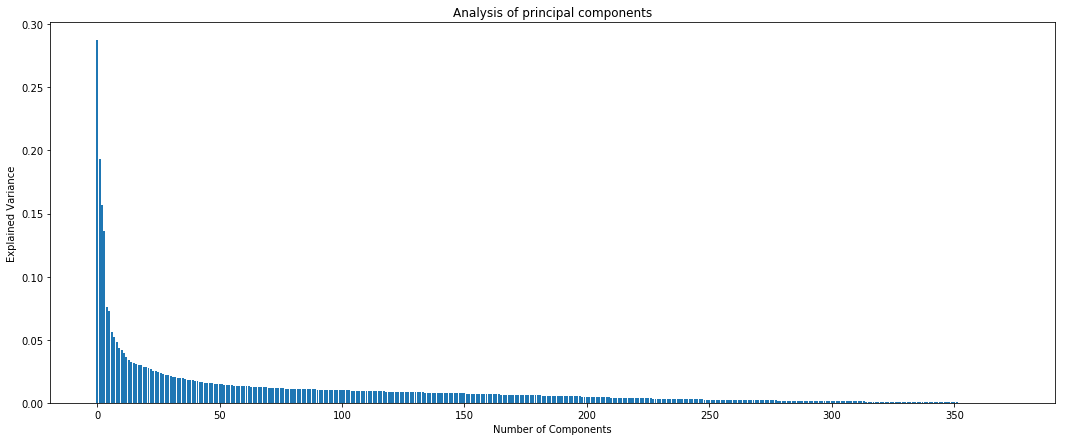

In [109]:
plt.figure(figsize = (18, 7))
dsh.PCAPlotExplainedVariances(pca = pcaAll)

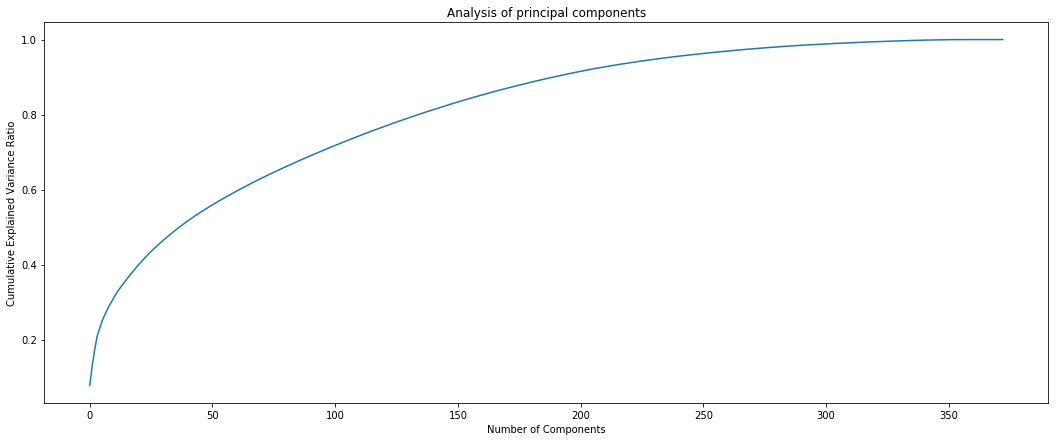

In [110]:
plt.figure(figsize = (18, 7))
dsh.PCAPlotCumulatedVarianceRatios(pcaAll)

I intend to describe 90% of the dataset and search the required number of components.

In [111]:
pcaLimitDesc = 0.9

for ind in range(200, len(pcaAll.explained_variance_ratio_)):
    if np.sum(pcaAll.explained_variance_ratio_[:ind]) >= pcaLimitDesc:
        nbrReducedComp = ind + 1 # 0-index based but we want the correct number for components
        dsh.PrintEncapsulate('Reduced components {} describe {} of the data.'.format(nbrReducedComp, pcaLimitDesc))
        break

--------------------  --------------------
Reduced components 201 describe 0.9 of the data.
-------------------- - --------------------


In [112]:
pcaReduced = PCA(n_components = nbrReducedComp)
azPcaReduced = pcaReduced.fit_transform(azClust.values)

In [113]:
def AnalysePCAComponent(comps, pcaind, usedComponents, scaledTfImpOneHotDf, plot = True):
    comp = comps[pcaind]
    usedcolumns = list(scaledTfImpOneHotDf)
    unsortedList = []
    for ind in range(len(comp)):
        unsortedList.append([usedcolumns[ind], comp[ind]])

    sortedList = sorted(unsortedList, key = lambda x: x[1], reverse = True)

    txt = '-' * 10 + ' Component ' + str(pcaind) + ' ' + '-' * 10
    print(txt)
    
    tmpDir = {}
    half = len(sortedList)
    for ind in range(0, usedComponents):
        nind = len(sortedList) - ind - 1
        print('Positive: ', sortedList[ind][0], sortedList[ind][1], ' - Negative: ', sortedList[nind][0], sortedList[nind][1])
        if ind < half:
            tmpDir[sortedList[ind][0]] = sortedList[ind][1]
            tmpDir[sortedList[nind][0]] = sortedList[nind][1]
    return sortedList

In [114]:
_ = AnalysePCAComponent(pcaReduced.components_, 0, 100, azClust, False)

---------- Component 0 ----------
Positive:  KBA13_ANTG1 0.13287799994073335  - Negative:  MOBI_REGIO -0.1413470544968964
Positive:  PLZ8_ANTG1 0.13285037030531835  - Negative:  ANZ_HAUSHALTE_AKTIV -0.13697320532121682
Positive:  LP_STATUS_GROB 0.13233742431770154  - Negative:  ANZ_STATISTISCHE_HAUSHALTE -0.13558719688942802
Positive:  MOBI_RASTER 0.13063143326697485  - Negative:  KBA13_ANTG3 -0.13303447356231998
Positive:  HH_EINKOMMEN_SCORE 0.12908204856395805  - Negative:  PLZ8_ANTG3 -0.13254118873140058
Positive:  KBA05_ANTG1 0.128482350816456  - Negative:  KBA13_ANTG4 -0.12886600141945365
Positive:  KBA05_GBZ 0.12381366601190492  - Negative:  PLZ8_ANTG4 -0.12682190772454793
Positive:  KBA05_AUTOQUOT 0.12378926922533495  - Negative:  FINANZ_MINIMALIST -0.11234066544002844
Positive:  KBA13_AUTOQUOTE 0.12117735285183613  - Negative:  EWDICHTE -0.11095347728539558
Positive:  LP_LEBENSPHASE_GROB_Income 0.11752208321569954  - Negative:  ORTSGR_KLS9 -0.10980048027579437
Positive:  FINANZ

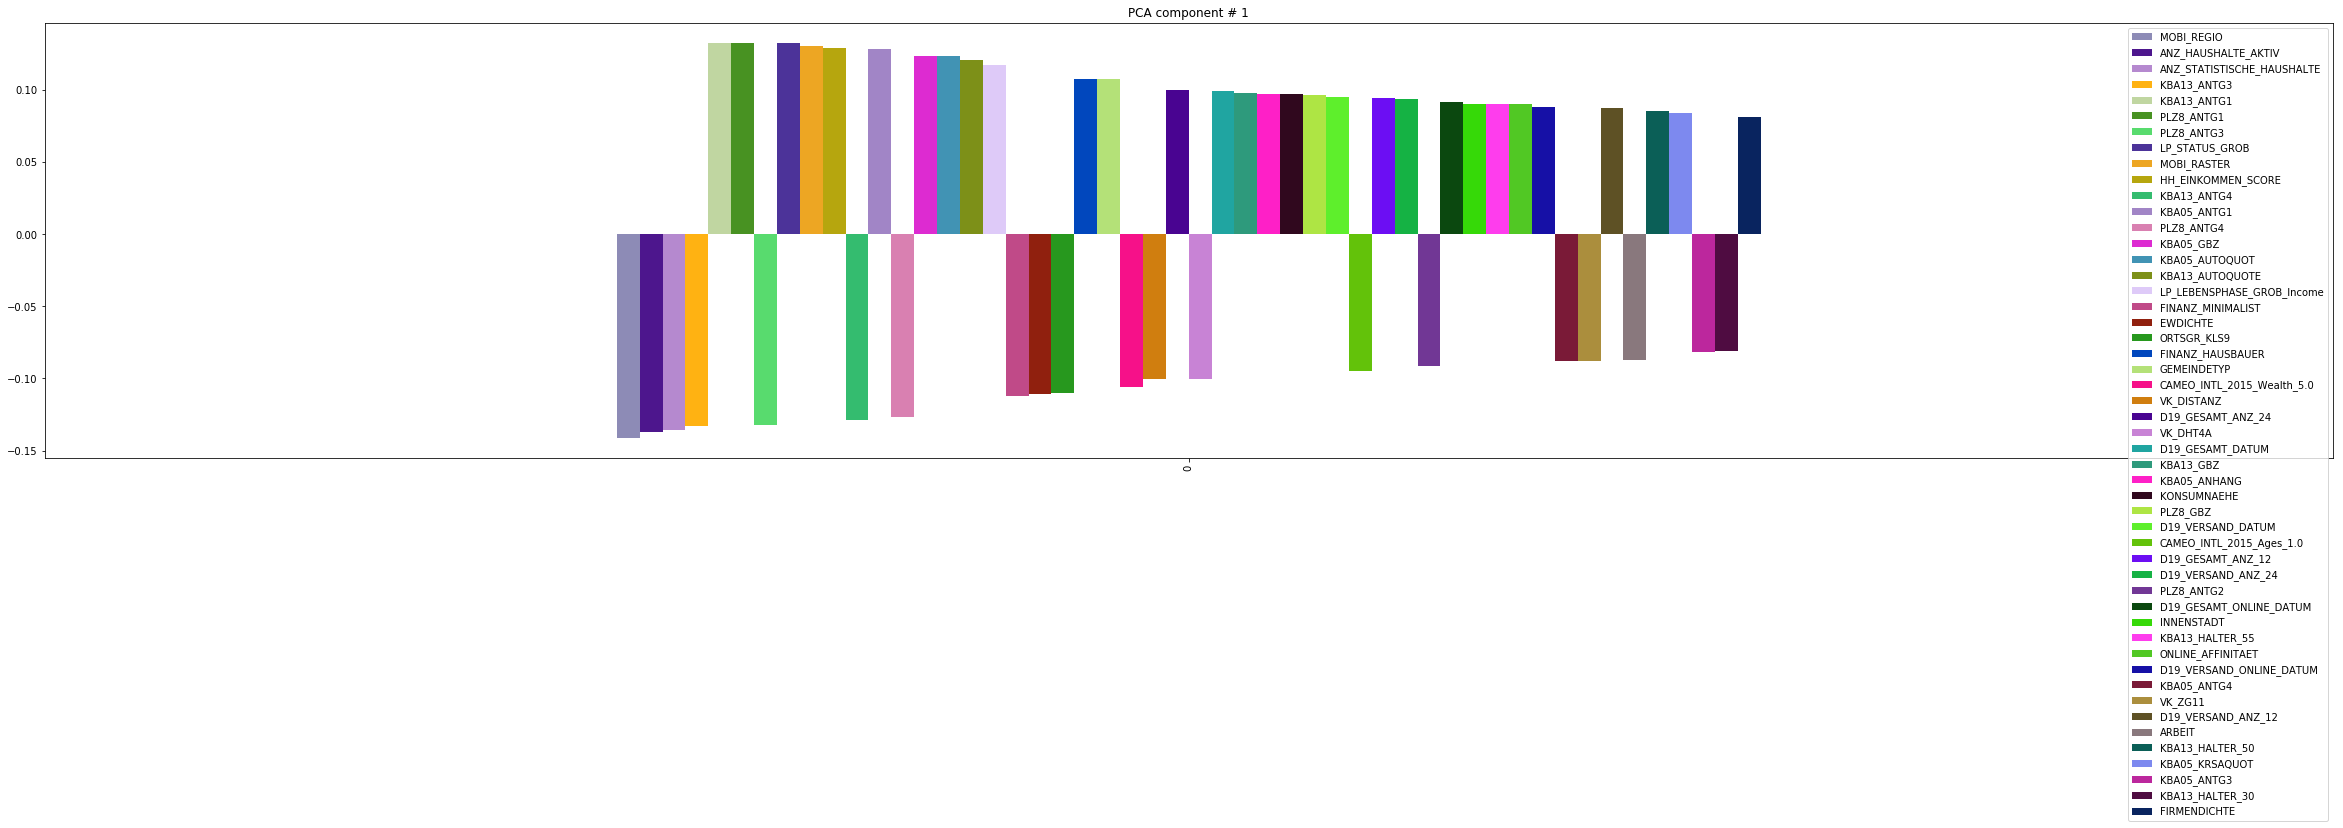

In [115]:
dsh.AnalyzePCAResult(pcaReduced, 0, azClust)

In [116]:
_ = AnalysePCAComponent(pcaReduced.components_, 1, 100, azClust, False)

---------- Component 1 ----------
Positive:  PRAEGENDE_JUGENDJAHRE_Ages 0.17870068159341326  - Negative:  KOMBIALTER -0.17243457150230931
Positive:  CJT_TYP_2 0.17222293918841697  - Negative:  FINANZ_SPARER -0.17015559208426612
Positive:  CJT_TYP_1 0.17012109640933612  - Negative:  CJT_TYP_5 -0.15766344503036808
Positive:  FINANZ_VORSORGER 0.15933668756191086  - Negative:  CJT_TYP_4 -0.1540431256066539
Positive:  ONLINE_AFFINITAET 0.15037903656001983  - Negative:  CJT_TYP_3 -0.15163295234427296
Positive:  D19_GESAMT_ANZ_24 0.12310469628206268  - Negative:  CJT_TYP_6 -0.15120067146522478
Positive:  D19_GESAMT_ANZ_12 0.11857204603240021  - Negative:  FINANZ_ANLEGER -0.1398828252268709
Positive:  D19_GESAMT_ONLINE_DATUM 0.11637111531764396  - Negative:  SEMIO_PFLICHT -0.1389631638626631
Positive:  RT_KEIN_ANREIZ 0.11307653378986177  - Negative:  FINANZ_UNAUFFAELLIGER -0.13762666619585925
Positive:  D19_VERSAND_ONLINE_DATUM 0.11269146090784961  - Negative:  ZABEOTYP_3 -0.13674625863248416


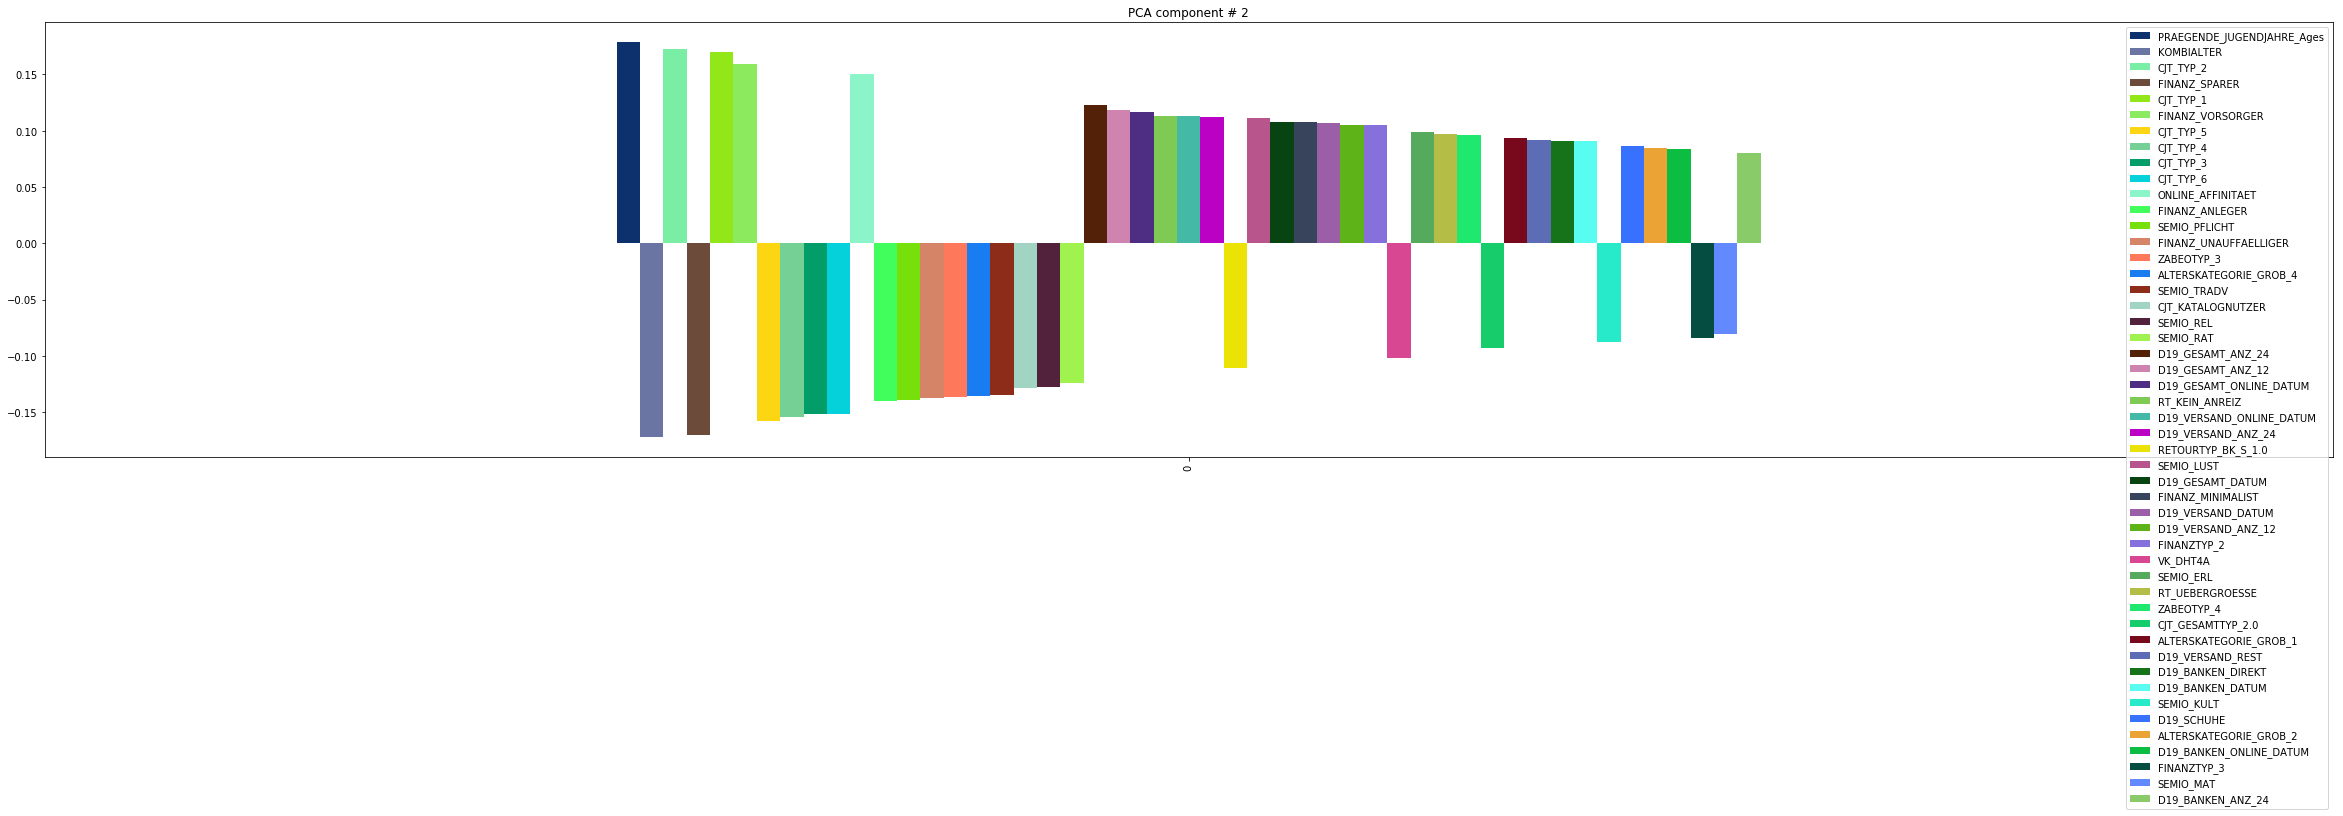

In [117]:
dsh.AnalyzePCAResult(pcaReduced, 1, azClust)

In [118]:
_ = AnalysePCAComponent(pcaReduced.components_, 2, 100, azClust, False)

---------- Component 2 ----------
Positive:  KBA13_HERST_BMW_BENZ 0.2017737656912757  - Negative:  KBA13_SITZE_5 -0.17290849742944106
Positive:  KBA13_MERCEDES 0.17437043403047467  - Negative:  KBA13_SEG_KLEINWAGEN -0.14216149758399277
Positive:  KBA13_SEG_OBEREMITTELKLASSE 0.1715452497055269  - Negative:  KBA13_HALTER_25 -0.1372210439470975
Positive:  KBA13_BMW 0.16651400186600218  - Negative:  KBA13_SEG_KOMPAKTKLASSE -0.13166516546725723
Positive:  KBA13_SITZE_4 0.16642582802987502  - Negative:  OST_WEST_KZ -0.12954452611109496
Positive:  KBA13_SEG_SPORTWAGEN 0.15689720304987867  - Negative:  KBA13_KMH_180 -0.1242414488427021
Positive:  KBA05_HERST1 0.13334151540020672  - Negative:  KBA13_HERST_ASIEN -0.12135006319562826
Positive:  KBA13_SEG_OBERKLASSE 0.13178978287707505  - Negative:  KBA13_HALTER_20 -0.11784670216167582
Positive:  KBA13_KW_121 0.13120573498557062  - Negative:  KBA13_FAB_ASIEN -0.11343571351357104
Positive:  KBA13_KMH_250 0.1286692270087988  - Negative:  KBA13_HERST

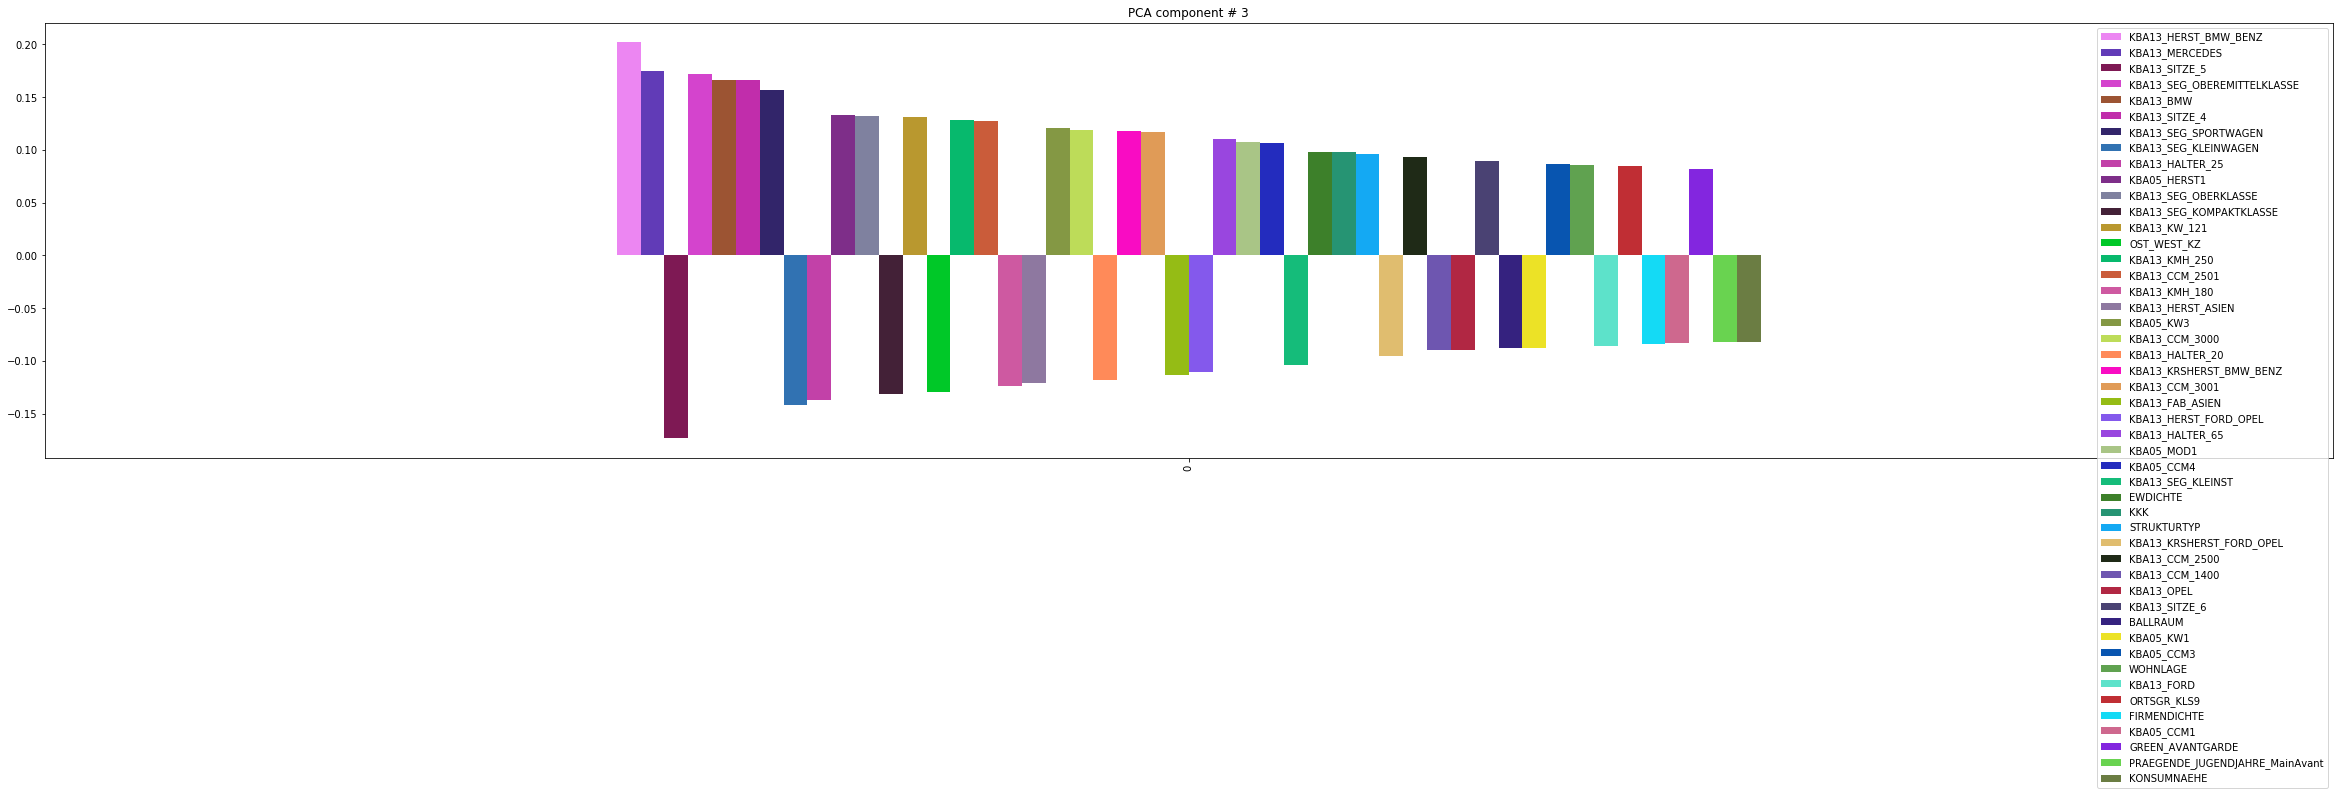

In [119]:
dsh.AnalyzePCAResult(pcaReduced, 2, azClust)

In [120]:
_ = AnalysePCAComponent(pcaReduced.components_, 3, 100, azClust, False)

---------- Component 3 ----------
Positive:  D19_GESAMT_ANZ_24 0.13904483275510843  - Negative:  VK_DISTANZ -0.12895997468320308
Positive:  D19_GESAMT_ANZ_12 0.13638121881082702  - Negative:  VK_ZG11 -0.1274909866796694
Positive:  D19_GESAMT_DATUM 0.13592923892992398  - Negative:  RT_KEIN_ANREIZ -0.1141437518030378
Positive:  D19_VERSAND_ANZ_24 0.13159789441174838  - Negative:  GEMEINDETYP -0.10440437223008843
Positive:  D19_VERSAND_DATUM 0.13076979767364663  - Negative:  VK_DHT4A -0.10433945582645858
Positive:  D19_VERSAND_ANZ_12 0.12615498653121696  - Negative:  PRAEGENDE_JUGENDJAHRE_Ages -0.10407561223329304
Positive:  D19_GESAMT_ONLINE_DATUM 0.12564039212613104  - Negative:  CJT_TYP_1 -0.1019872855488822
Positive:  D19_VERSAND_ONLINE_DATUM 0.12090094359905851  - Negative:  FINANZ_VORSORGER -0.10116070940605379
Positive:  KOMBIALTER 0.11621128136667655  - Negative:  KBA13_AUTOQUOTE -0.10002700034284931
Positive:  FINANZ_UNAUFFAELLIGER 0.11379548914683799  - Negative:  KBA13_ANTG1 -0

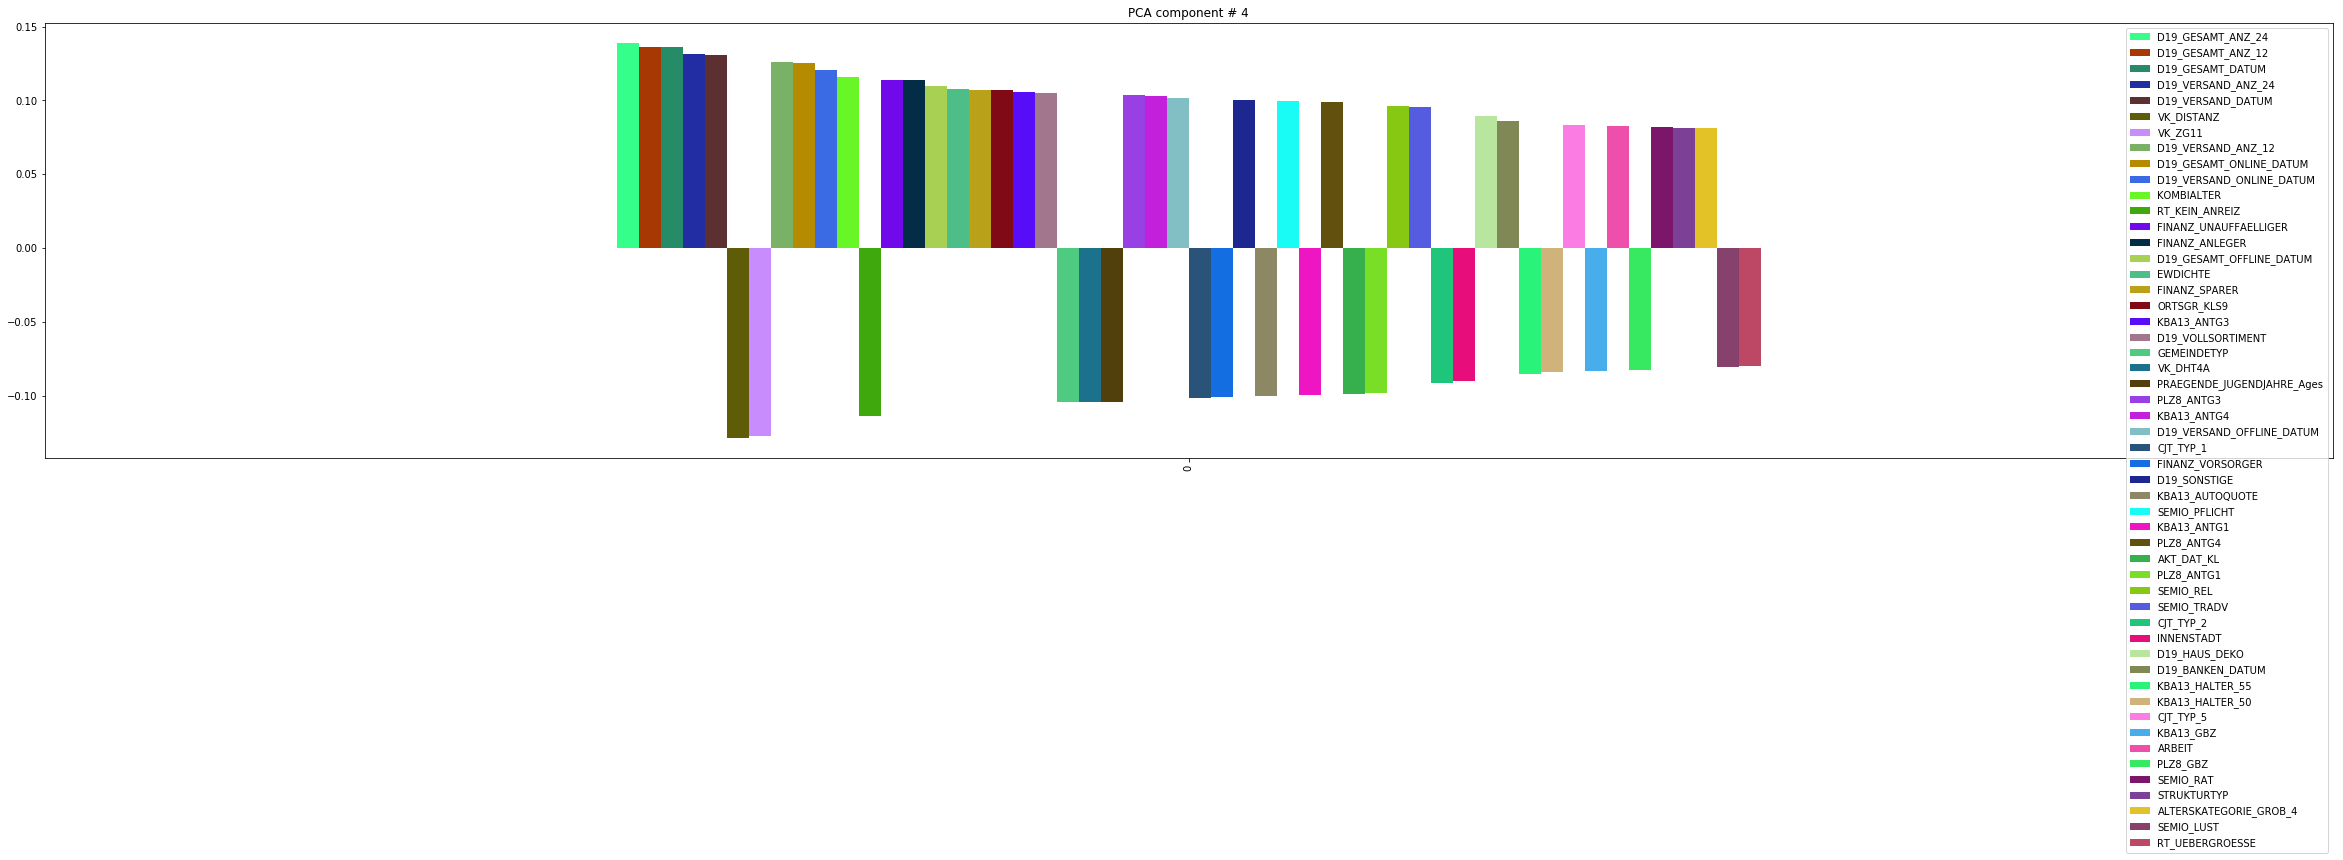

In [121]:
dsh.AnalyzePCAResult(pcaReduced, 3, azClust)

With PCA we found our N vectors with that we can explain our dataset up to 90%. A vector is a principal component and equal to an eigen vector of the data matrix. Each entry in an eigen vector represents a feature. The higher the absulte, the higher the feature is driving this component (having an large influence on the pc/vectors direction).

Two features both having positive signs means that they are positively correlated. That means if feature X increases, then feature Y increates.
On the other hand there might be negatively correlated features and that means if X increaes, Y decreases.

I will interpret the first three components.

PCA 0: This component describes people who 
- tend to live in areas with an high share of 1-2 family-houses and low share of >5 family houses in the micro/macro cell and the plz 8 region, be homeowners/top earners, with a low movement rate and a lower population density, have a higher income and don't tend to be no financial minimalists.

This feature describes setteled families with an income over average don't having any financial problems.


PCA 1: People described by this component
- are more likely to be advertising and consumption minimalist/traditionalists than advertisingintereset or cross-channel enthusiasts, but showing a high online affinity, they do not tend to be a money safer, investor or inconspicuous but rather to be financially prepared, and the 80s/90s were the dominating movement in the persons youth.

This feature describes persons who like to drive fast cars (but I would rather describe them as poser).


PCA 2: The score for this component increases when people
- seem to be those who have expensive cars (very likely to be sport cars because this component says it's very unlikely that these cars have five or four seats), the engines in those cars tend to be huge (over 2500ccm) and the maximum speeds tends to be over 250km rather than limited to 210 km/h, it's very unlikely that those persons tend to be under 30 years, they tend to be over 60, the manufacturers Opel, Ford, and asia pacific cars are rarely present.

This feature describes older persons who tend to be pensioners and like to drive fast sport cars.

### Clustering - KMeans

Now I use KMeans to find centroids in the pca transformed data.

In [122]:
def ClusterData(data, maxClusterSize = 20, minClusterSize = 2):
    '''
    Uses kmeans to cluster data.
    
    INPUT: 
    data: Dataframe
    maxClusterSize: max number of clusters to calculate
    '''
    km = []
    kAverages = []
    kPredicts = []
    kInertia = []

    dsh.PrintLine()
    
    tmpData = data
    
    clusterNumbers = list(np.arange(minClusterSize, maxClusterSize + 1, 1))
    for ind in clusterNumbers:
        start = datetime.now()
        print('Prediction for {} clusters started {}'.format(ind, start))

        kmeans = KMeans(n_clusters = ind, random_state = 47, n_jobs = -1)

        kPredicts.append(kmeans.fit_predict(tmpData))

        # compute the average within-cluster distances.
        tmpAver = abs((kmeans.score(tmpData)))
        kAverages.append(tmpAver)
        kInertia.append(kmeans.inertia_)
        km.append(kmeans)

        dsh.PrintLine('Prediction for {} clusters with average {} took: {}'.format(ind, tmpAver, datetime.now() - start))
        dsh.PrintLine()
    print('-' * 40)
    
    return km, kAverages, kPredicts, kInertia

def ClusterDataMini(data, maxClusterSize = 25, minClusterSize = 2):
    '''
    Uses kmeans to cluster data.
    
    INPUT: 
    data: Dataframe
    maxClusterSize: max number of clusters to calculate
    '''
    km = []
    kAverages = []
    kPredicts = []
    kInertia = []

    dsh.PrintLine()
    
    tmpData = data
    
    clusterNumbers = list(np.arange(minClusterSize, maxClusterSize + 1, 1))
    for ind in clusterNumbers:
        start = datetime.now()
        print('Prediction for {} clusters started {}'.format(ind, start))

        kmeans = MiniBatchKMeans(n_clusters = ind, random_state = 47)

        kPredicts.append(kmeans.fit_predict(tmpData))

        # compute the average within-cluster distances.
        tmpAver = abs((kmeans.score(tmpData)))
        kAverages.append(tmpAver)
        kInertia.append(kmeans.inertia_)
        km.append(kmeans)

        dsh.PrintLine('Prediction for {} clusters with average {} took: {}'.format(ind, tmpAver, datetime.now() - start))
        dsh.PrintLine()
    print('-' * 40)
    
    return km, kAverages, kPredicts, kInertia

def PlotKMeanScores(results, maxClusterSize):
    '''
    Plot KMean results.
    results: Array where [1] contains scores
    maxClusterSize: Used clusters
    '''
    plt.figure(figsize = (15, 10))
    plt.ylabel('Cluster Score')
    plt.xlabel('Clusters')
    plt.ylim(int(min(results[1])) - 5, int(max(results[1])) + 5, 5)

    #x=[2*v for v in range(10)]
    ticks = [2 * v for v in range(int(maxClusterSize / 2) - 1)]
    tick2 = [2 * (v + 1) for v in range(int(maxClusterSize / 2) - 1)]

    plt.xticks(ticks, tick2)
    plt.style.context('seaborn-whitegrid')
    _ = plt.plot(results[1], marker = 'o', color = 'b')

In [123]:
kmMini = ClusterDataMini(azPcaReduced, maxClusterSize = 40)

-------------------- - --------------------
Prediction for 2 clusters started 2018-12-23 14:16:36.480978
-------------------- Prediction for 2 clusters with average 250462491.97177148 took: 0:00:02.592615 --------------------
-------------------- - --------------------
Prediction for 3 clusters started 2018-12-23 14:16:39.073593
-------------------- Prediction for 3 clusters with average 244755581.07988748 took: 0:00:02.626487 --------------------
-------------------- - --------------------
Prediction for 4 clusters started 2018-12-23 14:16:41.700080
-------------------- Prediction for 4 clusters with average 240564773.71722028 took: 0:00:02.973831 --------------------
-------------------- - --------------------
Prediction for 5 clusters started 2018-12-23 14:16:44.674907
-------------------- Prediction for 5 clusters with average 235736882.52675992 took: 0:00:03.426429 --------------------
-------------------- - --------------------
Prediction for 6 clusters started 2018-12-23 14:16:4

-------------------- Prediction for 38 clusters with average 209690853.43947157 took: 0:00:06.134112 --------------------
-------------------- - --------------------
Prediction for 39 clusters started 2018-12-23 14:19:24.850783
-------------------- Prediction for 39 clusters with average 209879470.68293124 took: 0:00:05.749483 --------------------
-------------------- - --------------------
Prediction for 40 clusters started 2018-12-23 14:19:30.600266
-------------------- Prediction for 40 clusters with average 208961569.4231947 took: 0:00:06.290111 --------------------
-------------------- - --------------------
----------------------------------------


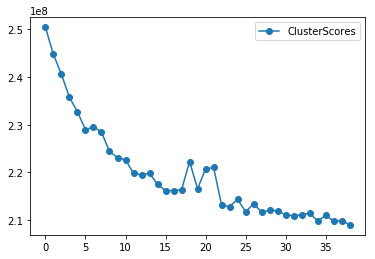

In [124]:
pd.DataFrame(kmMini[1], columns = ['ClusterScores']).plot(marker = 'o')

As it is not easy to see which cluster size is the best, I implemented this mathematical approach: https://www.linkedin.com/pulse/finding-optimal-number-clusters-k-means-through-elbow-asanka-perera/

In [125]:
def FindBestCluster(kAverages, nbrClusters, nbrMinClusters = 2):
    # Find Point p with max(dist(p, L)) where L = Line between P_c2 and P_cNbrClusters
    '''
    y = mx + b
    m = (y2 - y1) / (x2 - x1) where x2 > x1
    b = y - mx
    '''
    m = (kAverages[len(kAverages) - 1] - kAverages[0]) / (nbrClusters - nbrMinClusters)
    b = kAverages[len(kAverages) - 1] - m * nbrClusters

    m_ = -1 / m
    maxDist = 0
    print('-' * 40)

    for ind in range(len(kAverages)):
        x = ind + 2
        y = kAverages[ind]

        # Calculate new line
        b_ = y - m_ * x

        # Calc cut: m*x + b = m_*x + b_
        # <=> b - b_ = x * (m_ - m)
        # <=> x = (b - b_) / (m_ - m)
        cut_x = (b - b_) / (m_ - m)
        cut_y = m * cut_x + b

        # Distance: sqrt(x^2 + y^2)
        dist = math.sqrt((cut_x - x) * (cut_x - x) + (cut_y - y) * (cut_y - y))

        print('Distance P{} ({} cluster) to line: '.format(ind, x), dist)

        if dist > maxDist:
            maxDist = dist
            _usedComponents2 = ind
        elif dist <= maxDist:
            continue
    
    return _usedComponents2 + nbrMinClusters

In [130]:
nbrUsedCluster = FindBestCluster(kmMini[1], nbrMinClusters = 2, nbrClusters = 40)
nbrUsedCluster

----------------------------------------
Distance P0 (2 cluster) to line:  6.8833827526759706e-15
Distance P1 (3 cluster) to line:  4.225488990941859
Distance P2 (4 cluster) to line:  7.0627694657289375
Distance P3 (5 cluster) to line:  10.483390839210323
Distance P4 (6 cluster) to line:  12.24415904766972
Distance P5 (7 cluster) to line:  14.697100033224016
Distance P6 (8 cluster) to line:  13.161124352629729
Distance P7 (9 cluster) to line:  13.146821159547567
Distance P8 (10 cluster) to line:  15.882911463345668
Distance P9 (11 cluster) to line:  16.061599602006073
Distance P10 (12 cluster) to line:  15.46268539782438
Distance P11 (13 cluster) to line:  17.093643174215742
Distance P12 (14 cluster) to line:  16.374564614267484
Distance P13 (15 cluster) to line:  15.077239756873887
Distance P14 (16 cluster) to line:  16.222034307653114
Distance P15 (17 cluster) to line:  16.409742661223202
Distance P16 (18 cluster) to line:  15.386941161681944
Distance P17 (19 cluster) to line:  14.24

13

My approach says that 13 clusters shall be used. So I fit KMeans to 13 clusters.

In [131]:
# kmWork = kmResultWholeSet[0][4]
kmWork = KMeans(n_clusters = nbrUsedCluster, random_state = 47, n_jobs = -1)

kmWork.fit_transform(azPcaReduced)

array([[23.06062101, 24.76203164, 20.36954698, ..., 25.20527849,
        25.58153566, 23.83524529],
       [16.90875781, 18.01641645, 16.30223229, ..., 18.04084951,
        20.0773296 , 16.65628378],
       [17.32545866, 16.80166195, 19.22008776, ..., 16.68626314,
        20.42917505, 13.85659773],
       ...,
       [15.71399428, 18.72412166, 19.60563543, ..., 18.12826919,
        18.96408993, 17.69165413],
       [21.80369253, 21.47814676, 21.47383365, ..., 23.88490008,
        24.12438763, 22.61247606],
       [19.38742995, 17.03113764, 18.28008712, ..., 19.21130778,
        21.76681944, 15.46705076]])

In [132]:
len(kmWork.cluster_centers_)

13

### Cluster Customers

In [133]:
cusClust = PrepareForSegmentation(customers)

for col in cusClust.columns:
    if not col in azClust:
        print('Column not contained, adding with default value 0: ', col)
        dfClustCustomer[col] = 0

-------------------- Start converting missing values to nan --------------------
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 50554 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 50554 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0'] - 48990 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 871 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 934 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_DIESEL - ['-1', -1.0, '-1.0', '9', 

-------------------- Convert undocumented values to nan --------------------
KBA05_MODTEMP  creplace value:  6
LP_FAMILIE_FEIN  creplace value:  0
LP_FAMILIE_GROB  creplace value:  0
LP_LEBENSPHASE_FEIN  creplace value:  0
LP_LEBENSPHASE_GROB  creplace value:  0
ORTSGR_KLS9  creplace value:  0
-------------------- Update values based on other columns --------------------
-------------------- Finished --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['LNR', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE', 'VERDICHTUNGSRAUM', 'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'D19_KONSUMTYP_M

-------------------- - --------------------
current column:  D19_BEKLEIDUNG_REST
-------------------- Applying reorder on D19_BEKLEIDUNG_REST: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_BILDUNG
-------------------- Applying reorder on D19_BILDUNG: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_BIO_OEKO
-------------------- Applyin

-------------------- - --------------------
current column:  D19_REISEN
-------------------- Applying reorder on D19_REISEN: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_SAMMELARTIKEL
-------------------- Applying reorder on D19_SAMMELARTIKEL: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_SCHUHE
-------------------- Applying reorde

current column:  FINANZ_ANLEGER
-------------------- Applying reorder on FINANZ_ANLEGER: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'very high', 'high', 'average', 'low']
-------------------- - --------------------
current column:  FINANZ_HAUSBAUER
-------------------- Applying reorder on FINANZ_HAUSBAUER: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'very high', 'high', 'average', 'low']
-------------------- - --------------------
current column:  FINANZ_MINIMALIST
-------------------- Applying reorder on FINANZ_MINIMALIST: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'very high', 'high', 'average', 'low']
-------------------- - --------------------
current column:  FINANZ_SPARER
-------------------- Applying reorder on FINANZ_SPARER: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
H

-------------------- - --------------------
current column:  SEMIO_SOZ
-------------------- Applying reorder on SEMIO_SOZ: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_TRADV
-------------------- Applying reorder on SEMIO_TRADV: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_VERT
-------------------- Applying reorder on SEMIO_VERT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', '

-------------------- Start applying one-hot encoding on: ['ZABEOTYP'] --------------------
Columns before one hot encoding:  363
Columns to be removed and replaced:  ['ZABEOTYP']
Size after encoding:  368
Columns successfully one hot encoded :)  New columns are:  ['ZABEOTYP_1', 'ZABEOTYP_2', 'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5', 'ZABEOTYP_6']
Removed columns after one hot encoding:  ['ZABEOTYP']
-------------------- Finished applying one-hot encoding --------------------
-------------------- Start applying one-hot encoding on: ['FINANZTYP'] --------------------
Columns before one hot encoding:  368
Columns to be removed and replaced:  ['FINANZTYP']
Size after encoding:  373
Columns successfully one hot encoded :)  New columns are:  ['FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6']
Removed columns after one hot encoding:  ['FINANZTYP']
-------------------- Finished applying one-hot encoding --------------------
--------------------  ---------

In [134]:
custPca = Impute(cusClust, False)
custPca = Scale(custPca, False)

In [135]:
custPca = pcaReduced.transform(custPca.values)

In [136]:
kMeanPredictCust = kmWork.predict(custPca)

In [137]:
kMeanPredictAzdias = kmWork.predict(azPcaReduced)

In [138]:
np.bincount(kMeanPredictAzdias)

array([60391, 44341, 42406, 62148, 49102, 80985, 70448, 83235, 48478,
       74601, 55679, 28453, 84663], dtype=int64)

In [139]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

demBinCount = np.bincount(kMeanPredictAzdias)
demDic = {}
for ind in range(len(demBinCount)):
    demDic[ind] = demBinCount[ind] * 100 / azRun.shape[0]

In [140]:
custBinCount = np.bincount(kMeanPredictCust)
custDic = {}
for ind in range(len(custBinCount)):
    custDic[ind] = custBinCount[ind] * 100 / cusClust.shape[0]

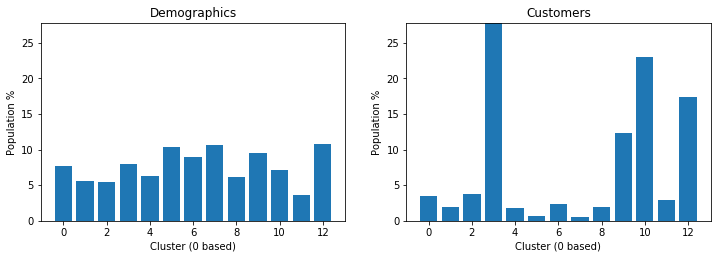

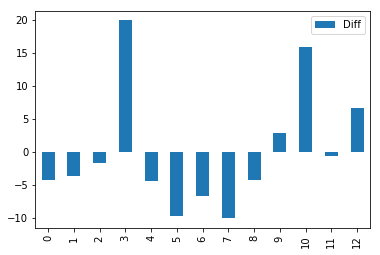

In [141]:
maxY = max([max(demDic.values()), max(custDic.values())])

fig1 = plt.figure(figsize = (12, 8))
ax1 = fig1.add_subplot(2, 2, 1)
plt.ylabel('Population %')
plt.xlabel('Cluster (0 based)')
plt.title('Demographics')
ax1.set_ylim(0, maxY)
_ = ax1.bar(list(demDic.keys()), list(demDic.values()))

ax2 = fig1.add_subplot(2, 2, 2)
plt.ylabel('Population %')
plt.xlabel('Cluster (0 based)')
plt.title('Customers')
ax2.set_ylim(0, maxY)
_ = plt.bar(list(custDic.keys()), list(custDic.values()))

clustDiff = []
for ind in range(0, len(custDic)):
    clustDiff.append(list(custDic.values())[ind] - list(demDic.values())[ind])   
ax = pd.DataFrame({'Diff' : clustDiff}).plot(kind='bar')

In [142]:
ovRep = {}
unRep = {}

limit = 0.3
limOv, limUn = 1 + limit, 1 - limit

for ind in range(len(custDic.keys())):
    tmp = custDic[ind] / demDic[ind]
    if tmp >= limOv:
        ovRep[ind] = tmp
    elif tmp <= limUn:
        unRep[ind] = tmp

print('-' * 40)
if len(ovRep) > 0 or len(unRep) > 0:
    if len(ovRep) > 0:
        print('Overrepresented clusters (index zero based): ', ovRep)
    if len(unRep) > 0:
        if len(ovRep) > 0:
            print('-' * 20)
        print('Underrepresented clusters (index zero based): ', unRep)
else:
    print('No over/underrepresented clusters found.')
print('-' * 40)

----------------------------------------
Overrepresented clusters (index zero based):  {3: 3.508015362018516, 10: 3.242881757051855, 12: 1.6118625112478298}
--------------------
Underrepresented clusters (index zero based):  {0: 0.44916675571332654, 1: 0.34483017173177616, 2: 0.6963591538355882, 4: 0.2869134918765929, 5: 0.0647142136088275, 6: 0.26408533252952476, 7: 0.05635119269558139, 8: 0.322703091553266}
----------------------------------------


In [143]:
# To get the original values back from a cluster center, I multiply center_element_i with pca_component_i (eigenvector)
# and sum it up to get the point in the original data.

def PrintClusterPcaAssigned(_clust):
    '''
    Print cluster components.
    _clust: Cluster center 
    '''
    dic = {}
    for ind, val in enumerate(list(_clust)):
        dic[val] = ind # dirty way, I know... 
    print('Weights for PCs with 0 based index:')
    for val in sorted(list(dic.keys())):
        print ('Weight for principal component ', dic[val], ': ', val)
    return


In [144]:
for ind, val in enumerate(kmWork.cluster_centers_):
    dsh.PrintLine('Cluster center {}'.format(ind))
    
    c3orig = pcaReduced.inverse_transform(val)
    invScale = CleanConfig.Scaler.inverse_transform(c3orig)
    
    for ind2 in range(len(invScale)):
        print(azClust.columns[ind2], ', ', invScale[ind2])

-------------------- Cluster center 0 --------------------
AKT_DAT_KL ,  3.3910257724928874
ANZ_HAUSHALTE_AKTIV ,  0.9685647143712918
ANZ_HH_TITEL ,  0.0055636499305575515
ANZ_KINDER ,  0.6218001464732668
ANZ_PERSONEN ,  2.564142837123481
ANZ_STATISTISCHE_HAUSHALTE ,  0.9465210368205033
ANZ_TITEL ,  0.002291529545279839
ARBEIT ,  2.562689809664444
BALLRAUM ,  4.9497175109045255
CJT_KATALOGNUTZER ,  2.0804688165362317
CJT_TYP_1 ,  4.338465181229363
CJT_TYP_2 ,  3.990467427817228
CJT_TYP_3 ,  2.606376613829225
CJT_TYP_4 ,  2.187184460921725
CJT_TYP_5 ,  2.593376806640481
CJT_TYP_6 ,  2.5920261972700436
D19_BANKEN_ANZ_12 ,  0.1100189086785232
D19_BANKEN_ANZ_24 ,  0.2716135224630052
D19_BANKEN_DATUM ,  2.1797851716205234
D19_BANKEN_DIREKT ,  0.9600363054721841
D19_BANKEN_GROSS ,  0.2927972706275757
D19_BANKEN_LOKAL ,  0.07982098212556803
D19_BANKEN_OFFLINE_DATUM ,  1.0961782564567886
D19_BANKEN_ONLINE_DATUM ,  1.9252495460704007
D19_BANKEN_REST ,  0.34159411820189867
D19_BEKLEIDUNG_GEH ,  

CAMEO_INTL_2015_Wealth_1.0 ,  0.16899836275944852
CAMEO_INTL_2015_Wealth_2.0 ,  0.36509810568267753
CAMEO_INTL_2015_Wealth_3.0 ,  0.06995719259151563
CAMEO_INTL_2015_Wealth_4.0 ,  0.2902633625955845
CAMEO_INTL_2015_Wealth_5.0 ,  0.088795960920516
CJT_GESAMTTYP_1.0 ,  0.1542197548221645
CJT_GESAMTTYP_2.0 ,  0.2643251089720432
CJT_GESAMTTYP_3.0 ,  0.13598367427551644
CJT_GESAMTTYP_4.0 ,  0.24189087559308078
CJT_GESAMTTYP_5.0 ,  0.1154766223474193
CJT_GESAMTTYP_6.0 ,  0.08315312508514477
GFK_URLAUBERTYP_1.0 ,  0.05835504835562839
GFK_URLAUBERTYP_2.0 ,  0.0974793993663788
GFK_URLAUBERTYP_3.0 ,  0.03818250856802459
GFK_URLAUBERTYP_4.0 ,  0.04991744502391089
GFK_URLAUBERTYP_5.0 ,  0.1766644699737293
GFK_URLAUBERTYP_6.0 ,  0.05878316366829993
GFK_URLAUBERTYP_7.0 ,  0.10368727278759104
GFK_URLAUBERTYP_8.0 ,  0.05329605459548783
GFK_URLAUBERTYP_9.0 ,  0.11855776983741445
GFK_URLAUBERTYP_10.0 ,  0.012264411746057927
GFK_URLAUBERTYP_11.0 ,  0.09036930416277487
GFK_URLAUBERTYP_12.0 ,  0.1374923130

MIN_GEBAEUDEJAHR ,  7.597779921310768
MOBI_RASTER ,  3.1177184712040664
MOBI_REGIO ,  3.0443688861750564
ONLINE_AFFINITAET ,  2.6887774202466788
ORTSGR_KLS9 ,  5.879729754808601
PLZ8_ANTG1 ,  2.7289759614769076
PLZ8_ANTG2 ,  2.6677612133836015
PLZ8_ANTG3 ,  1.2842174140784874
PLZ8_ANTG4 ,  0.44494014899231016
PLZ8_GBZ ,  3.880062691033286
PLZ8_HHZ ,  3.7450001940731963
REGIOTYP ,  4.793873073287332
RELAT_AB ,  3.0816936872447456
RT_KEIN_ANREIZ ,  2.0573152226716953
RT_SCHNAEPPCHEN ,  4.365480480279306
RT_UEBERGROESSE ,  2.7594204494126595
SEMIO_DOM ,  3.3893977315355817
SEMIO_ERL ,  3.0569479232799344
SEMIO_FAM ,  4.31257384895727
SEMIO_KAEM ,  3.913686567658478
SEMIO_KRIT ,  3.5321935762028
SEMIO_KULT ,  4.3407914054323244
SEMIO_LUST ,  2.672637940002613
SEMIO_MAT ,  4.642449756963488
SEMIO_PFLICHT ,  4.825355427460545
SEMIO_RAT ,  4.861200176109171
SEMIO_REL ,  4.881684794317588
SEMIO_SOZ ,  3.7733756515487777
SEMIO_TRADV ,  4.898973920686009
SEMIO_VERT ,  3.1293112204457865
SHOPPER_

KBA05_MOD4 ,  2.612923911132139
KBA05_MOD8 ,  0.8876925016740305
KBA05_MODTEMP ,  3.1738203207167994
KBA05_MOTRAD ,  0.63205054629824
KBA05_VORB0 ,  2.2153146625208224
KBA05_VORB1 ,  2.913955818362318
KBA05_VORB2 ,  3.5675183766720906
KBA05_ZUL1 ,  3.6554431484192476
KBA05_ZUL2 ,  2.725078801385623
KBA05_ZUL3 ,  2.0385990711548923
KBA05_ZUL4 ,  1.496092399044111
KBA13_ANTG1 ,  1.178581109637597
KBA13_ANTG2 ,  3.2502421686683887
KBA13_ANTG3 ,  2.6426560843789777
KBA13_ANTG4 ,  1.470501264497852
KBA13_ANZAHL_PKW ,  5.9897774918253655
KBA13_AUDI ,  2.6752688631686867
KBA13_AUTOQUOTE ,  1.7137225492352877
KBA13_BJ_1999 ,  3.5020674139160675
KBA13_BJ_2000 ,  3.779561765383897
KBA13_BJ_2004 ,  2.6766122864996635
KBA13_BJ_2006 ,  2.4512433880785327
KBA13_BJ_2008 ,  1.7821521516348566
KBA13_BJ_2009 ,  1.8298340476099968
KBA13_BMW ,  3.1550783731241006
KBA13_CCM_1000 ,  2.852987788410612
KBA13_CCM_1200 ,  2.649794026947623
KBA13_CCM_1400 ,  3.2288959713212093
KBA13_CCM_1500 ,  2.454665194237061

FINANZ_SPARER ,  1.7146047813021608
FINANZ_UNAUFFAELLIGER ,  1.7833422612283394
FINANZ_VORSORGER ,  3.9331062283328673
FIRMENDICHTE ,  3.690048857137921
GEBURTSJAHR ,  1115.1925429309665
GEMEINDETYP ,  4.3126459869408516
HH_EINKOMMEN_SCORE ,  2.4254112011266065
INNENSTADT ,  5.308275072001014
KBA05_ALTER1 ,  1.984016271239421
KBA05_ALTER2 ,  3.1251148069793886
KBA05_ALTER3 ,  3.0180836077715605
KBA05_ALTER4 ,  2.722660317669161
KBA05_ANHANG ,  1.1651973708545014
KBA05_ANTG1 ,  1.782813126590065
KBA05_ANTG2 ,  1.5264975354045387
KBA05_ANTG3 ,  0.4750669164487292
KBA05_ANTG4 ,  0.12023350358902113
KBA05_AUTOQUOT ,  3.338666407336743
KBA05_CCM1 ,  2.8980983924866184
KBA05_CCM2 ,  2.938848759157491
KBA05_CCM3 ,  3.1715872593265106
KBA05_CCM4 ,  1.2387722866354038
KBA05_DIESEL ,  2.2199837889298677
KBA05_FRAU ,  3.0344029431935375
KBA05_GBZ ,  3.4962068854056483
KBA05_HERST1 ,  2.3693935480597617
KBA05_HERST2 ,  3.112531331265622
KBA05_HERST3 ,  2.9750509019705995
KBA05_HERST4 ,  2.77864573

KBA13_GBZ ,  2.921444757129159
KBA13_HALTER_20 ,  2.600248128159303
KBA13_HALTER_25 ,  2.8100704421301006
KBA13_HALTER_30 ,  3.235549571204215
KBA13_HALTER_35 ,  3.3442506968011836
KBA13_HALTER_40 ,  3.2196135632859395
KBA13_HALTER_45 ,  2.9570019558663865
KBA13_HALTER_50 ,  2.376576437542811
KBA13_HALTER_55 ,  2.401685936154743
KBA13_HALTER_60 ,  2.519864302983923
KBA13_HALTER_65 ,  3.3665085696288806
KBA13_HALTER_66 ,  3.392366911949866
KBA13_HERST_ASIEN ,  3.0727659149185453
KBA13_HERST_AUDI_VW ,  2.714536058675648
KBA13_HERST_BMW_BENZ ,  3.352823803451785
KBA13_HERST_EUROPA ,  3.161107009006454
KBA13_HERST_FORD_OPEL ,  3.0637221090901954
KBA13_HERST_SONST ,  2.8291185950677873
KBA13_HHZ ,  3.6931006989751127
KBA13_KMH_110 ,  1.2855713936805007
KBA13_KMH_140 ,  2.8098091034674795
KBA13_KMH_180 ,  3.1204415231798897
KBA13_KMH_210 ,  2.8474800904115014
KBA13_KMH_250 ,  2.299640495942164
KBA13_KMH_251 ,  1.1952270976450772
KBA13_KRSAQUOT ,  2.6272468849089257
KBA13_KRSHERST_AUDI_VW ,  

GEBURTSJAHR ,  1676.7281187418293
GEMEINDETYP ,  4.1419041488533
HH_EINKOMMEN_SCORE ,  3.2743223451281476
INNENSTADT ,  5.0730488098163224
KBA05_ALTER1 ,  1.825444781974493
KBA05_ALTER2 ,  3.060221936997831
KBA05_ALTER3 ,  3.110849178337087
KBA05_ALTER4 ,  2.848266427866479
KBA05_ANHANG ,  1.2585293272121185
KBA05_ANTG1 ,  2.0527822087336407
KBA05_ANTG2 ,  1.2432791446640168
KBA05_ANTG3 ,  0.30051109583257024
KBA05_ANTG4 ,  0.0996493851381576
KBA05_AUTOQUOT ,  3.539307533427948
KBA05_CCM1 ,  2.9265682540048314
KBA05_CCM2 ,  2.948110838408738
KBA05_CCM3 ,  3.124972504469314
KBA05_CCM4 ,  1.2725728403996883
KBA05_DIESEL ,  2.1809139257364967
KBA05_FRAU ,  2.994959185106237
KBA05_GBZ ,  3.682737175238398
KBA05_HERST1 ,  2.395021531521183
KBA05_HERST2 ,  3.0455770045171247
KBA05_HERST3 ,  2.966090537329867
KBA05_HERST4 ,  2.8244659993472117
KBA05_HERST5 ,  2.778786920464131
KBA05_HERSTTEMP ,  3.1906054972246407
KBA05_KRSAQUOT ,  3.296945377385508
KBA05_KRSHERST1 ,  2.998955054043979
KBA05_

In [154]:
PrintClusterPcaAssigned(kmWork.cluster_centers_[3])

Weights for PCs with 0 based index:
Weight for principal component  1 :  -3.85786517496719
Weight for principal component  6 :  -1.3480889755915195
Weight for principal component  13 :  -0.6235607331180043
Weight for principal component  37 :  -0.22437140583854806
Weight for principal component  52 :  -0.20262027479353475
Weight for principal component  17 :  -0.17315710071798052
Weight for principal component  56 :  -0.1606040195075363
Weight for principal component  46 :  -0.14064396109608848
Weight for principal component  48 :  -0.13636296843132922
Weight for principal component  124 :  -0.13127342516731405
Weight for principal component  9 :  -0.12980458559531105
Weight for principal component  35 :  -0.11677689027594222
Weight for principal component  68 :  -0.11145807261014894
Weight for principal component  24 :  -0.11005702432358612
Weight for principal component  11 :  -0.10908405868975347
Weight for principal component  18 :  -0.10711825105388018
Weight for principal compone

In [155]:
PrintClusterPcaAssigned(kmWork.cluster_centers_[10])

Weights for PCs with 0 based index:
Weight for principal component  10 :  -1.2800992172779786
Weight for principal component  9 :  -1.113802537029877
Weight for principal component  5 :  -0.6674135262761625
Weight for principal component  4 :  -0.6606105072628136
Weight for principal component  8 :  -0.4124639359440766
Weight for principal component  15 :  -0.34199042469411156
Weight for principal component  6 :  -0.32785260466704047
Weight for principal component  23 :  -0.3197408894461917
Weight for principal component  2 :  -0.2912576569141956
Weight for principal component  34 :  -0.23991033565457237
Weight for principal component  18 :  -0.22707068393355478
Weight for principal component  28 :  -0.22211280868321726
Weight for principal component  27 :  -0.21330500403099364
Weight for principal component  32 :  -0.189189885833527
Weight for principal component  39 :  -0.179756501769028
Weight for principal component  61 :  -0.17936370703792776
Weight for principal component  138 : 

In [156]:
PrintClusterPcaAssigned(kmWork.cluster_centers_[5])

Weights for PCs with 0 based index:
Weight for principal component  0 :  -7.7241095844582
Weight for principal component  5 :  -1.2078724887308687
Weight for principal component  3 :  -0.8036553745565947
Weight for principal component  11 :  -0.49592199256611746
Weight for principal component  6 :  -0.3909128537487533
Weight for principal component  19 :  -0.3390934244571922
Weight for principal component  10 :  -0.3340712516166732
Weight for principal component  13 :  -0.2838771002605699
Weight for principal component  14 :  -0.25076177416951057
Weight for principal component  8 :  -0.24969271540710541
Weight for principal component  9 :  -0.24765896171571747
Weight for principal component  47 :  -0.19455337238471124
Weight for principal component  32 :  -0.17567456077307117
Weight for principal component  46 :  -0.1686653077474628
Weight for principal component  30 :  -0.16387708921924693
Weight for principal component  23 :  -0.14400253173290417
Weight for principal component  34 : 

In [157]:
PrintClusterPcaAssigned(kmWork.cluster_centers_[7])

Weights for PCs with 0 based index:
Weight for principal component  3 :  -5.441957887983224
Weight for principal component  7 :  -0.5071227975495872
Weight for principal component  0 :  -0.3324716825874422
Weight for principal component  6 :  -0.2412504939056014
Weight for principal component  17 :  -0.19985601737948627
Weight for principal component  29 :  -0.19287267721108414
Weight for principal component  27 :  -0.18824874664907482
Weight for principal component  35 :  -0.17191322133934067
Weight for principal component  14 :  -0.14641049163705236
Weight for principal component  31 :  -0.13399512287276968
Weight for principal component  37 :  -0.13038594805029477
Weight for principal component  18 :  -0.10505317613172788
Weight for principal component  28 :  -0.09954266163073275
Weight for principal component  124 :  -0.09415701513074438
Weight for principal component  108 :  -0.09273198606310293
Weight for principal component  125 :  -0.0884051470381604
Weight for principal compon

In [158]:
cusRun['Cluster'] = kMeanPredictCust

In [159]:
azRun['Cluster'] = kMeanPredictAzdias

In [160]:
def PlotCompareClust(df1, df2, df3, df4, columns, kind = 'Bar', fzh = 6, name1 = 'Underrepresented', name2 = 'Overrepresented'):
    '''
    Compare clusters via value counts.
    
    INPUT:
    df1..4: Dataframes
    kind: kind for plot
    fzh: Figure seize height
    name1,2: Titles for left and right
    '''
    lim = 1
    fzh = len(columns) * fzh + 4
    v, h = len(columns), 4
    plt.figure(figsize = (20, fzh - 2))
    for ind, col in enumerate(columns):
        for ind2, df in enumerate([df1, df2, df3, df4]):
            plt.subplot(v, h, h * ind + ind2 + 1)
            ax = (df[col].value_counts().sort_index() / df.shape[0] * 100).plot(kind = kind)
            name = name1 if ind2 < 2 else name2
            ax.set_title(col + '\n{}'.format(name))
            ax.set_ylabel('Percent of whole data set')
            ax.set_ylim(0, 100)

In [161]:
ur1 = azRun[azRun['Cluster'] == 5]
ur2 = azRun[azRun['Cluster'] == 7]
or1 = azRun[azRun['Cluster'] == 3]
or2 = azRun[azRun['Cluster'] == 10]

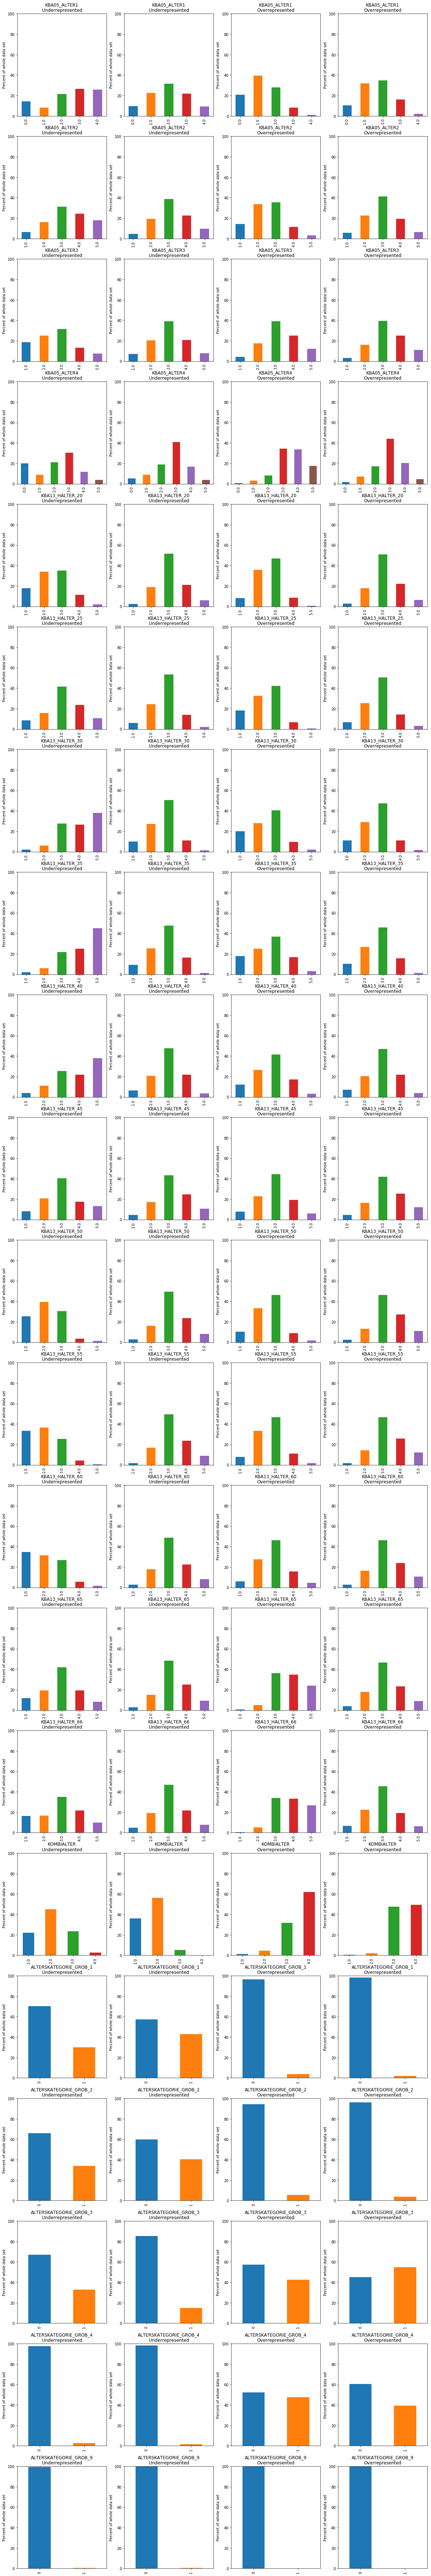

In [162]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, '*alter*'))

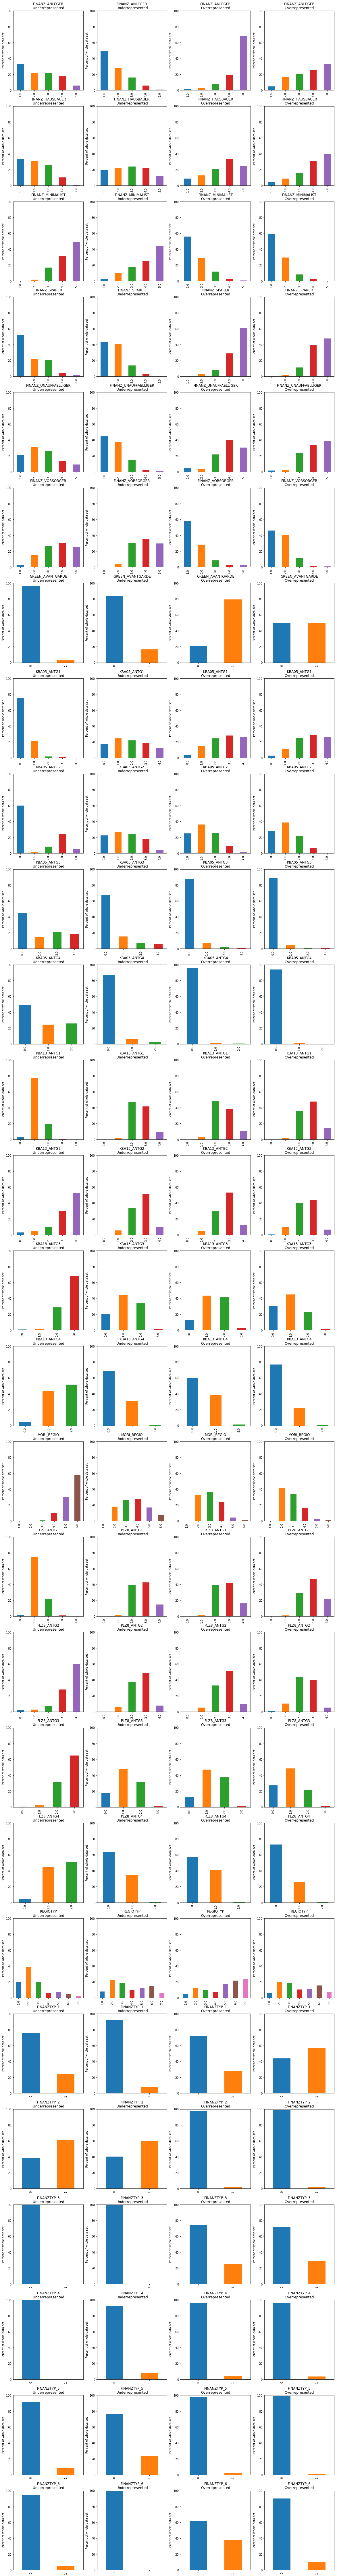

In [163]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*finanz*', '*reg*', '*antg*']))

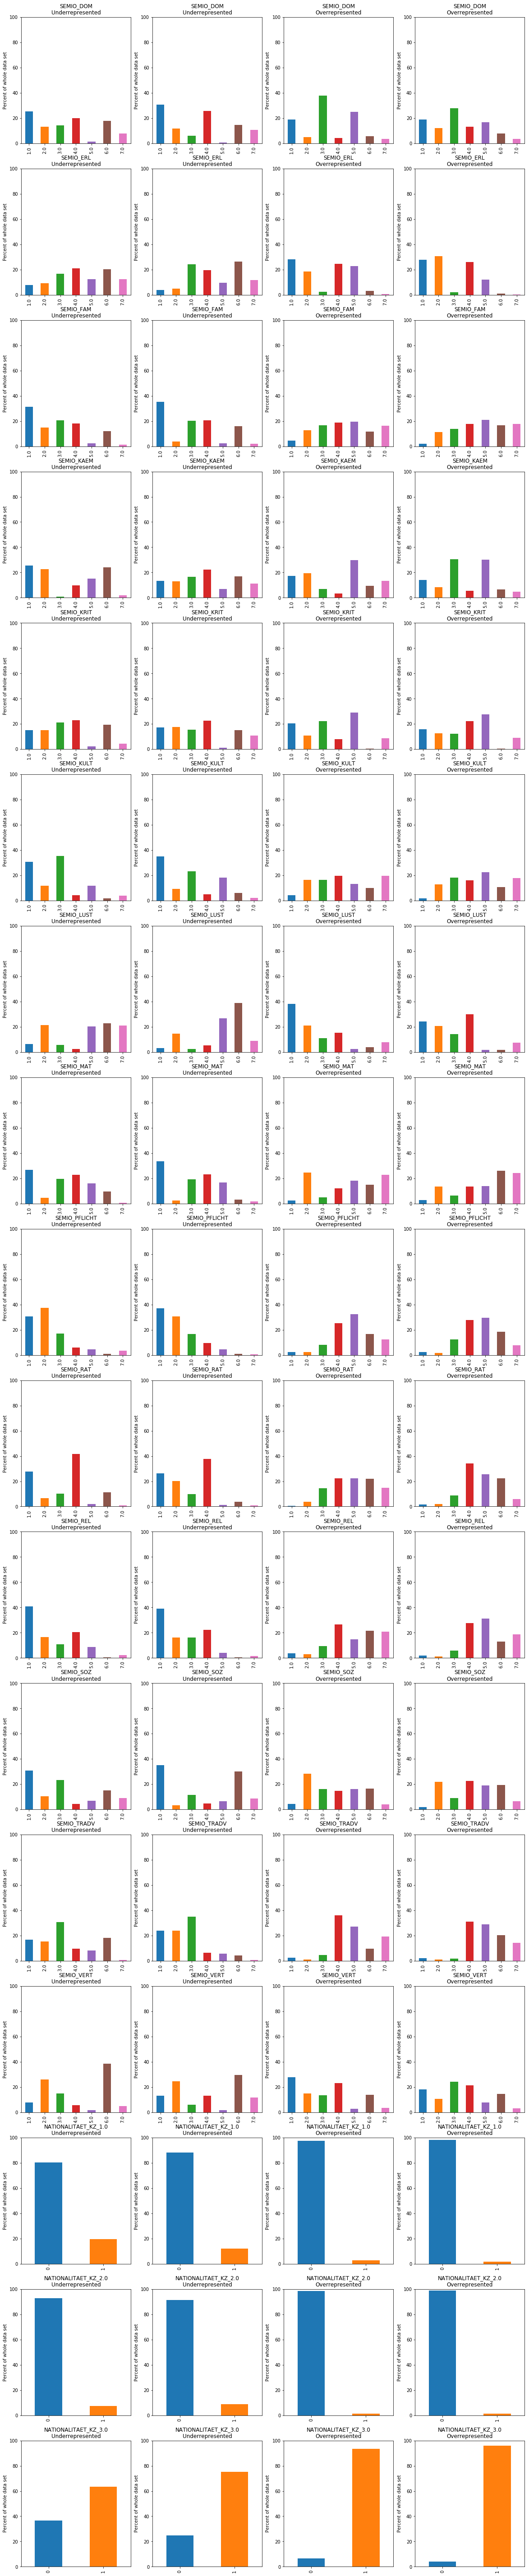

In [164]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*nat*', '*semio*']))

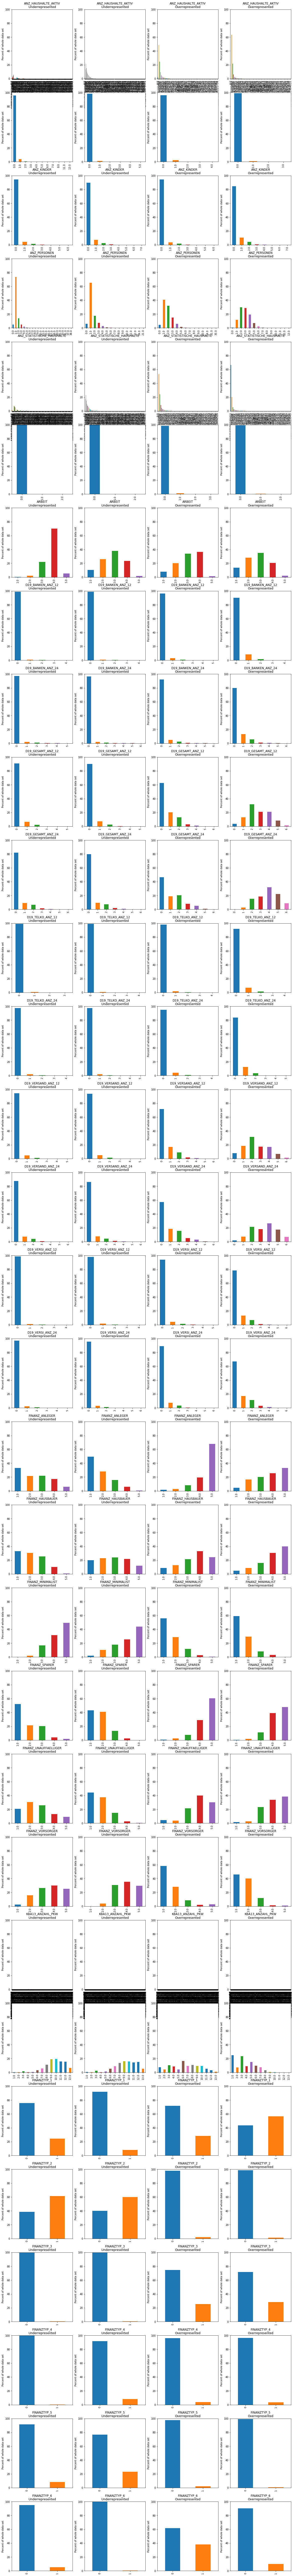

In [165]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*anz*', '*arb*']))

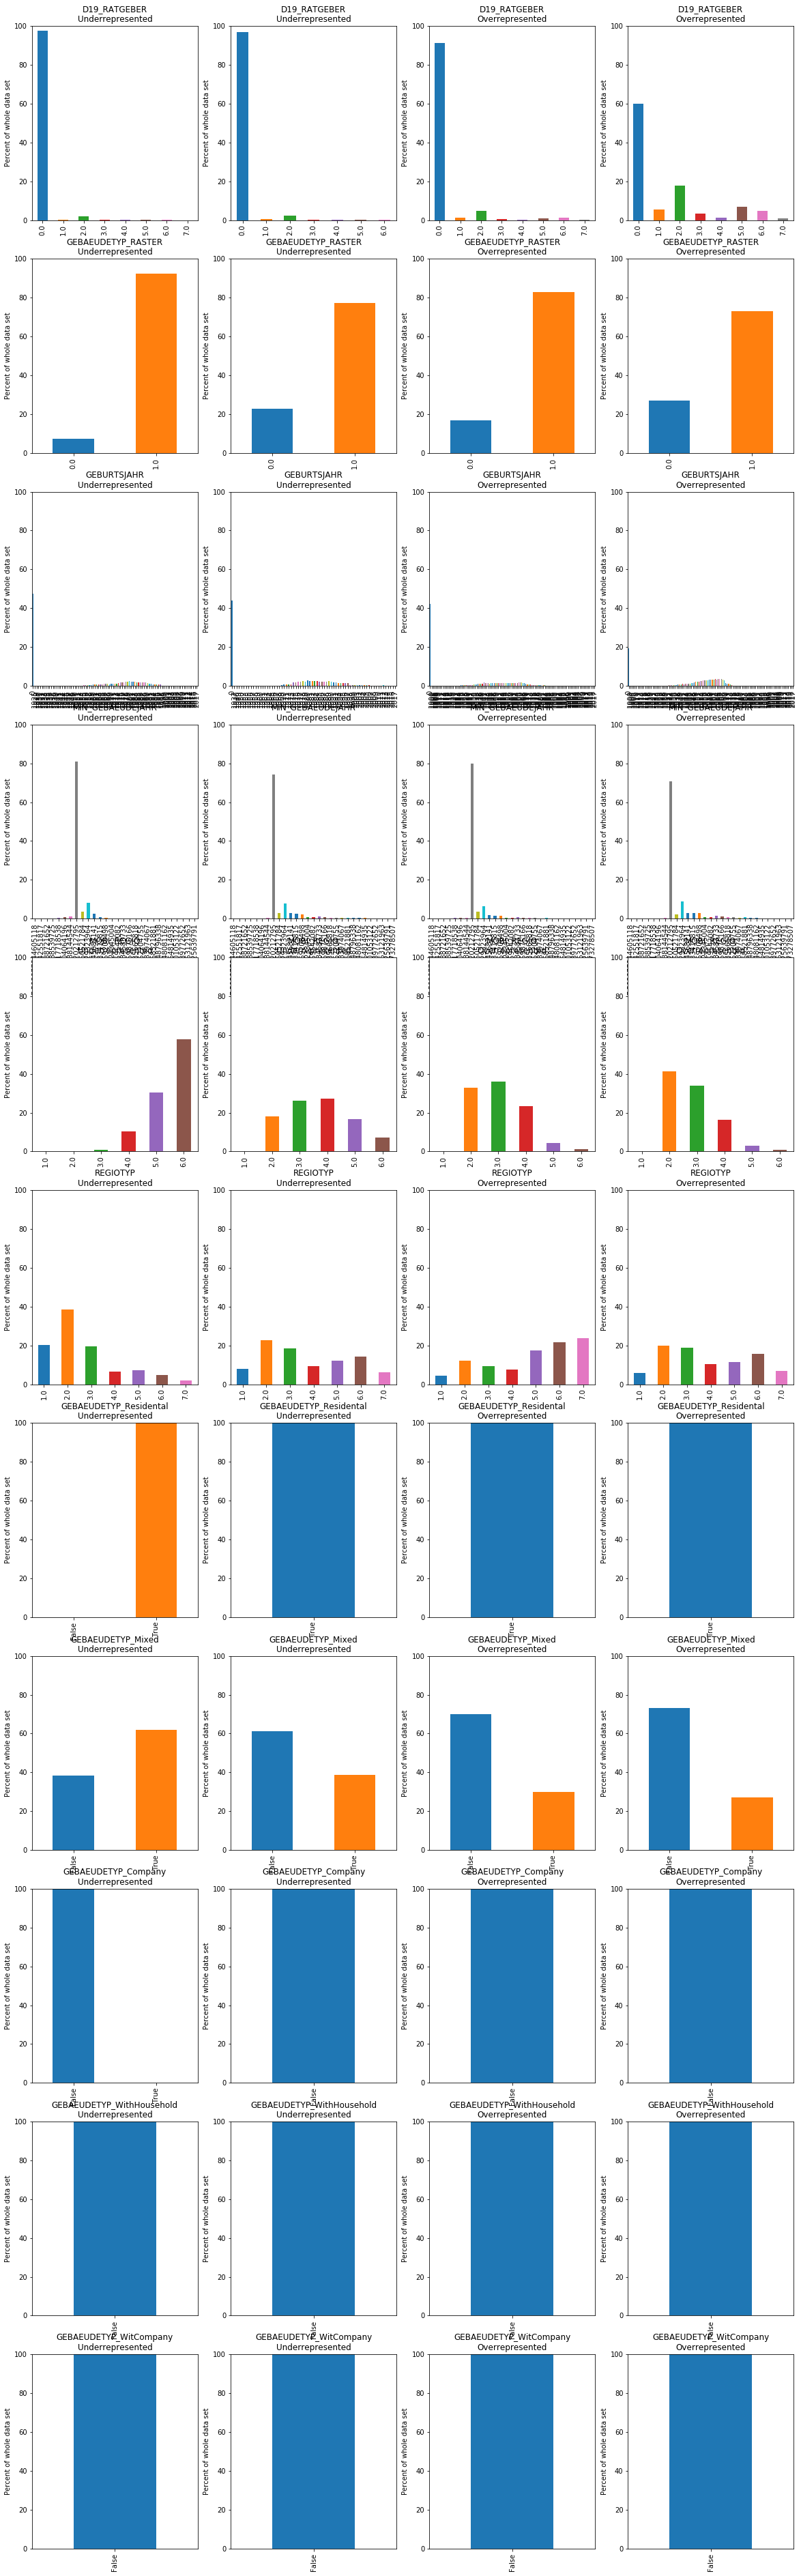

In [166]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*reg*', '*geb*']))

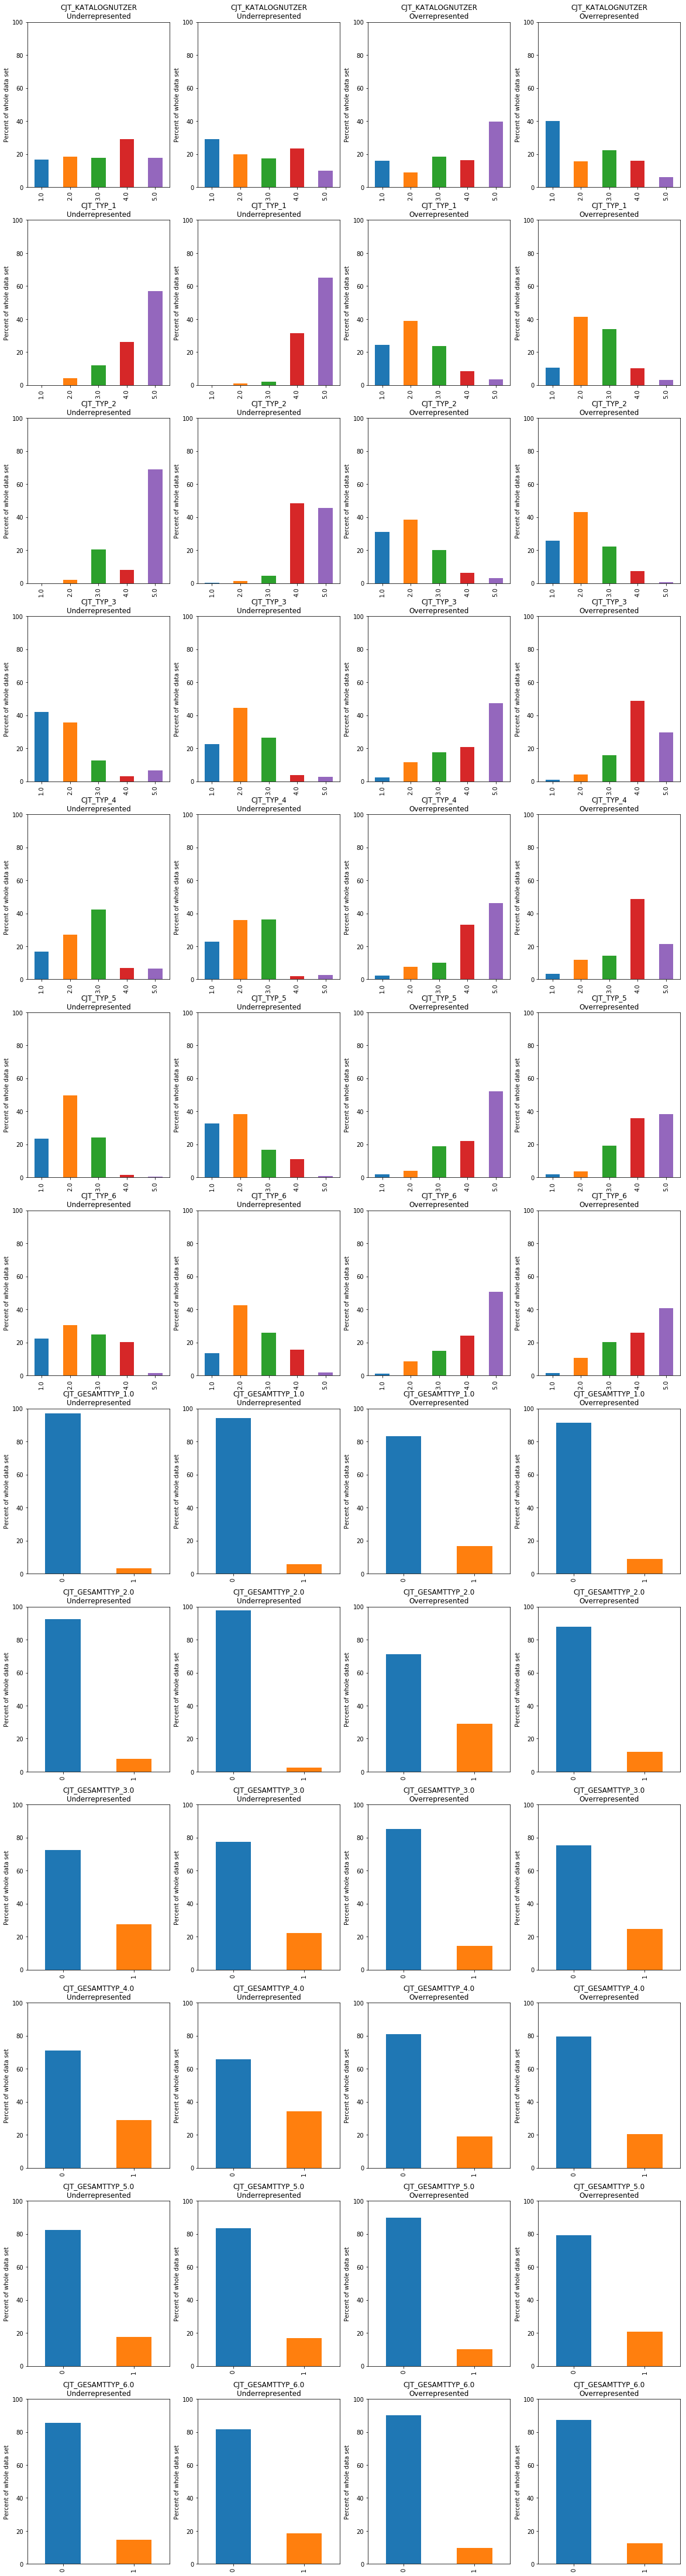

In [167]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*cjt*']))

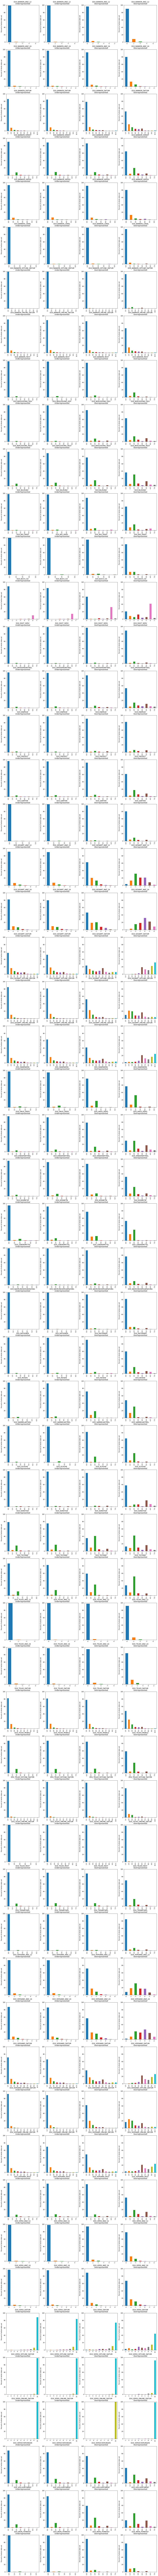

In [168]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*d19*']))

I will refer to the zero based index of the cluster centers I discuss now:

The proportion of data shows differences. The Azdias dataset is almost uniformly distributed ("almost" because the clusters 4, 5 are kind of outliners. The sixth is lower than the average, the fifth is nearly at 10%. 

The AZ Direct customer dataset has a high proportion of cluster 4, 5 and a low proportion of 0, 2,  is almost equal (just a few percent difference).

So having a look at the diagrams and for example the cluster center 5, I can say that:

as these columns are one-hot encoded, the tendence to be an older person is very high and the tendence to be young is very low as we can see in the value count plot above.


The customers seem to be more financial investors, no financial minimalists (over 60% in 5th cluster), but rather money savers. 
This goes along with the fact that FINANZTYP_2, 5 are almost not present, but 3 and 1 are overrepresented.
They tend to be over 45 
ALTERSKATEGORIE is one-hot encoded and the fact that 3/4 are are over .35 and .58 means that these people tend to be over 45, more likely to be 60 (PRAEGENDE_JUGENDJAHRE_Ages 6.343486975344817). Finally, they live in regions with a low movement rate.


In contrast to these people stand those whoe are described by cluster center 3 and 11. They are younger than 45 and the tendency to be a financial minimalist is very high, being a money saver, investor or a person with a own house in focus is very low. They live in regions with a high share of households with 6 persons and more and a high movement rate. 
All these descriptions go with the fact that people in the underrepresented clusters tend to be not traditional minded, but the people in the overrepresented cluster are highly trad. minded.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [169]:
engine = create_engine('sqlite:///{}'.format('CustomerData.db'))

azdiasTrain = pd.read_sql_table('azdiastrain', engine)

In [170]:
azdiasTrainPrep = PrepareForSegmentation(azdiasTrain, testData = True)

-------------------- Start converting missing values to nan --------------------
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 7899 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 7899 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0'] - 7397 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 361 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_CCM4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_DIESEL - ['-1', -1.0, '-1.0', '9', 9.0

-------------------- Finished --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['LNR', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE', 'VERDICHTUNGSRAUM', 'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'D19_KONSUMTYP_MAX', 'KBA05_BAUMAX', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA13_BAUMAX', 'PLZ8_BAUMAX', 'KBA05_MOTOR', 'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_MOTOR', 'KBA13_KW_61_120', 'KBA13_KW_0_60', 'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211', 'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60', 'KB

-------------------- - --------------------
current column:  D19_DROGERIEARTIKEL
-------------------- Applying reorder on D19_DROGERIEARTIKEL: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_ENERGIE
-------------------- Applying reorder on D19_ENERGIE: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_FREIZEIT
-------------------- Applyin

-------------------- - --------------------
current column:  D19_SONSTIGE
-------------------- Applying reorder on D19_SONSTIGE: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_TECHNIK
-------------------- Applying reorder on D19_TECHNIK: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_TELKO_DATUM
-------------------- Applying reorder o

-------------------- - --------------------
current column:  GEBAEUDETYP_RASTER
-------------------- Applying reorder on GEBAEUDETYP_RASTER: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['business cell']  -  ['business cell', 'mixed cell with high business share', 'mixed cell with middle business share', 'mixed cell with low business share']
-------------------- - --------------------
current column:  HH_EINKOMMEN_SCORE
-------------------- Applying reorder on HH_EINKOMMEN_SCORE: {1: 6.0, 2: 5.0, 3: 4.0, 4: 3.0, 5: 2.0, 6: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest income', 'very high income', 'high income', 'average income', 'lower income']
-------------------- - --------------------
current column:  KBA05_HERSTTEMP
-------------------- Applying reorder on KBA05_HERSTTEMP: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'promoted', 'stayed upper level', 

-------------------- Finshed shifting vaues --------------------
-------------------- Starting one-hot encodng --------------------
Binary encoding column:  OST_WEST_KZ
Old value counts:  W    26752
O     8433
Name: OST_WEST_KZ, dtype: int64
New value counts:  0.0    26752
1.0     8433
Name: OST_WEST_KZ, dtype: int64
--------------------  --------------------
Feature does not exist anymore: AGER_TYP
-------------------- - --------------------
Binary encoding column:  ANREDE_KZ
Old value counts:  2    25566
1    17396
Name: ANREDE_KZ, dtype: int64
New value counts:  1    25566
0    17396
Name: ANREDE_KZ, dtype: int64
-------------------- Start applying one-hot encoding on: ['ALTERSKATEGORIE_GROB'] --------------------
Columns before one hot encoding:  318
Columns to be removed and replaced:  ['ALTERSKATEGORIE_GROB']
Size after encoding:  322
Columns successfully one hot encoded :)  New columns are:  ['ALTERSKATEGORIE_GROB_1', 'ALTERSKATEGORIE_GROB_2', 'ALTERSKATEGORIE_GROB_3', 'ALTERSKA

In [173]:
TrainPrepLabels = azdiasTrainPrep['RESPONSE']

In [174]:
azdiasTrainPrepX = azdiasTrainPrep.drop('RESPONSE', axis = 1)

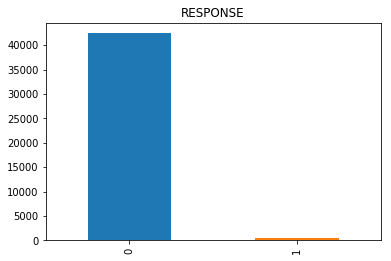

In [179]:
ax = TrainPrepLabels.value_counts().plot(kind = 'bar')
_ = ax.set_title('RESPONSE')

The data is very imbalanced. For training, we need to split the data into train and test sets. The class train_test_split cannot be used because it splits data randomly. To avoid having all true labeled persons in one set, another split algorithm must be used. 
Going through the documentation of KFolds (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold), StraightKFolds was mentioned and the note '...avoid building folds with imbalanced class distributions...' got my attention. As the documentation says 'The folds are made by preserving the percentage of samples for each class.' I decide to use this split method.

The model needs also to be validated. For that, there are two approaches but only one is applicable because of the inbalanced data:
- split data into train, test, validation
- do cross validation.

I decided for the latter and use learning_curve that supports cross-validation as the documentation says 'A cross-validation generator splits the whole dataset k times in training and test data.'

##### Models
Several ensemble methods are tested with default parameters to choose the best. Ensemble Learning is method of building a model on top of other models. Random Forest Classifier, Adaboost Classifier and Gradient Boosting Classifier are all ensemble classifiers build on top of Desition tree model (by default). These ensemble models work great both for classification and for regression problems and in general has the following benefits:

improves the stability and accuracy of machine learning algorithms
reduces variance of a single estimate from one model as they combine several estimates from several models
helps to avoid overfitting
Metric
ROC_AUC score will be used to evaluate performances of models. AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.

##### Model evaluation
For model evaluation I use learning curve method. A learning curve shows the validation and training score of an estimator for varying numbers of training samples 10%-100% of training data. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

In [180]:
rndom = 42
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state = rndom), 
    'AdaBoostClassifier': AdaBoostClassifier(random_state = rndom), 
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = rndom)
}

In [188]:
def ShuffleData(X, y):
    '''
    Shuffles data.

    INPUT:
    X: DataFrame
    y: Series
        
    OUTPUT:
    X2: shuffled DataFrame X
    y2: shuffled Series y2
    '''
    X2 = pd.concat([X,y], axis=1)
    X2 = X2.sample(frac=1, random_state=42)
    y2 = X2["RESPONSE"]
    X2 = X2.drop(["RESPONSE"], axis=1)
    return X2, y2

def TrainModels(trainX, trainY, models):
    dsh.PrintEncapsulate(list(models.keys()), header = 'Start training with models:')
    results = []
    
#     X, y = ShuffleData(azdiasTrainPrepX, TrainPrepLabels)
        
#     X = Impute(X, False)
#     X = Scale(X, False)
    
    for name, mod in models.items():
        
        #X, y = ShuffleData(X, y)
        X, y = ShuffleData(trainX, trainY)
        
        X = Impute(X, False)
        X = Scale(X, False)
    
        numTrain = 10
        
        dtstart = datetime.now()
        
        print('{} started trainig: {}'.format(name, dtstart))
        
        trainSizes, trainScores, testScores = learning_curve(
        mod, X, y, cv = None, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, numTrain))
        
        print('Finished trainig: {}'.format(datetime.now() - dtstart))
        
        train_scores_mean = np.mean(trainScores, axis=1)
        test_scores_mean = np.mean(testScores, axis=1)
        print("Roc_auc train score = {}".format(train_scores_mean[-1].round(2)))
        print("Roc_auc validation score = {}".format(test_scores_mean[-1].round(2)))

        plt.grid()

        plt.title("Learning Curves")
        plt.xlabel("% of training set")
        plt.ylabel("Score")

        plt.plot(np.linspace(.1, 1.0, numTrain)*100, train_scores_mean, 'o-', color="g",
                 label="Training score")
        plt.plot(np.linspace(.1, 1.0, numTrain)*100, test_scores_mean, 'o-', color="y",
                 label="Cross-validation score")

        plt.yticks(np.arange(0.45, 1.02, 0.05))
        plt.xticks(np.arange(0., 100.05, numTrain))
        plt.legend(loc="best")
        print("")
        plt.show()
        
        results.append((trainSizes, trainScores, testScores, mod))
        
    return results

-------------------- Start training with models: --------------------
['LogisticRegression', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']
-------------------- - --------------------
LogisticRegression started trainig: 2018-12-23 15:44:41.588259
Finished trainig: 0:01:13.691019
Roc_auc train score = 0.79
Roc_auc validation score = 0.56



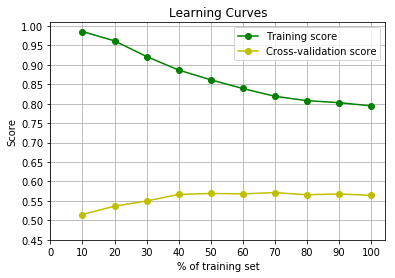

RandomForestClassifier started trainig: 2018-12-23 15:45:56.805261
Finished trainig: 0:00:12.883997
Roc_auc train score = 0.99
Roc_auc validation score = 0.51



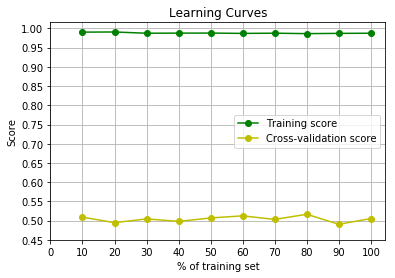

AdaBoostClassifier started trainig: 2018-12-23 15:46:11.164340
Finished trainig: 0:01:47.600085
Roc_auc train score = 0.77
Roc_auc validation score = 0.55



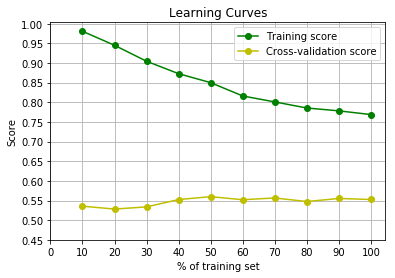

GradientBoostingClassifier started trainig: 2018-12-23 15:48:00.226591
Finished trainig: 0:06:08.680031
Roc_auc train score = 0.91
Roc_auc validation score = 0.58



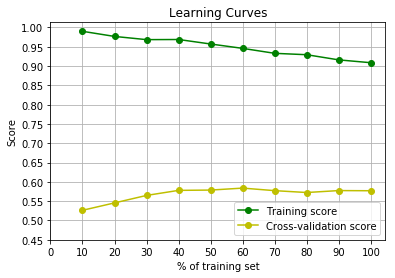

[(array([ 2864,  5728,  8592, 11456, 14320, 17184, 20048, 22912, 25776,
         28640]), array([[0.98161296, 0.98785056, 0.98785056],
         [0.97066454, 0.95719828, 0.95719828],
         [0.92923799, 0.91753342, 0.91753342],
         [0.88244888, 0.88882742, 0.88882742],
         [0.83896226, 0.87370038, 0.87212066],
         [0.82316265, 0.84172915, 0.85275678],
         [0.79754283, 0.83418508, 0.82599523],
         [0.78450514, 0.82405997, 0.81542822],
         [0.7857834 , 0.81556536, 0.807127  ],
         [0.78418063, 0.80606523, 0.79359283]]), array([[0.51076766, 0.5198607 , 0.51444467],
         [0.52312054, 0.5650876 , 0.52121211],
         [0.53436443, 0.56625765, 0.5487001 ],
         [0.55719621, 0.57587331, 0.56701425],
         [0.56096999, 0.5580613 , 0.58853614],
         [0.57065647, 0.55546235, 0.57835203],
         [0.59722867, 0.5396377 , 0.57735056],
         [0.59463297, 0.53587629, 0.56724314],
         [0.60177222, 0.53535218, 0.56630199],
         [0.5994859

In [183]:
TrainModels(azdiasTrainPrepX, TrainPrepLabels, models)

Lets start with the worst:

The error for RandomForestClassifier is low on the train set (roc score almost 100%), but high on the test set (roc score circa 50%). This means that the model is totally overfitted and we cannot improve the precision by adding more samples. These lines won't come closer.

LogisticRegression and Adaboostclassifier are very similar in this case and better than RandomForest. The training score decreases to 83%-80% and test test score increases to 60%-58%. 

GradientBoostClassifier scores with 62% in test, 96% in train, so I decide to use this classifier for parameter optimization.

In [ ]:
blub = GradientBoostingClassifier()
blub.get_params()

In [189]:
parameters = {'learning_rate': [0.1, 0.2], 'n_estimators': [20, 50, 100], 
              'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 8]}

gsX, gsY = azdiasTrainPrep.drop('RESPONSE', axis = 1), azdiasTrainPrep['RESPONSE']

gsX = Scale(Impute(gsX))

model = GradientBoostingClassifier(random_state = rndom)
gs = GridSearchCV(model, parameters, scoring = 'roc_auc')

# Fit the grid search object to the training data and find the optimal parameters
gs.fit(gsX, gsY)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [20, 50, 100], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [190]:
# Get the estimator and predict
print(gs.best_params_)
best_clf = gs.best_estimator_
best_predictions = best_clf.predict_proba(gsX)[:, 1]

{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 20}


In [191]:
# Make predictions using unoptimized and the best model
predictions = (model.fit(gsX, gsY)).predict_proba(gsX)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(TrainPrepLabels, predictions)))
print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(TrainPrepLabels, best_predictions)))

Roc_auc score on training data: 0.8794
Final Roc_auc score on the training data: 0.7301


In [192]:
pkl_filename = "BestGradientBoost.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(best_clf, file)

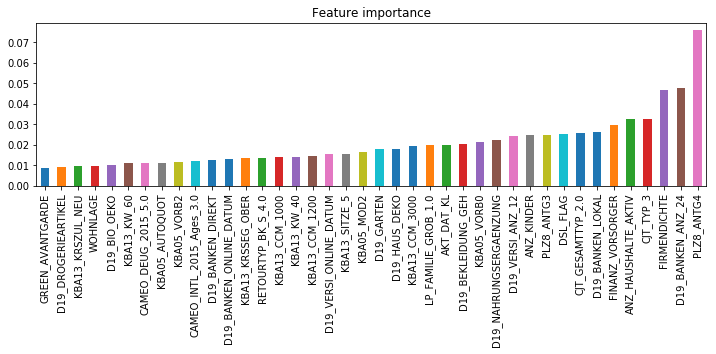

In [208]:
feature_importances = best_clf.feature_importances_

ax = pd.Series(feature_importances, index=azdiasTrainPrep.drop('RESPONSE', axis = 1).columns).sort_values()[-40:].plot(kind='bar', figsize=(12, 3))
_ = ax.set_title('Feature importance')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [209]:
mailout_test = pd.read_sql_table('customerstest', engine)

In [210]:
mailout_test.shape

(42833, 366)

In [211]:
mailout_testPrep = PrepareForSegmentation(mailout_test, testData = True)

-------------------- Start converting missing values to nan --------------------
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 7747 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 7747 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0'] - 7332 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 344 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 371 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_CCM4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_DIESEL - ['-1', -1.0, '-1.0', '9', 9.0

-------------------- Finished --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['LNR', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE', 'VERDICHTUNGSRAUM', 'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'D19_KONSUMTYP_MAX', 'KBA05_BAUMAX', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA13_BAUMAX', 'PLZ8_BAUMAX', 'KBA05_MOTOR', 'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_MOTOR', 'KBA13_KW_61_120', 'KBA13_KW_0_60', 'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211', 'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60', 'KB

-------------------- - --------------------
current column:  D19_DROGERIEARTIKEL
-------------------- Applying reorder on D19_DROGERIEARTIKEL: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_ENERGIE
-------------------- Applying reorder on D19_ENERGIE: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_FREIZEIT
-------------------- Applyin

-------------------- - --------------------
current column:  D19_SONSTIGE
-------------------- Applying reorder on D19_SONSTIGE: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_TECHNIK
-------------------- Applying reorder on D19_TECHNIK: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['no transaction known']  -  ['no transaction known', 'Multibuyer 0-12 months', 'Doublebuyer 0-12 months', 'Singlebuyer 0-12 months', 'Multi-/Doublebuyer 13-24 months', 'Singlebuyer 13-24 months', 'Buyer > 24 months']
-------------------- - --------------------
current column:  D19_TELKO_DATUM
-------------------- Applying reorder o

-------------------- - --------------------
current column:  FINANZ_VORSORGER
-------------------- Applying reorder on FINANZ_VORSORGER: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'very high', 'high', 'average', 'low']
-------------------- - --------------------
current column:  GEBAEUDETYP_RASTER
-------------------- Applying reorder on GEBAEUDETYP_RASTER: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['business cell']  -  ['business cell', 'mixed cell with high business share', 'mixed cell with middle business share', 'mixed cell with low business share']
-------------------- - --------------------
current column:  HH_EINKOMMEN_SCORE
-------------------- Applying reorder on HH_EINKOMMEN_SCORE: {1: 6.0, 2: 5.0, 3: 4.0, 4: 3.0, 5: 2.0, 6: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest income', 'very high income', 'high income', 'average income', 'lower in

-------------------- Finished reordering values --------------------
-------------------- Start shifting vaues --------------------
-------------------- Finshed shifting vaues --------------------
-------------------- Starting one-hot encodng --------------------
Binary encoding column:  OST_WEST_KZ
Old value counts:  W    26773
O     8433
Name: OST_WEST_KZ, dtype: int64
New value counts:  0.0    26773
1.0     8433
Name: OST_WEST_KZ, dtype: int64
--------------------  --------------------
Feature does not exist anymore: AGER_TYP
-------------------- - --------------------
Binary encoding column:  ANREDE_KZ
Old value counts:  2    25506
1    17327
Name: ANREDE_KZ, dtype: int64
New value counts:  1    25506
0    17327
Name: ANREDE_KZ, dtype: int64
-------------------- Start applying one-hot encoding on: ['ALTERSKATEGORIE_GROB'] --------------------
Columns before one hot encoding:  317
Columns to be removed and replaced:  ['ALTERSKATEGORIE_GROB']
Size after encoding:  321
Columns success

In [212]:
pkl_filename = "BestGradientBoost.pkl"
pickle_model = None

with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file) 
    

In [214]:
#predict target values
kaggle_predict = pickle_model.predict_proba(Scale(Impute(mailout_testPrep)))[:,1]
len(kaggle_predict)

42833

In [215]:
dfMyPred = pd.DataFrame({'RESPONSES': kaggle_predict})

In [216]:
dfMyPred.to_csv('My_Predictions_20181223_1822.csv')

In [ ]:
submission = pd.read_csv('../Arvato-Capstone/Arvato_Capstone_Example_Submission.csv')
submission.RESPONSE = kaggle_predict
submission.to_csv('kaggle_submission.csv', index=False)
submission.shape